In [ ]:
from WSBM import *
from Transformations import *
from Chernoff import *
from Helper import *
from Plot_Helper import *

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [119]:
n = 1000
τ = 0.1

PIS = [0.1, 0.5]
RHOS = [0.25, 0.5]
Models = [betaWSBM, lognormWSBM]
Transforms = [IdentityTransform(), OppositeTransform(), LogTransform(), ThresholdTransform(τ)]

product_params = list(product(PIS, RHOS, Models, Transforms))

In [ ]:
N = 20
refinement = 4

In [ ]:
metrics = {}
for i, p in enumerate(product_params):
	print(f"Running simulation {i+1}/{len(product_params)}")
	pi, rho, model, transformation = p
	#print(f"Parameters: pi = {pi}, rho = {rho}, model = {model.__name__}, transformation = {transformation.name}")
	metrics[p] = get_metrics_in_grid(N, model, (n, rho, np.diag([pi, 1-pi])), transformation, refinement=refinement)

Running simulation 1/32
Parameters: pi = 0.1, rho = 0.25, model = betaWSBM, transformation = Identity
Progress: 100/100 (100.0%). Elapsed: 00:00:41. ETA: 00:00:00.
Running simulation 2/32
Parameters: pi = 0.1, rho = 0.25, model = betaWSBM, transformation = Opposite
Progress: 100/100 (100.0%). Elapsed: 00:00:40. ETA: 00:00:00.
Running simulation 3/32
Parameters: pi = 0.1, rho = 0.25, model = betaWSBM, transformation = Logarithmic
Progress: 100/100 (100.0%). Elapsed: 00:00:36. ETA: 00:00:00.
Running simulation 4/32
Parameters: pi = 0.1, rho = 0.25, model = betaWSBM, transformation = Threshold (τ = 0.1)
Progress: 100/100 (100.0%). Elapsed: 00:00:34. ETA: 00:00:00.
Running simulation 5/32
Parameters: pi = 0.1, rho = 0.25, model = lognormWSBM, transformation = Identity
Progress: 100/100 (100.0%). Elapsed: 00:00:37. ETA: 00:00:00.
Running simulation 6/32
Parameters: pi = 0.1, rho = 0.25, model = lognormWSBM, transformation = Opposite
Progress: 100/100 (100.0%). Elapsed: 00:00:36. ETA: 00:00:

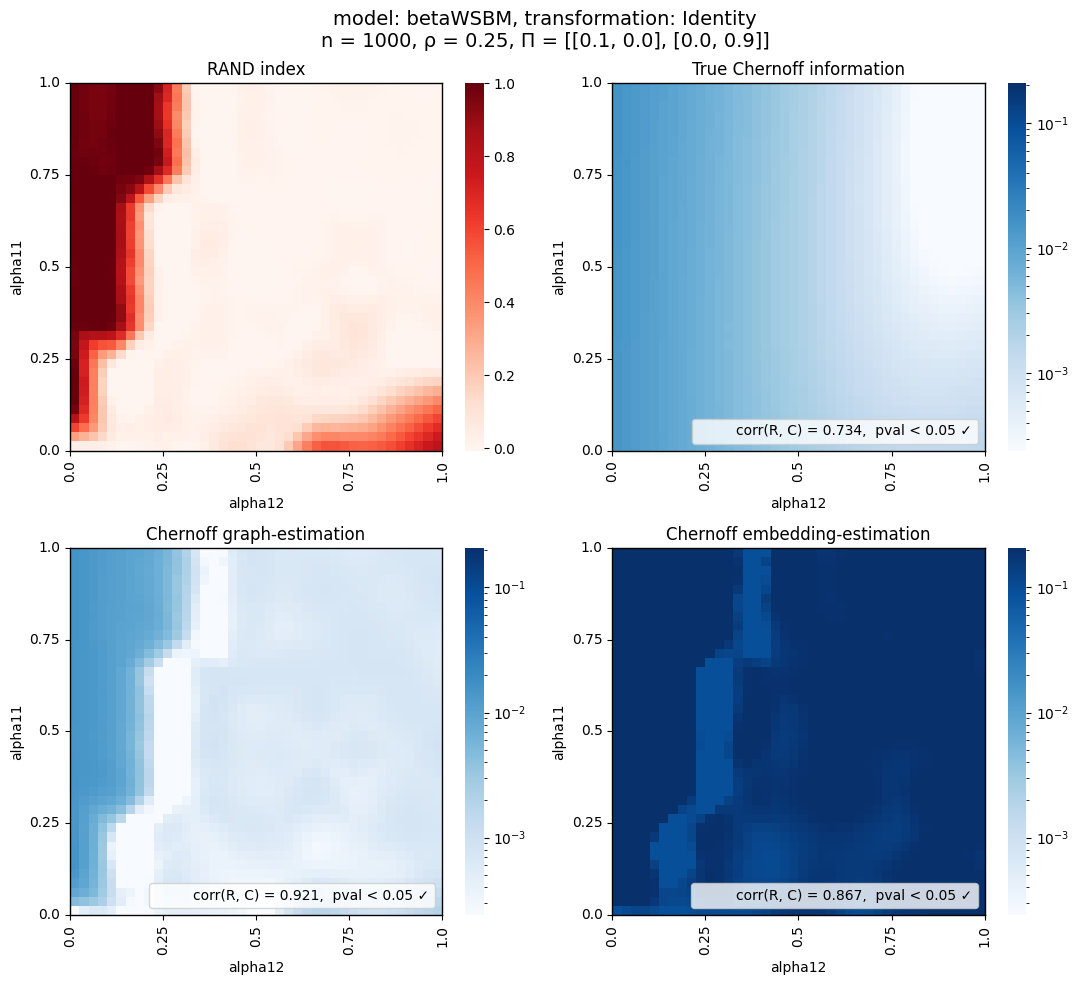

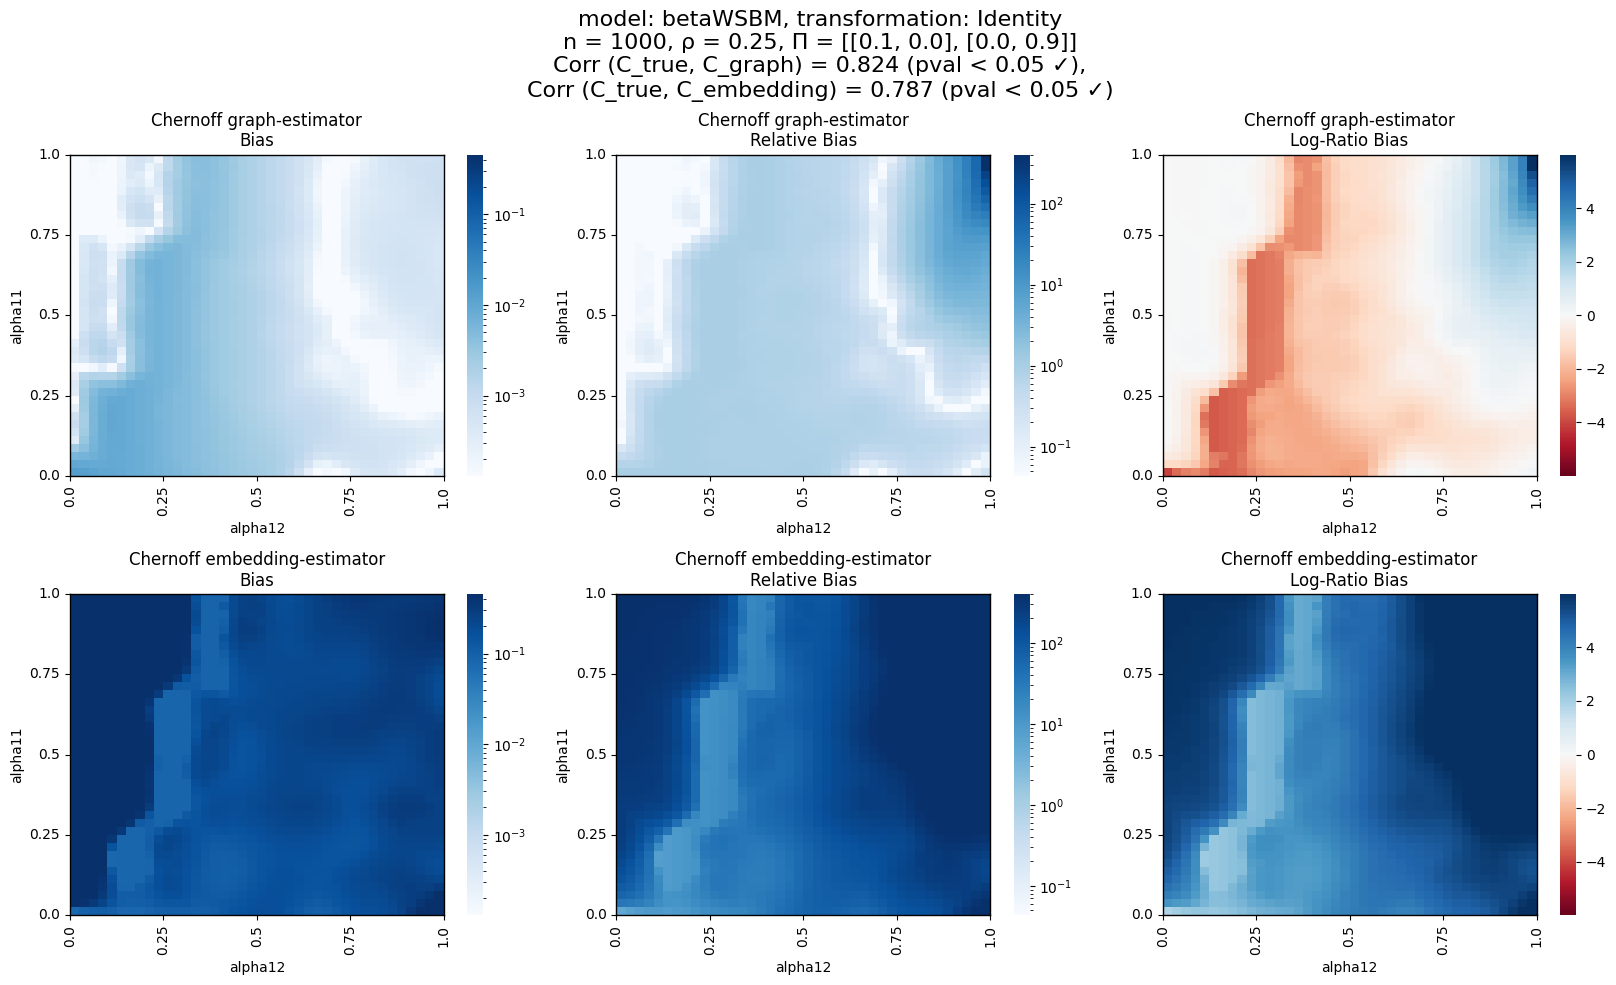

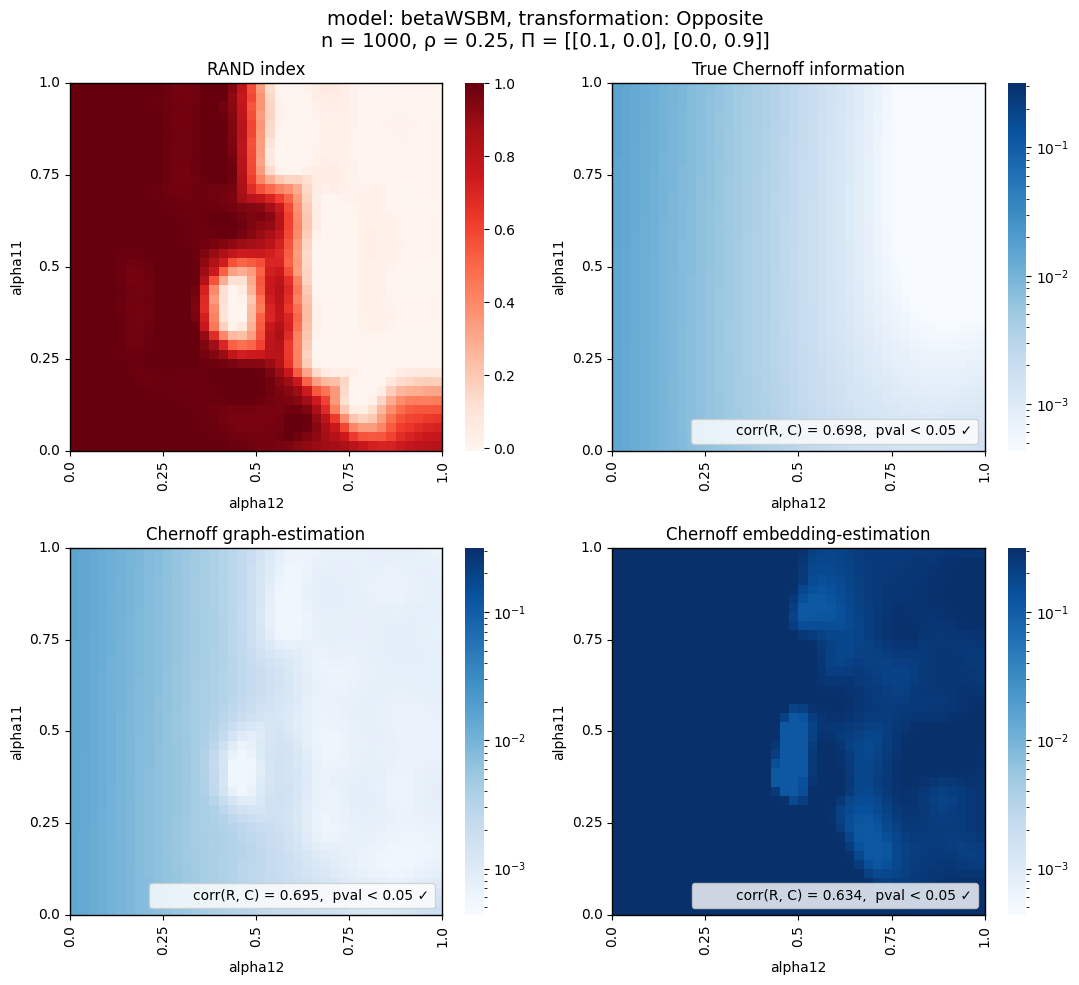

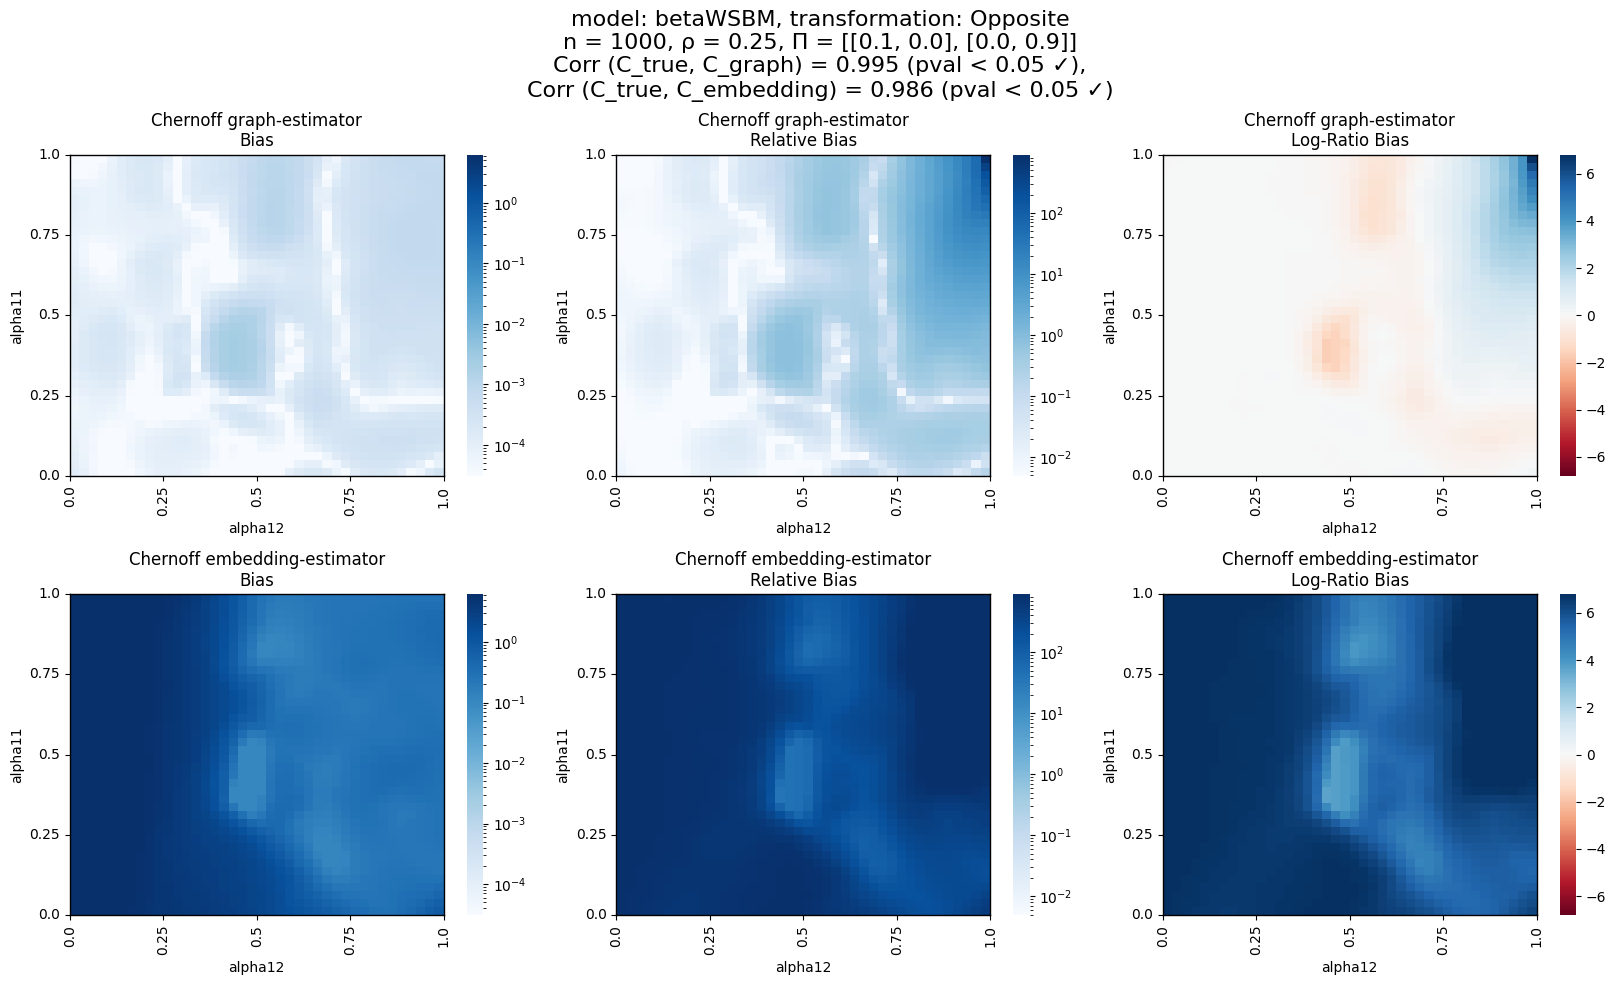

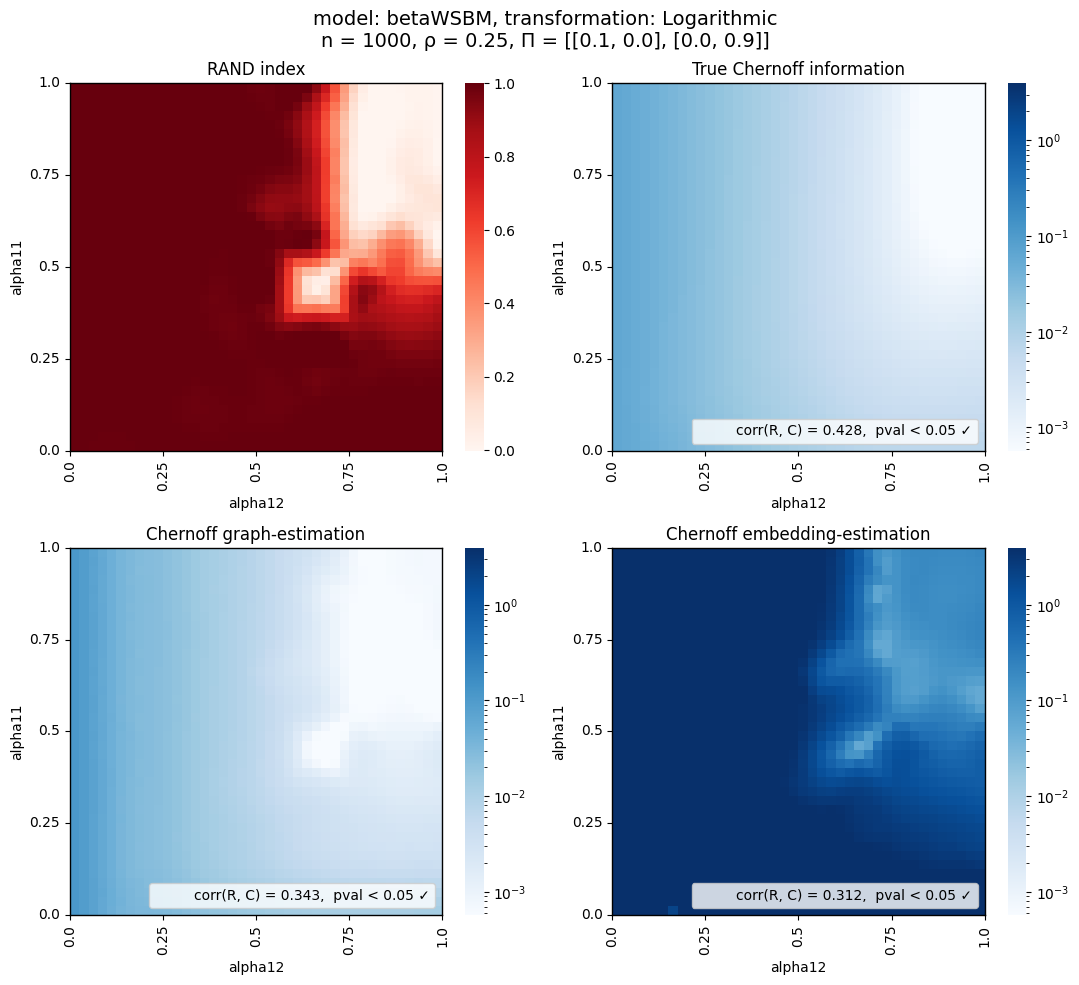

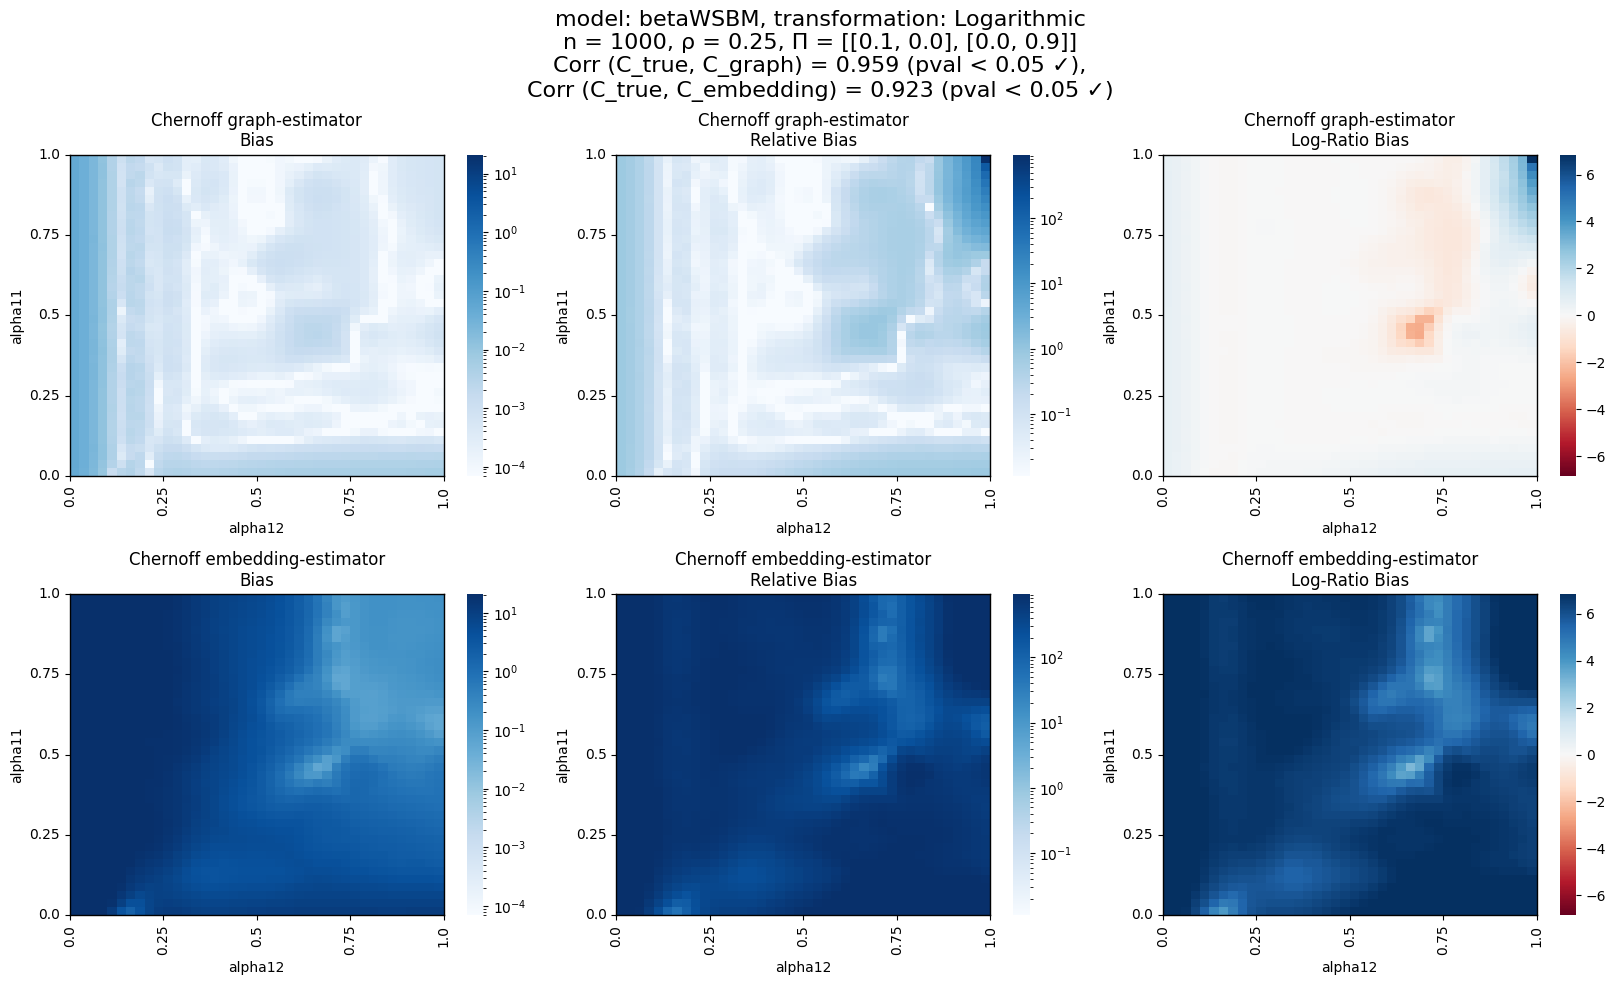

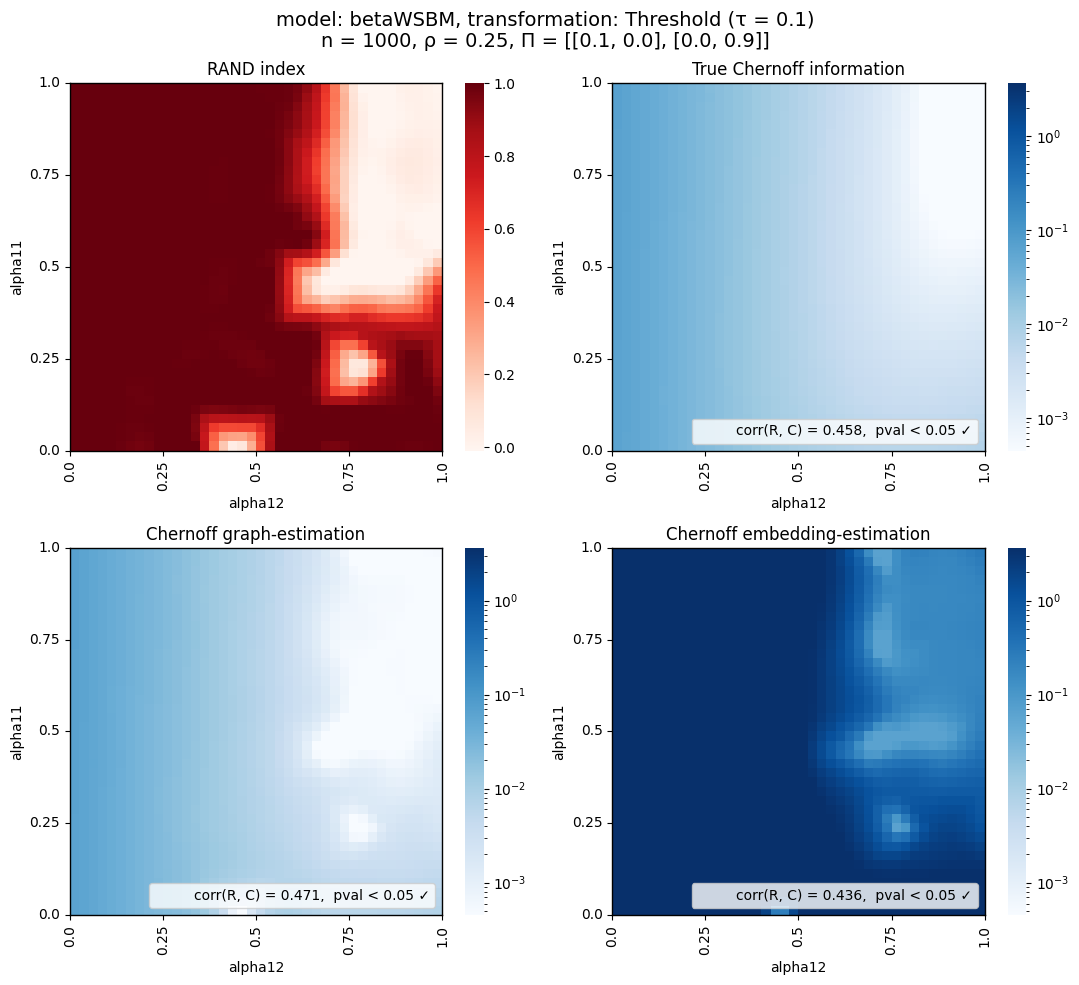

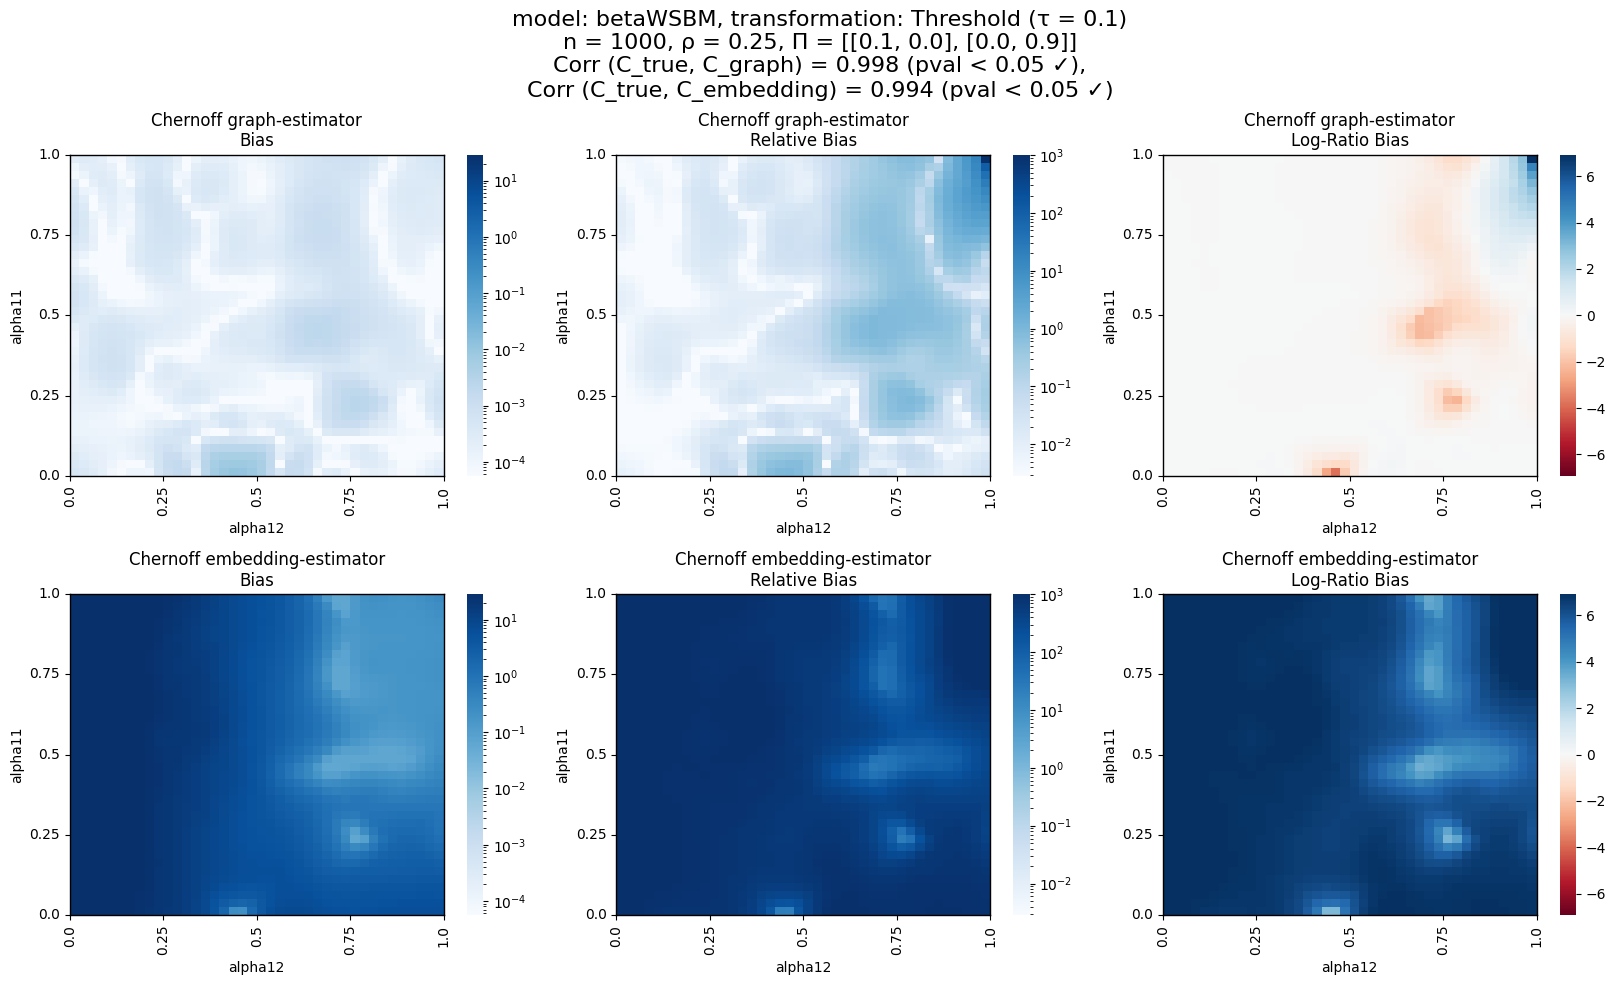

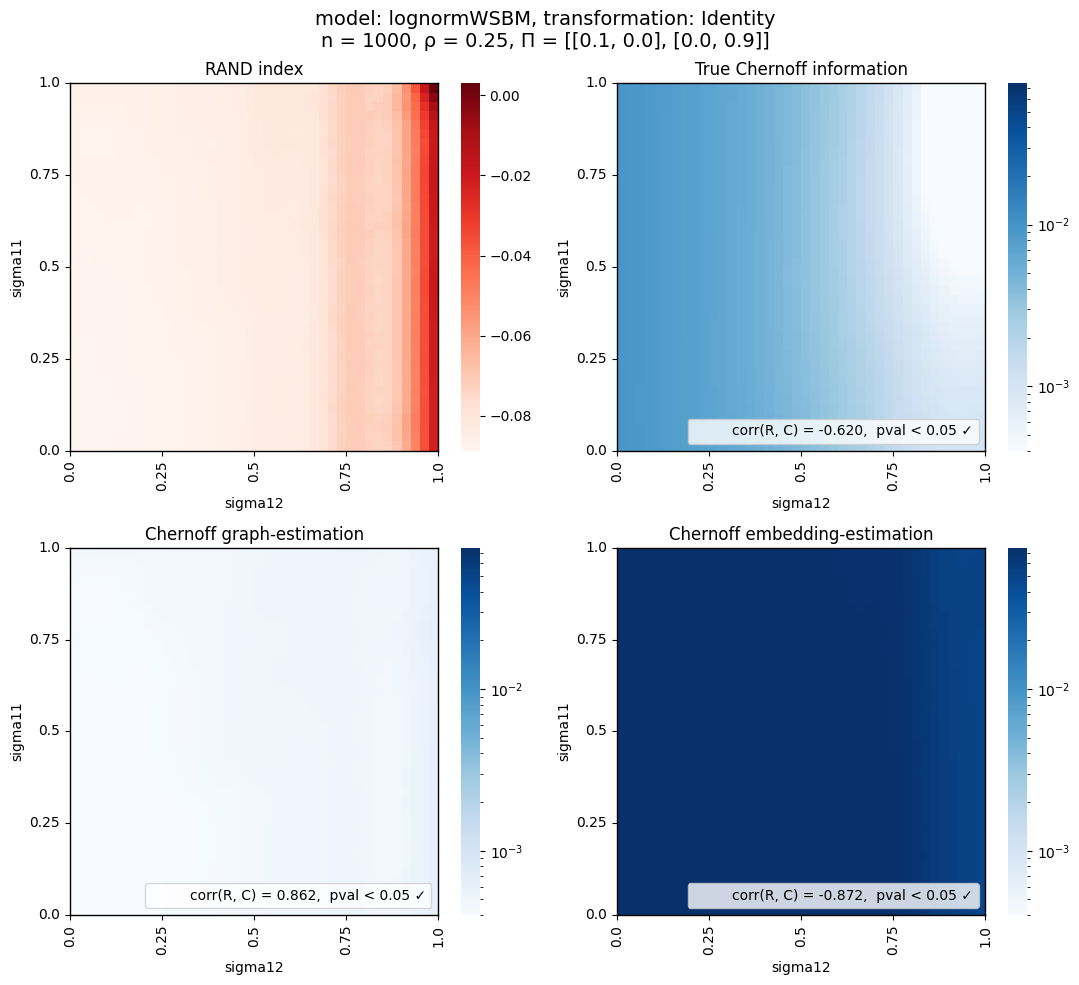

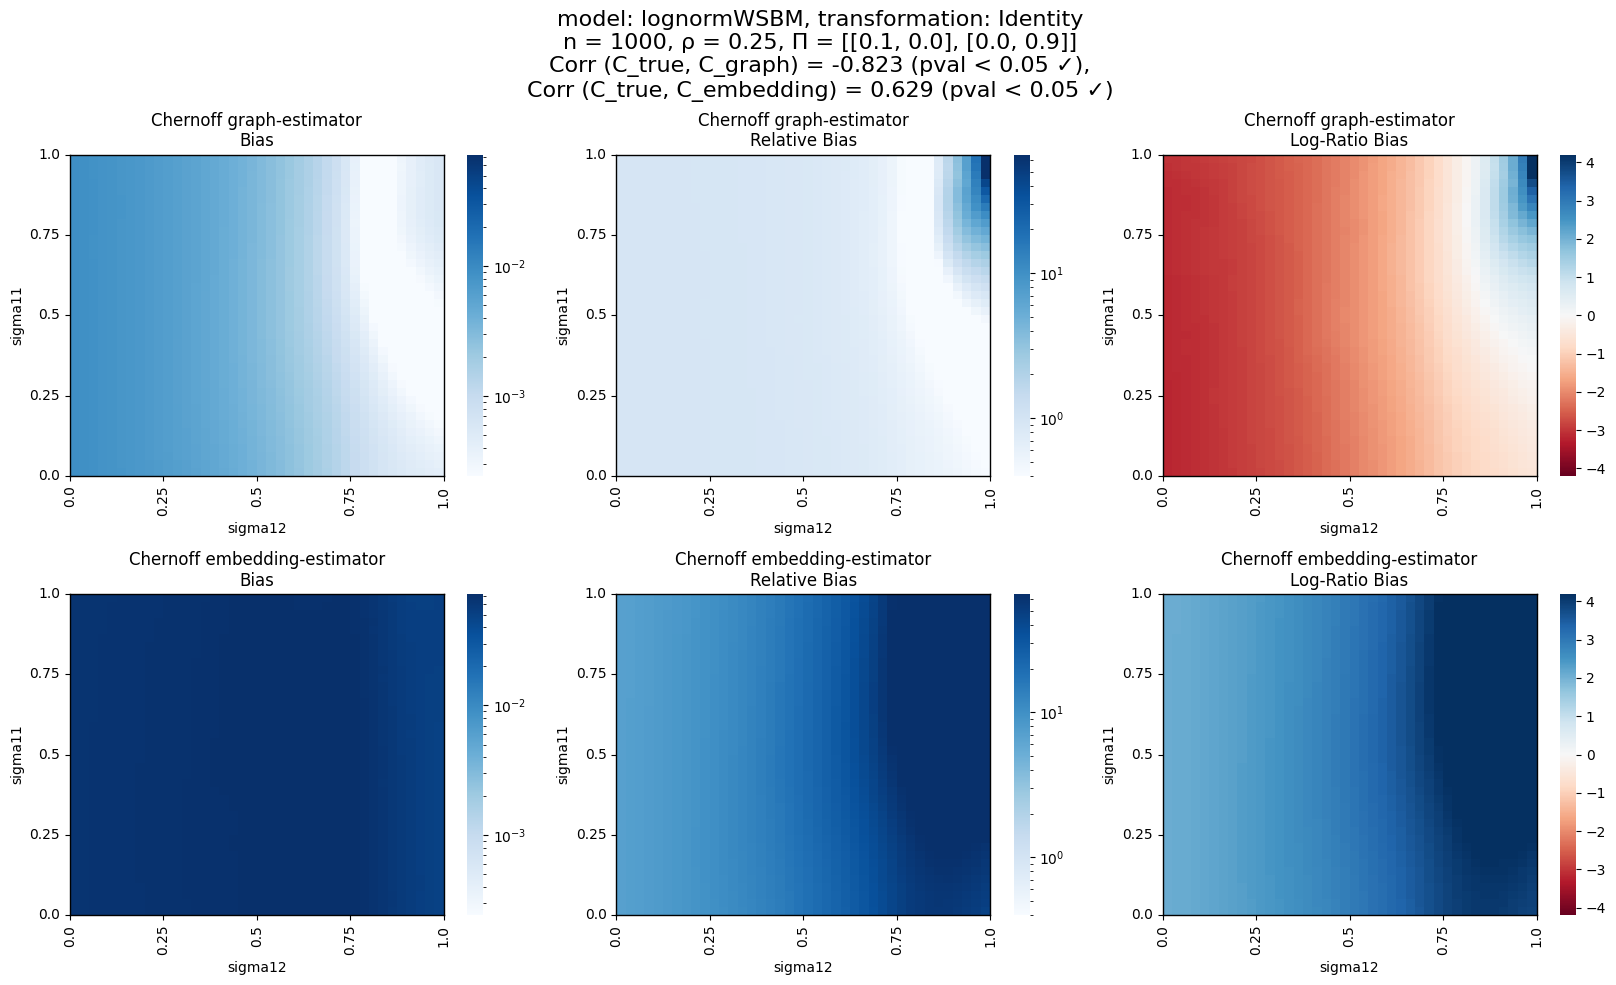

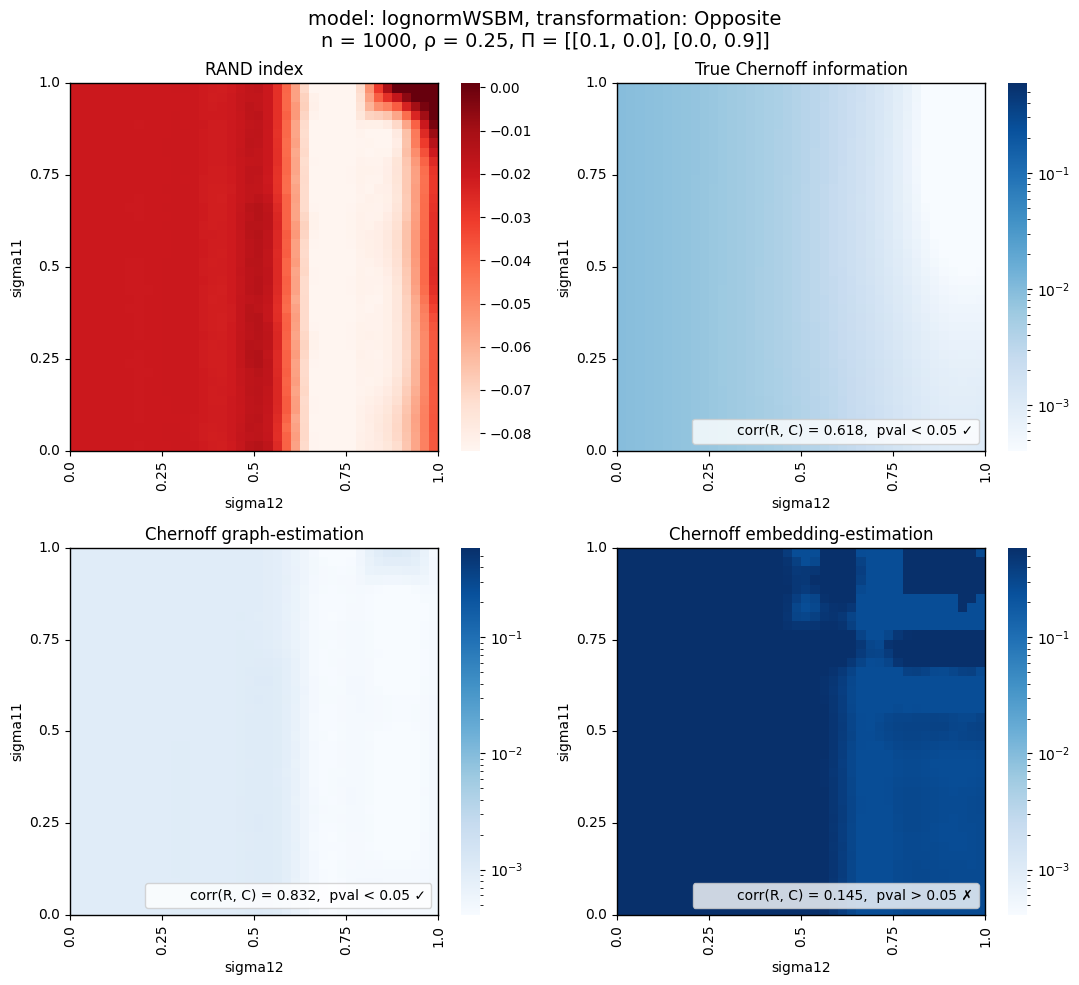

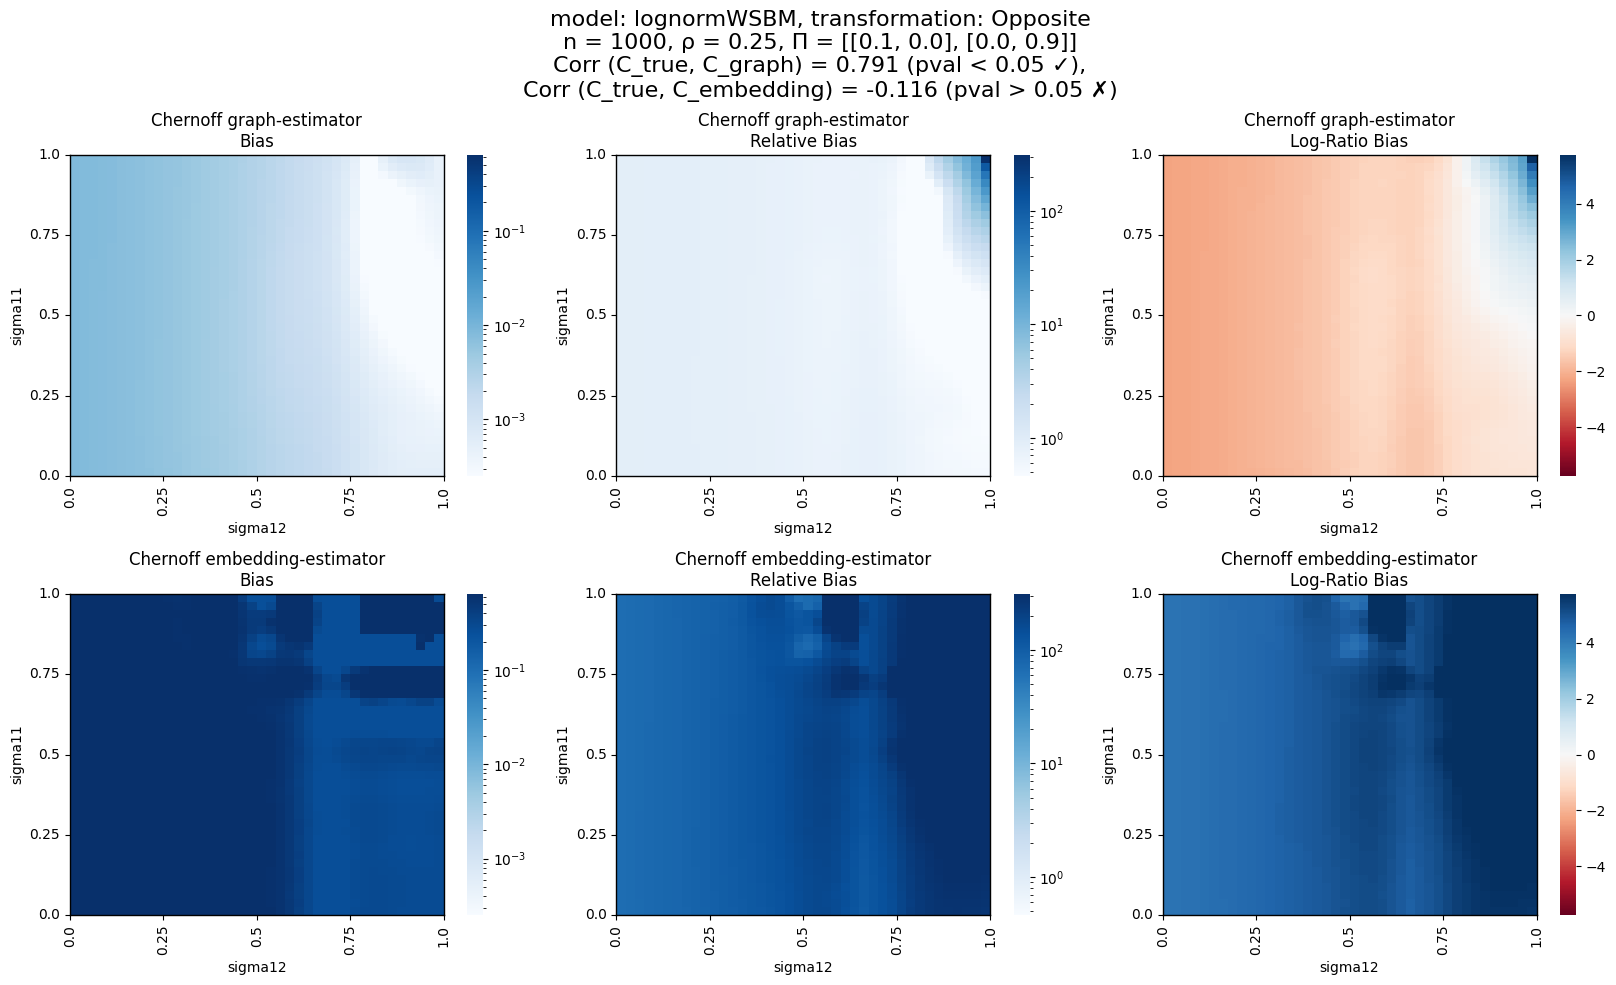

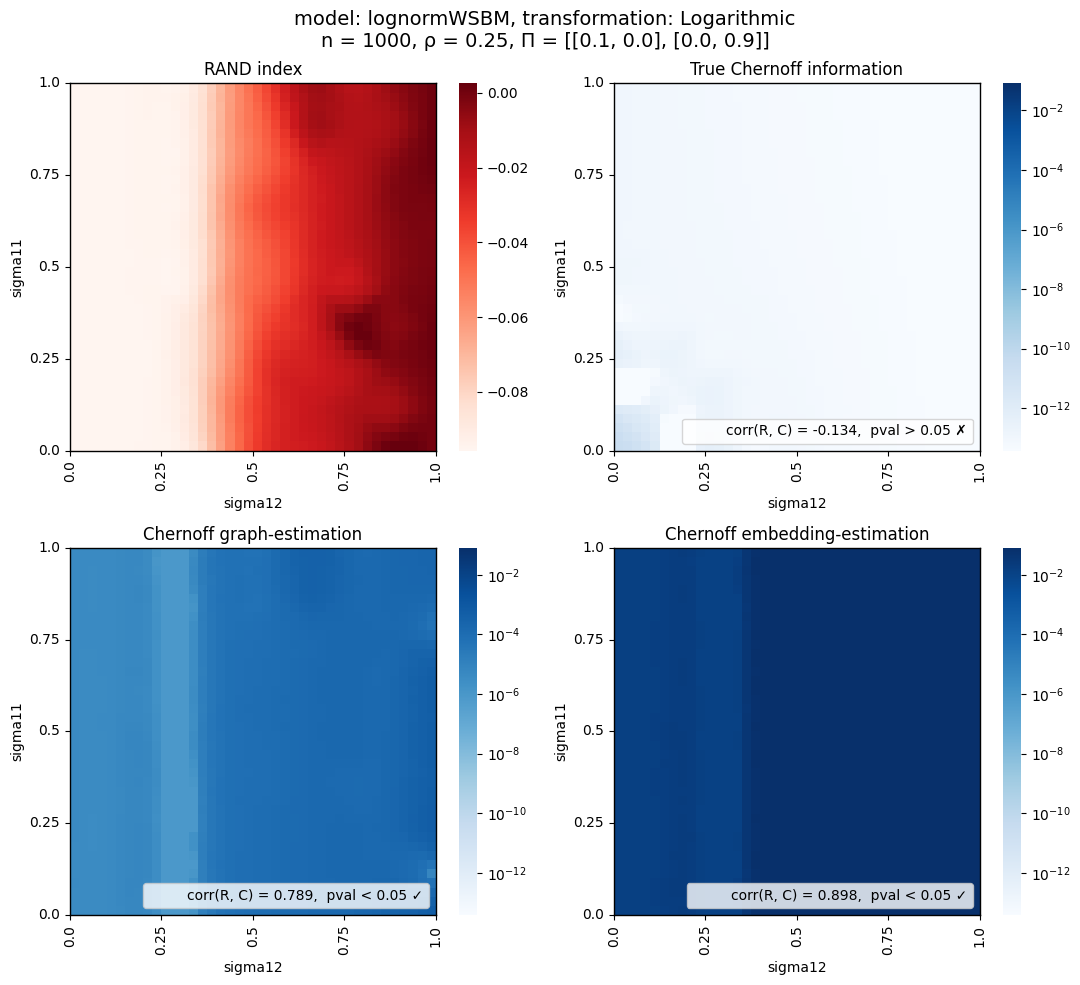

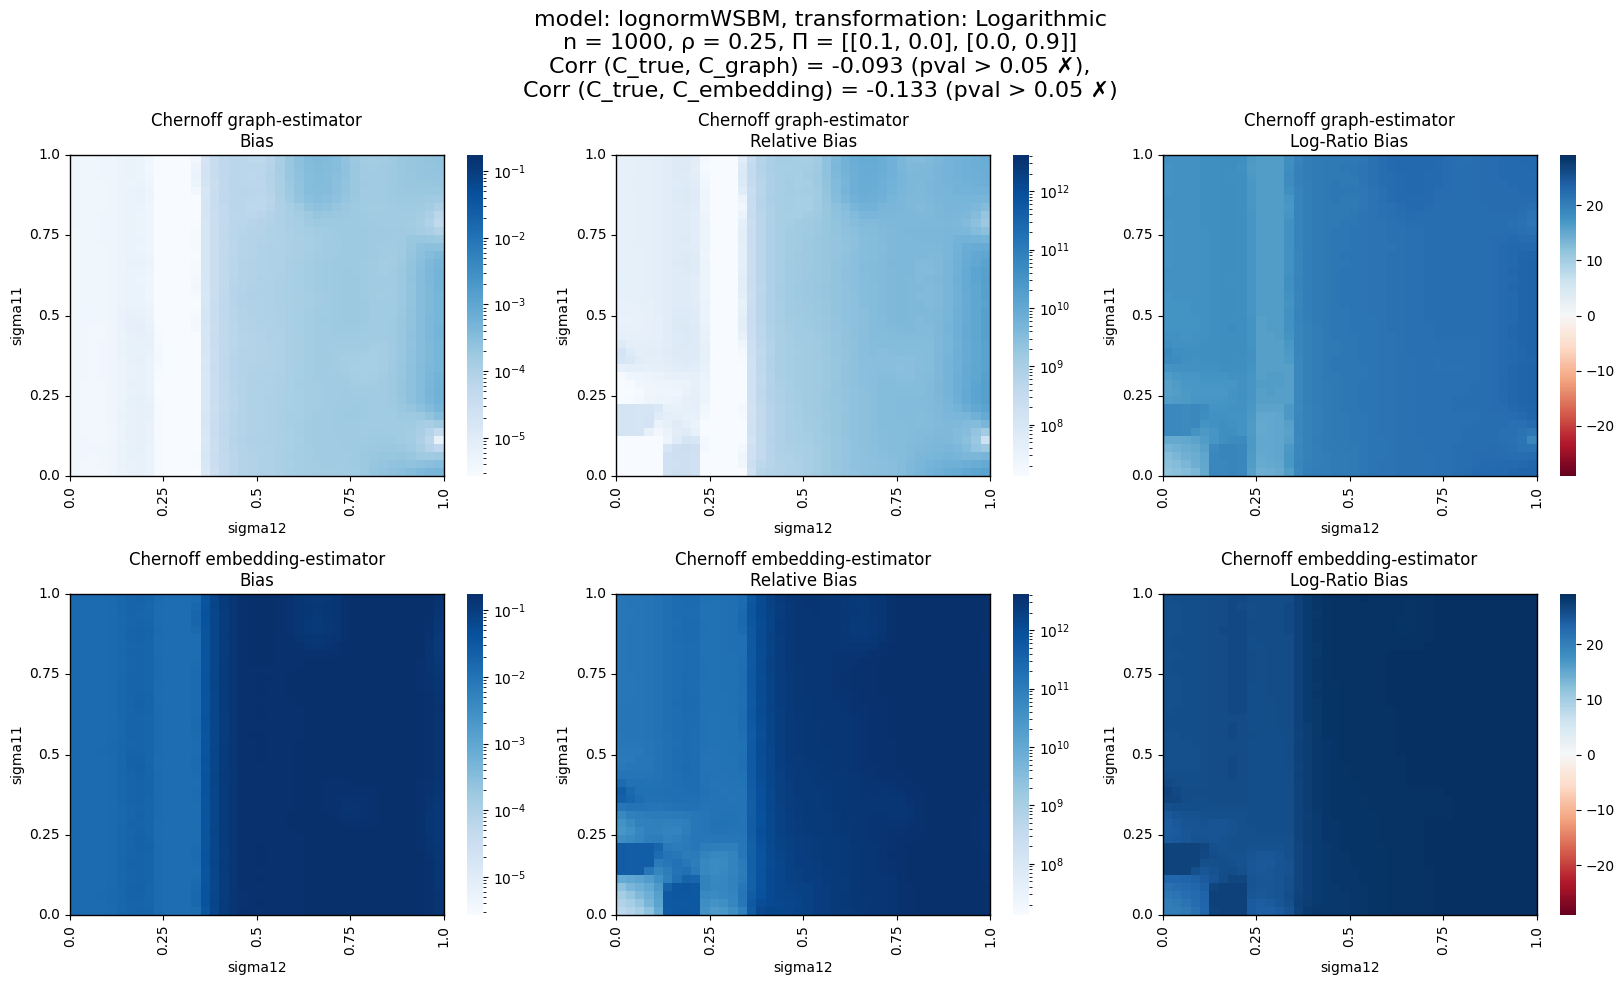

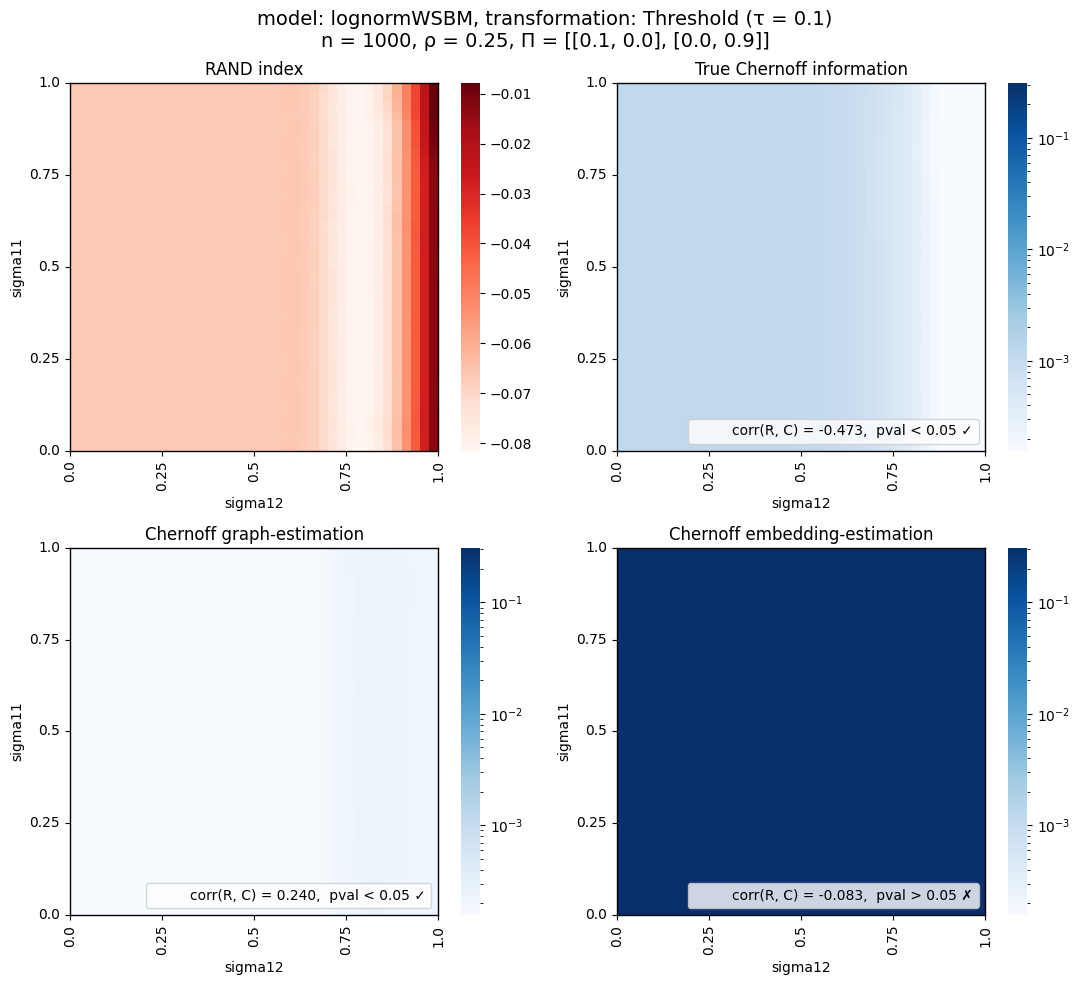

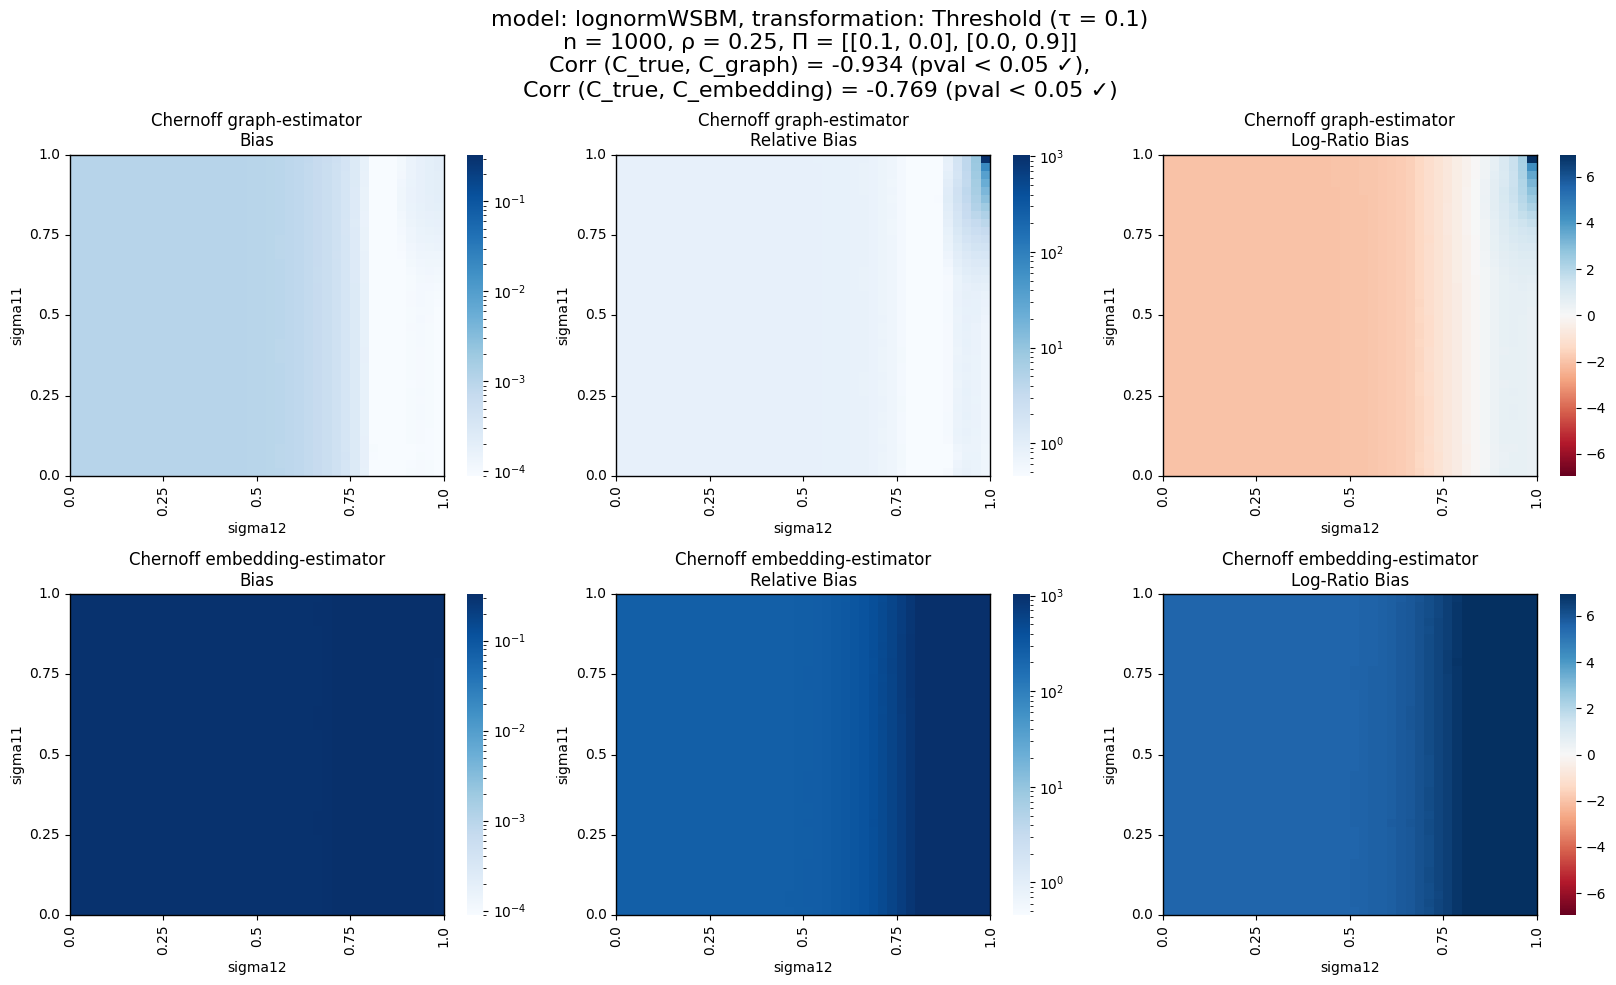

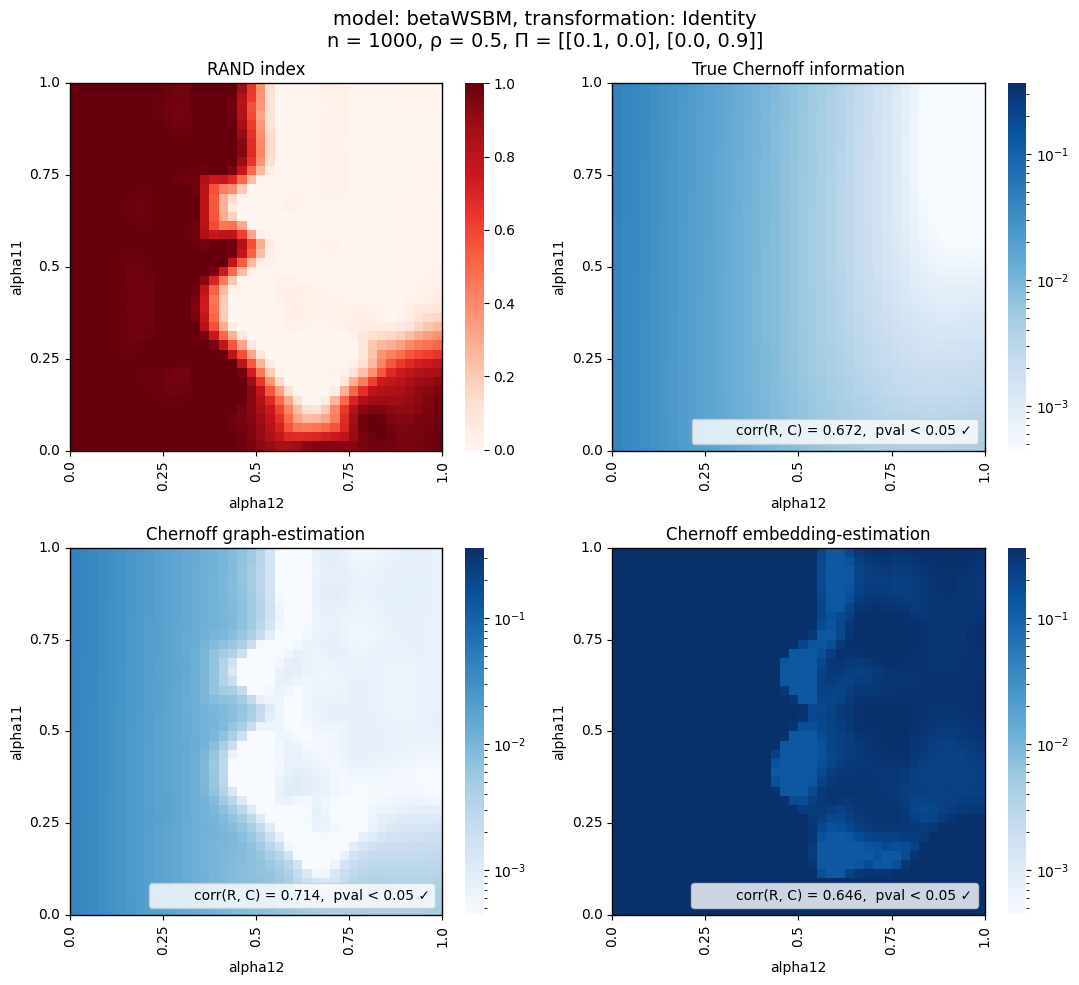

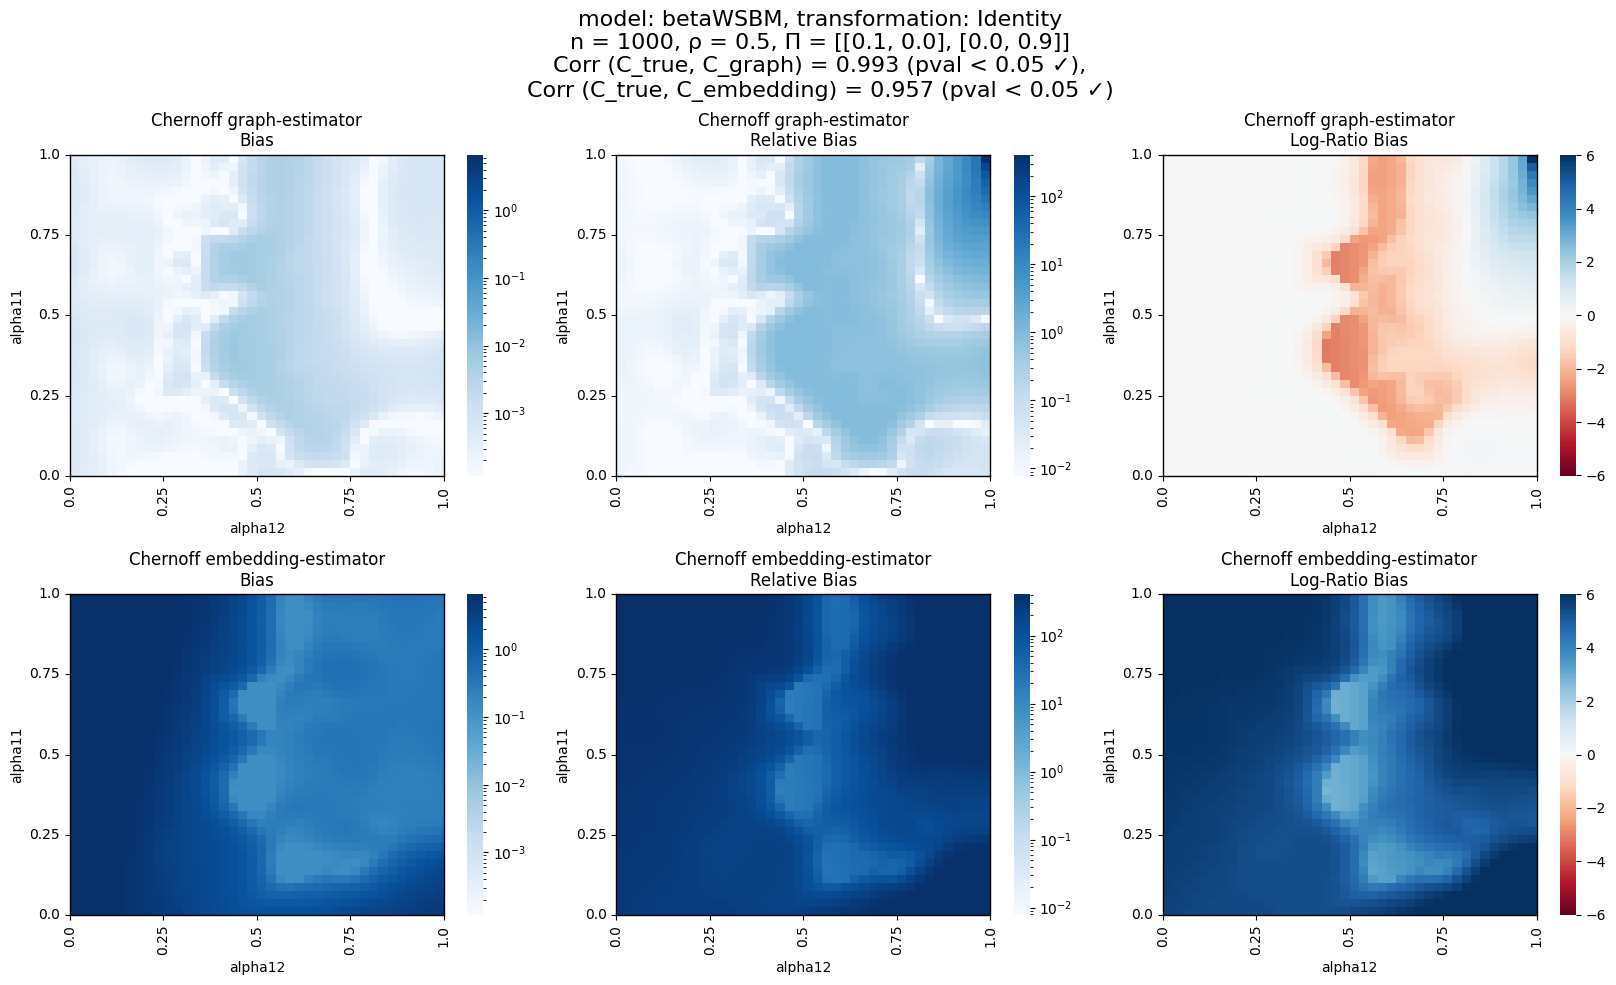

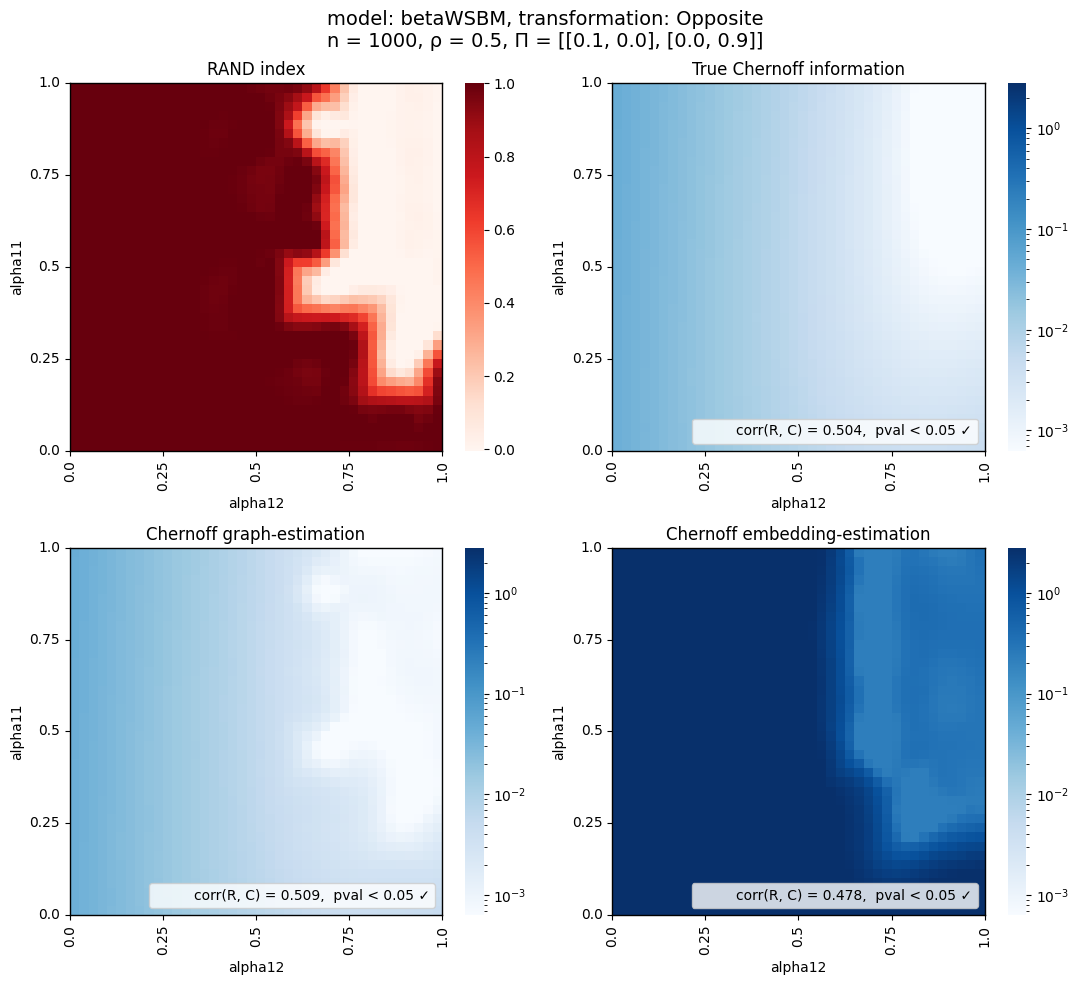

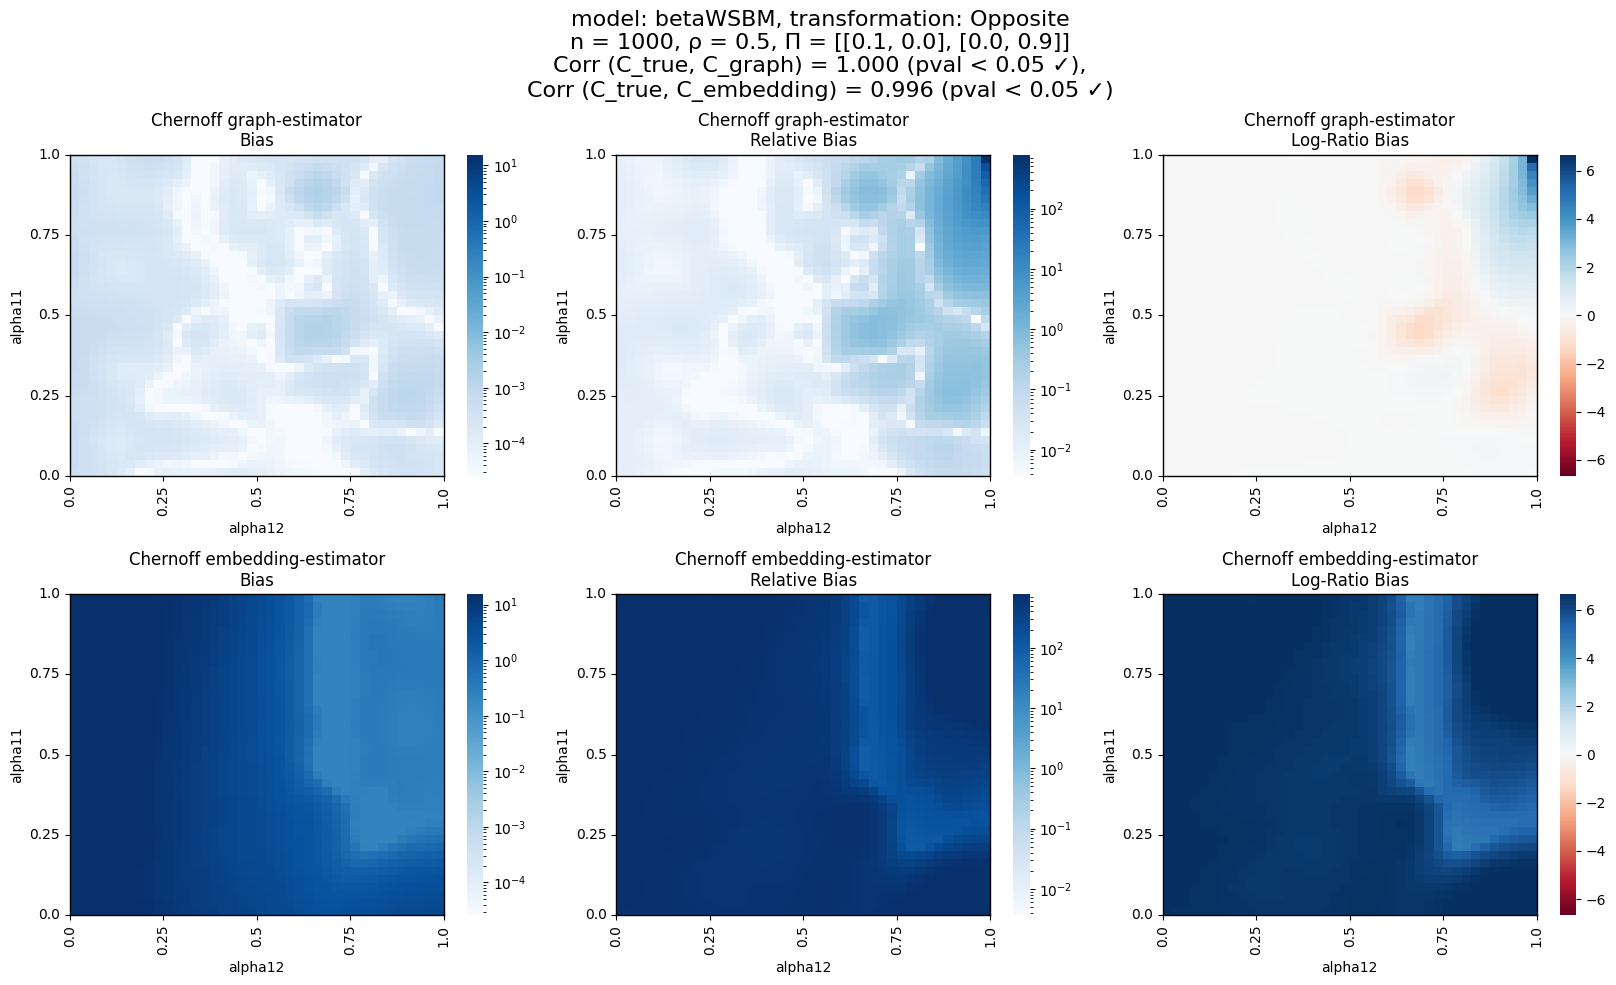

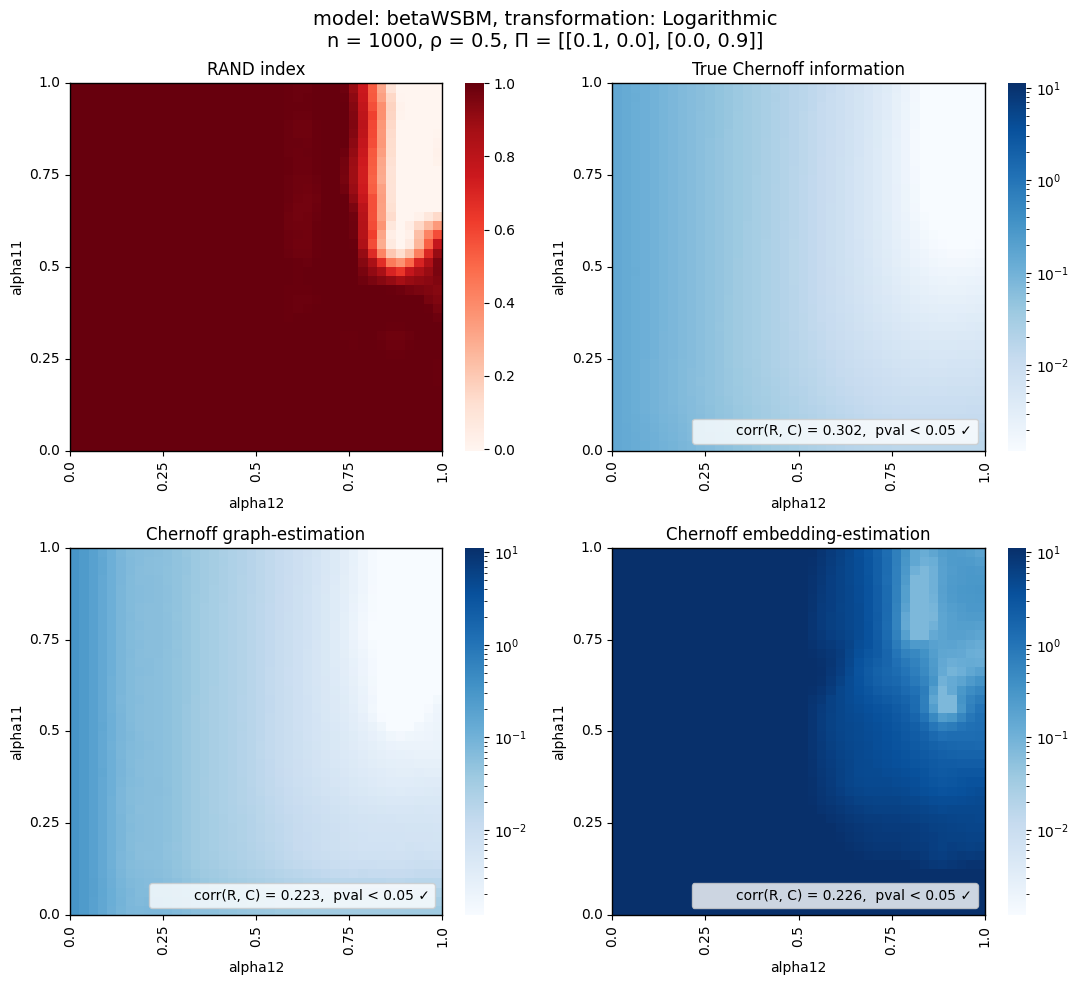

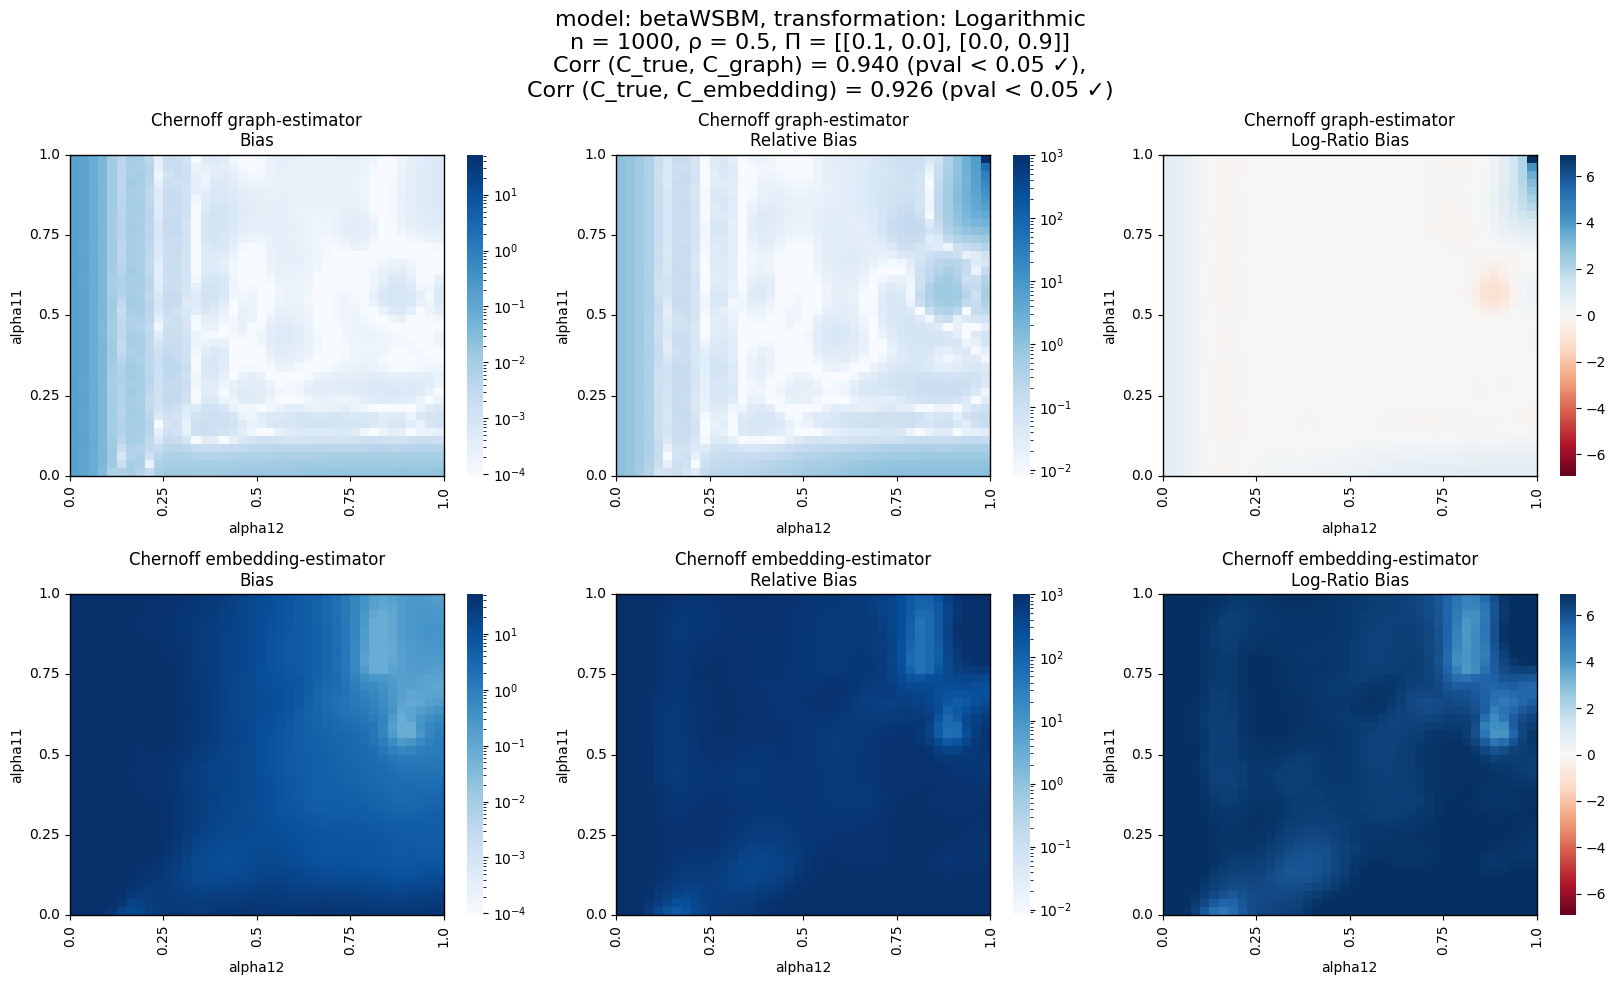

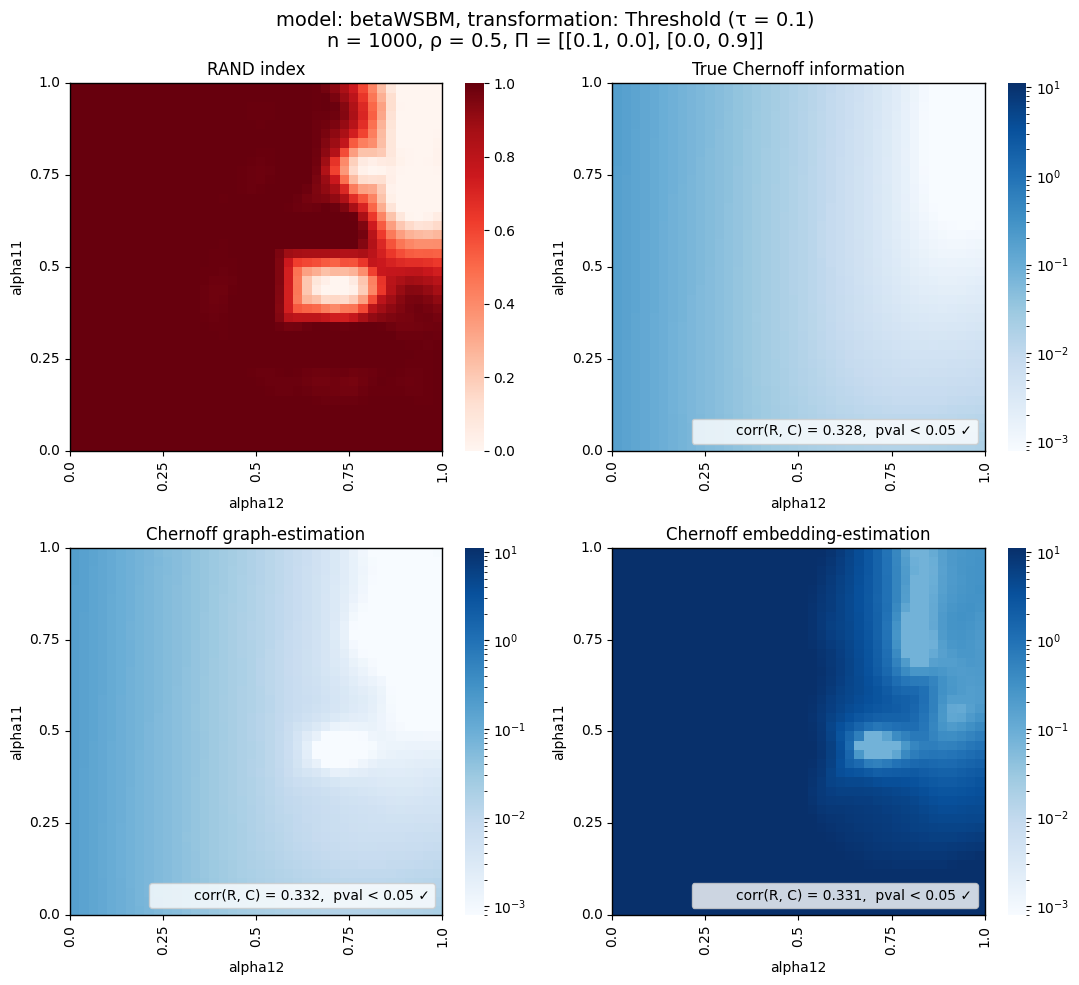

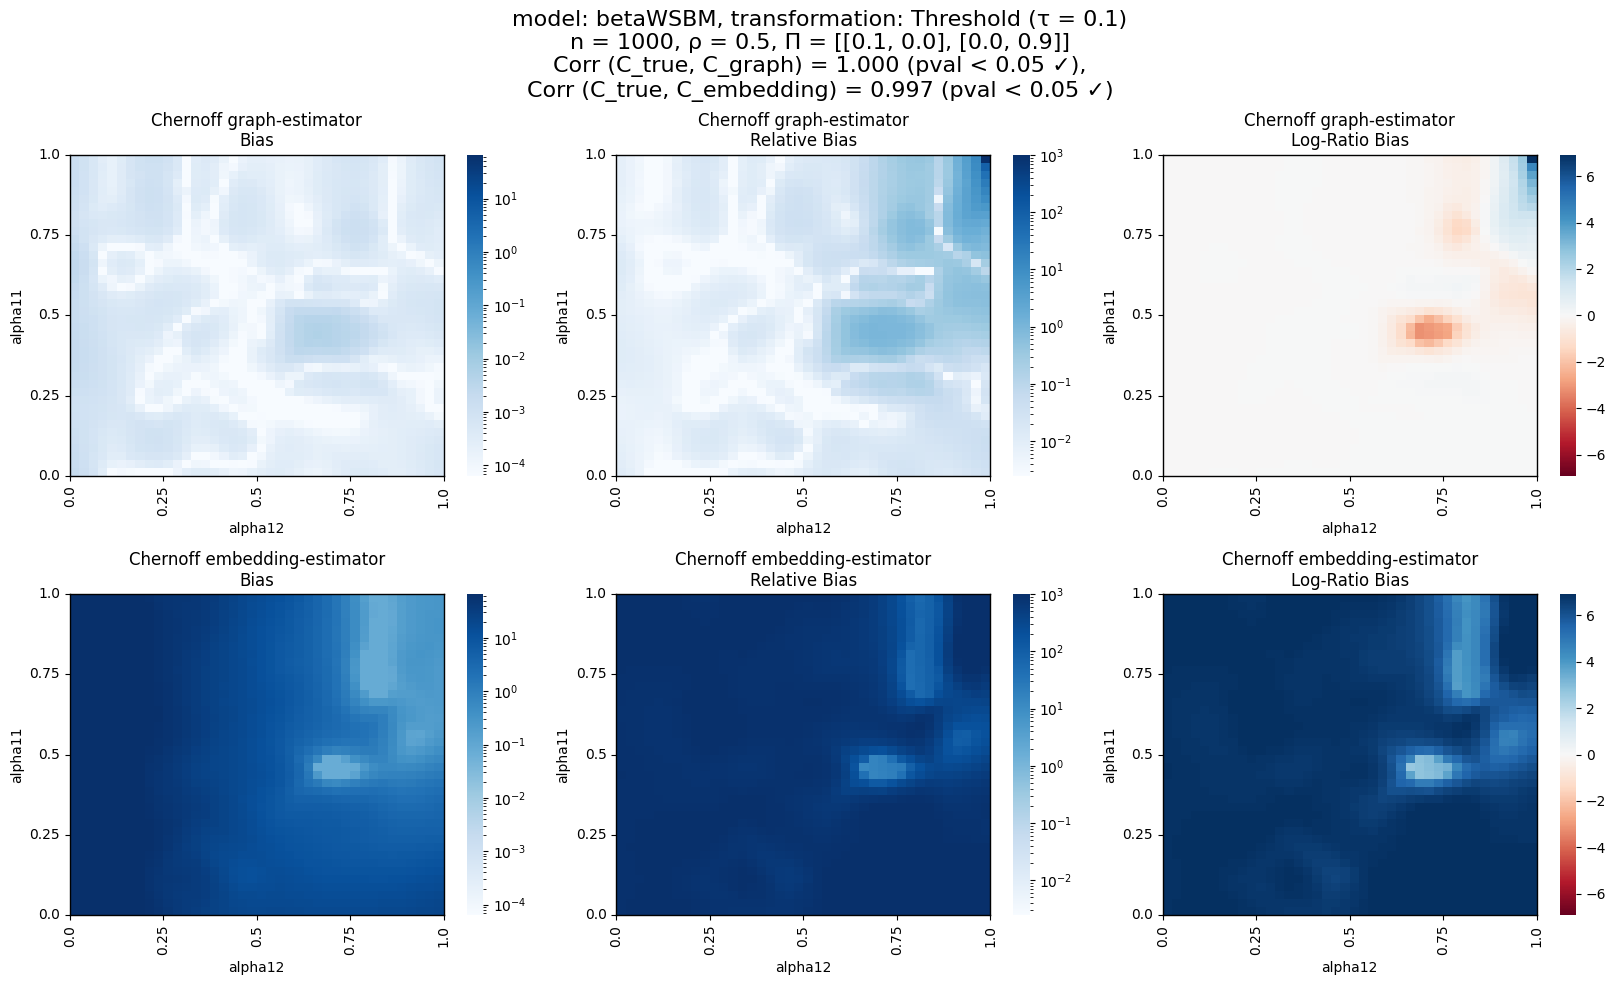

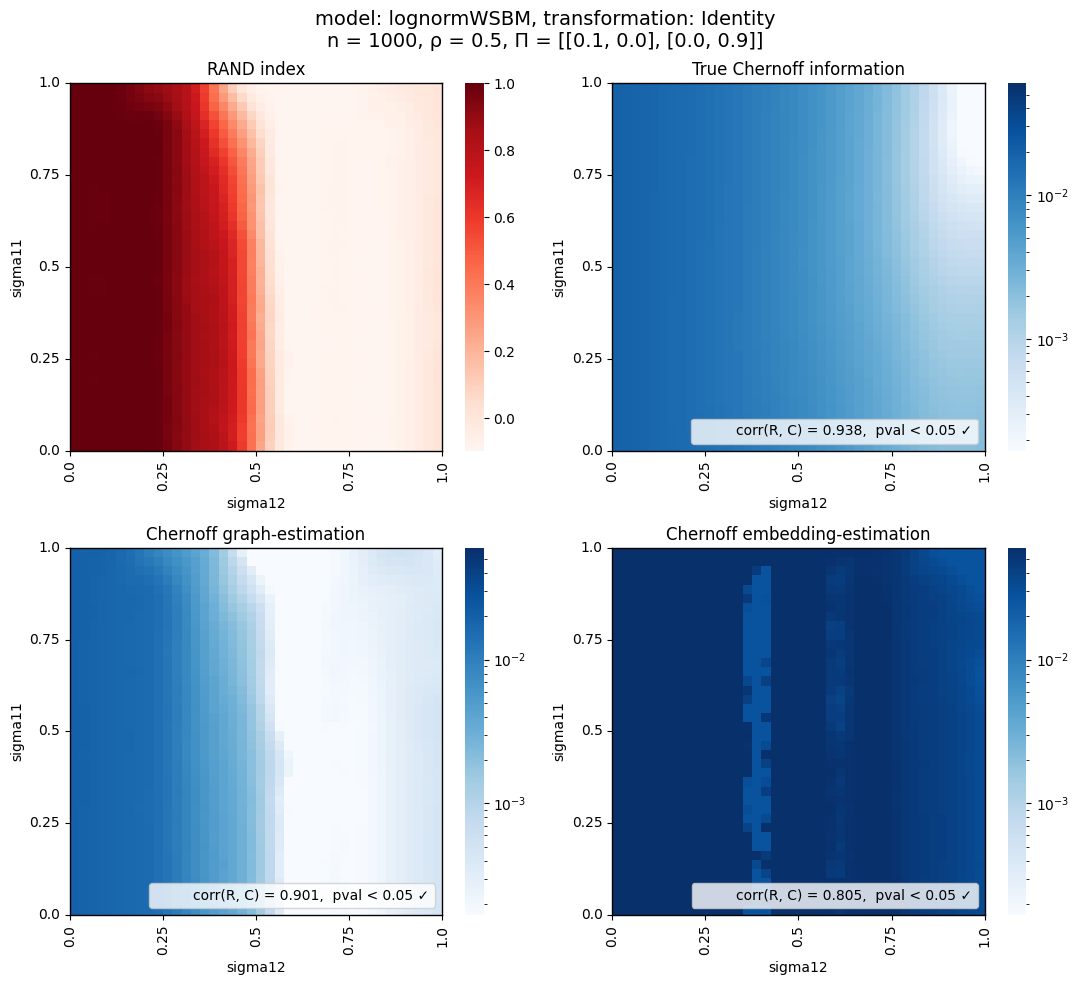

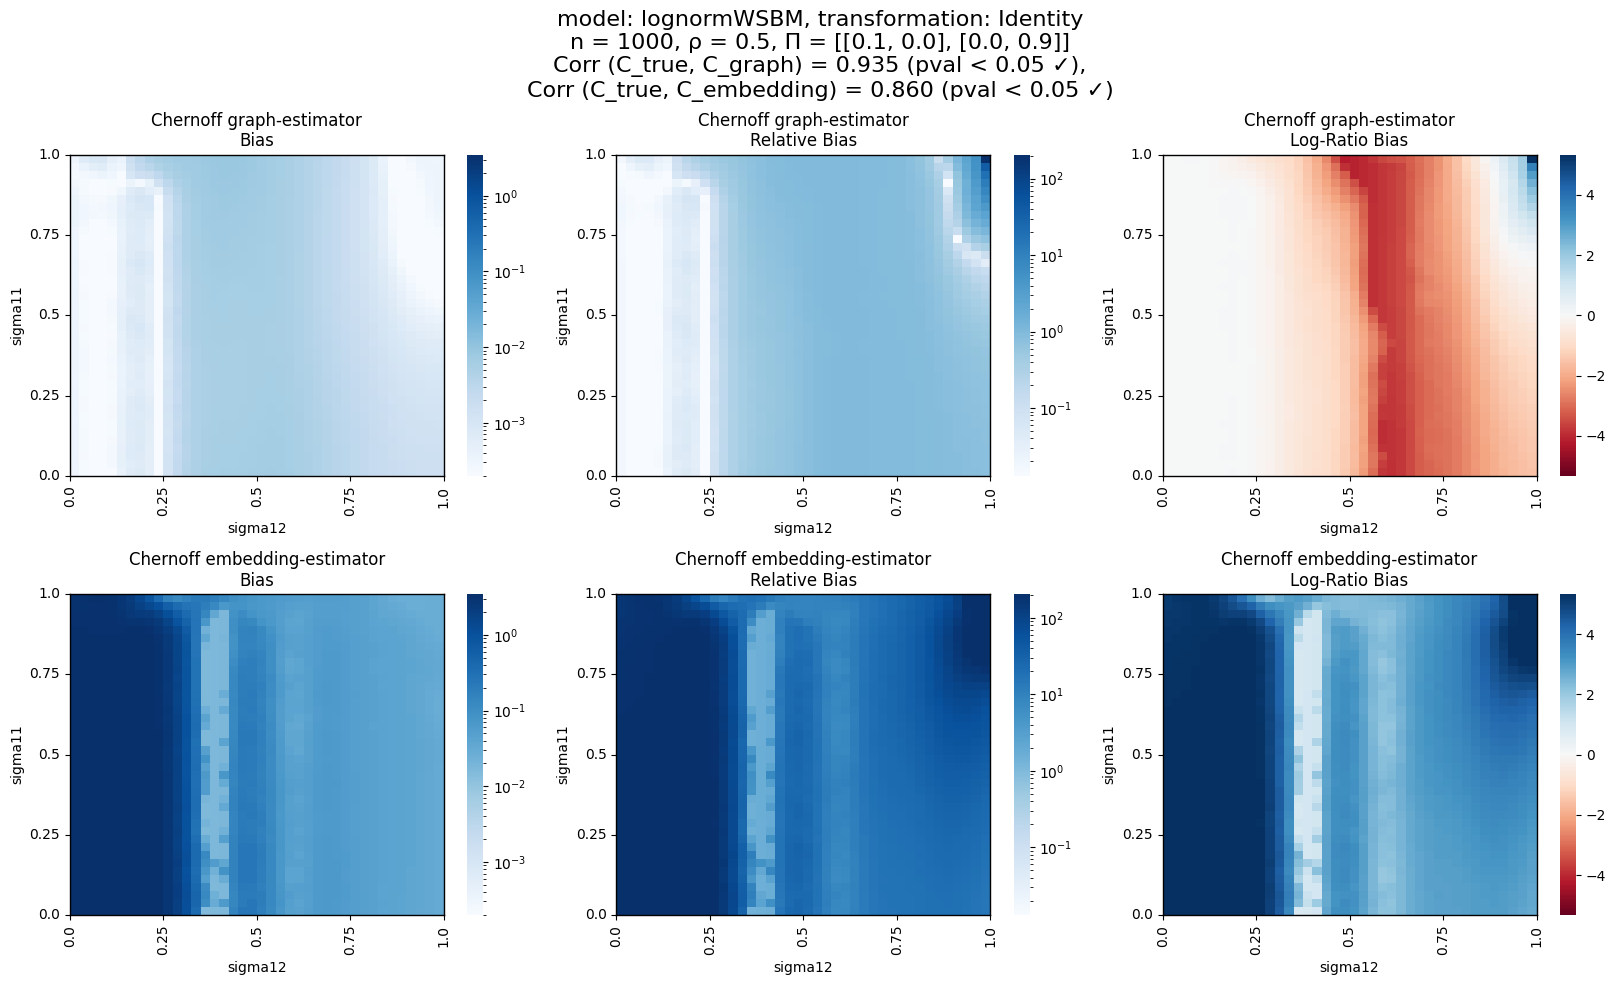

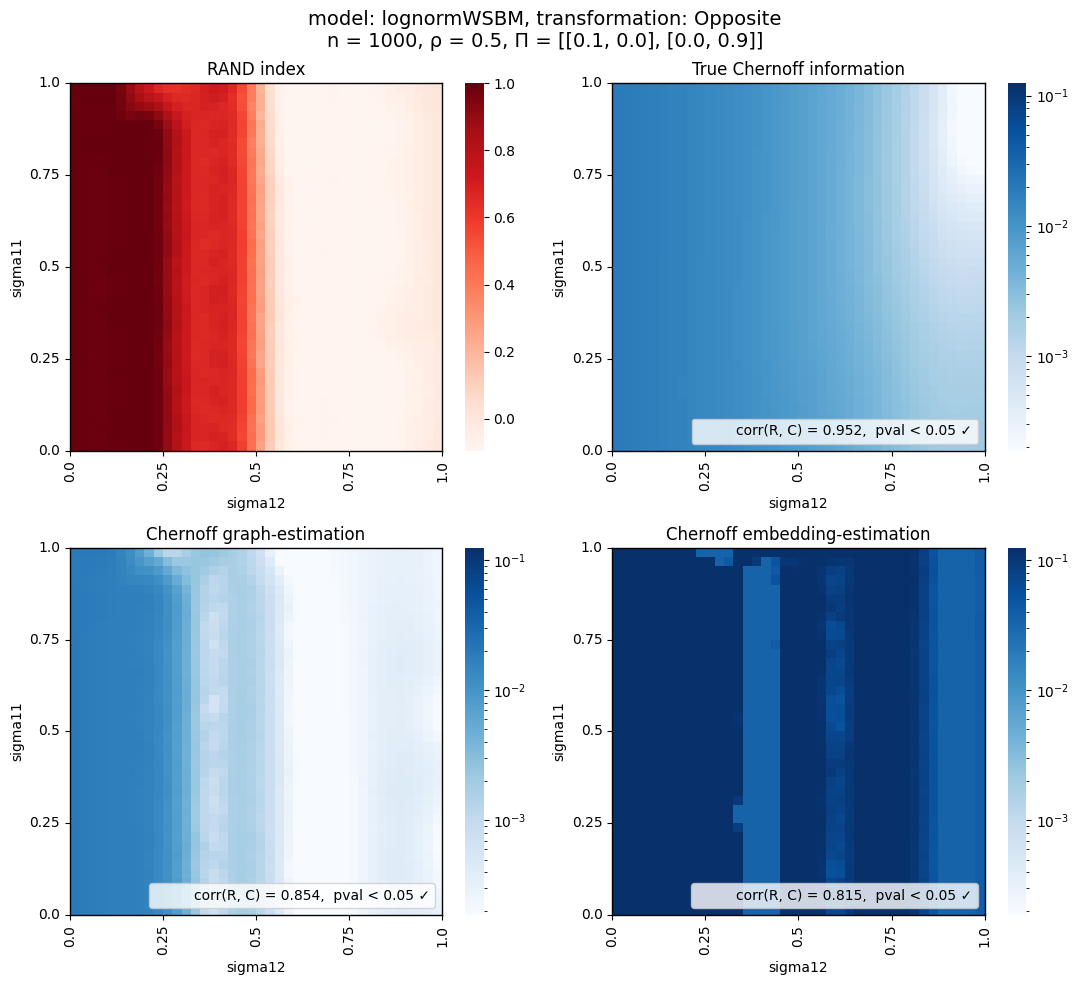

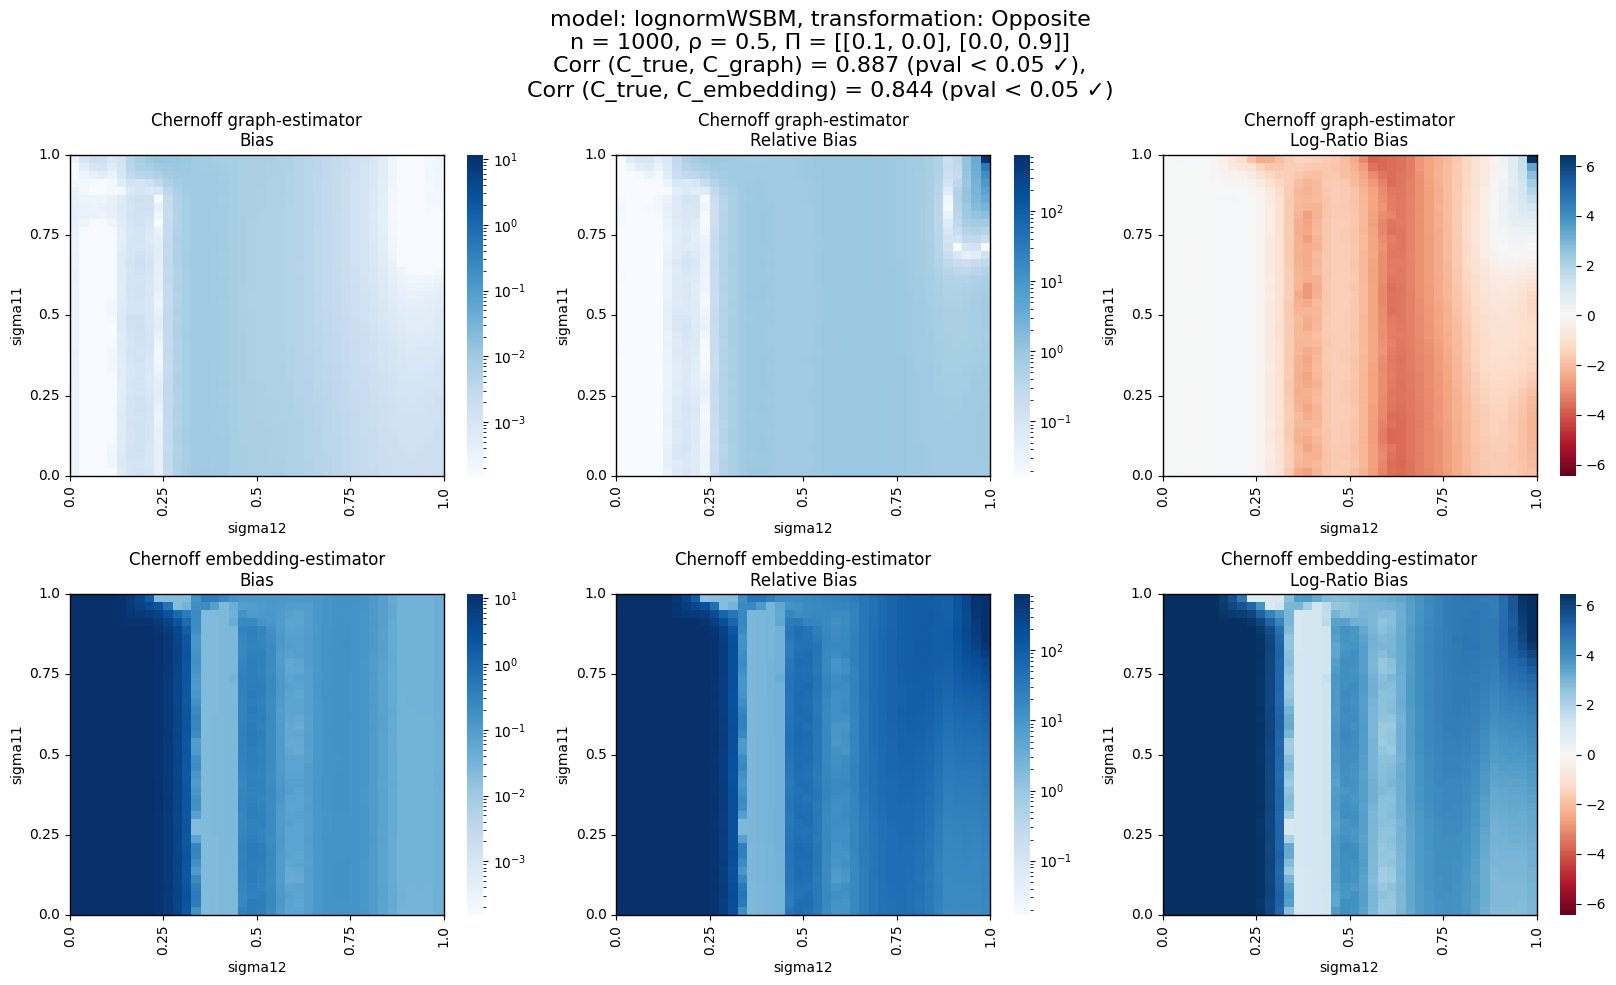

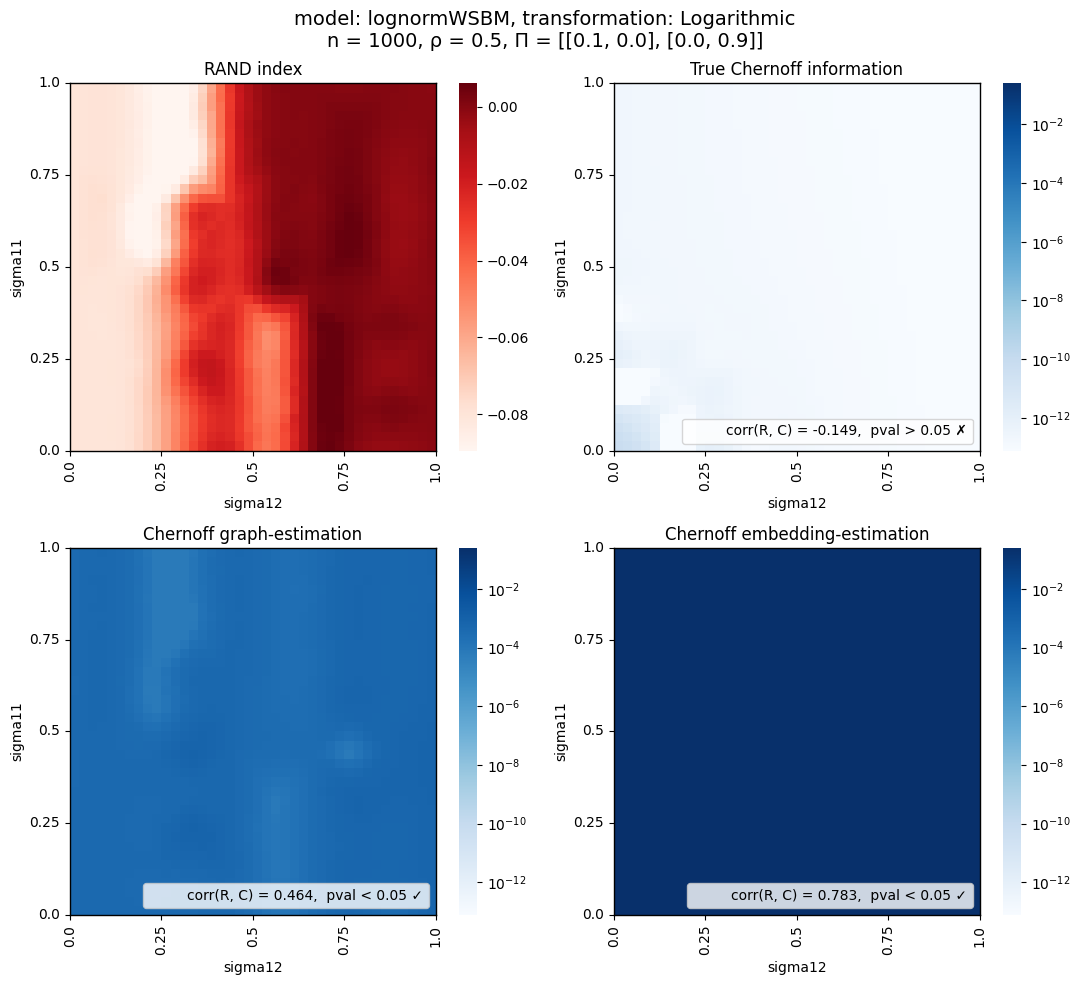

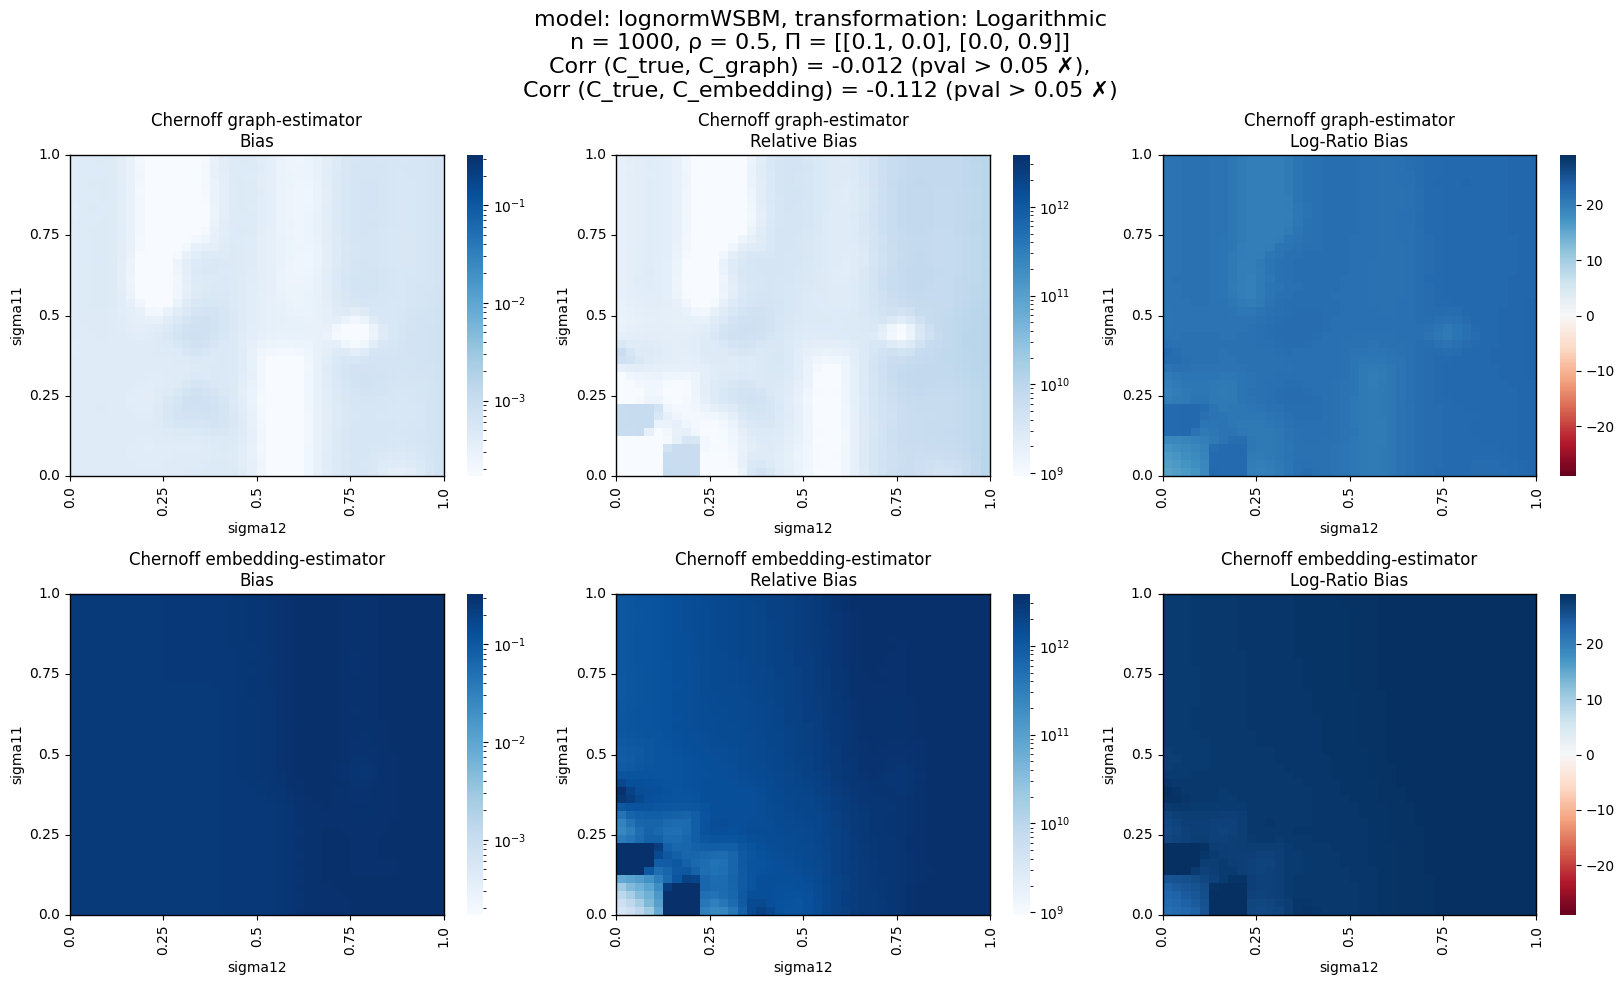

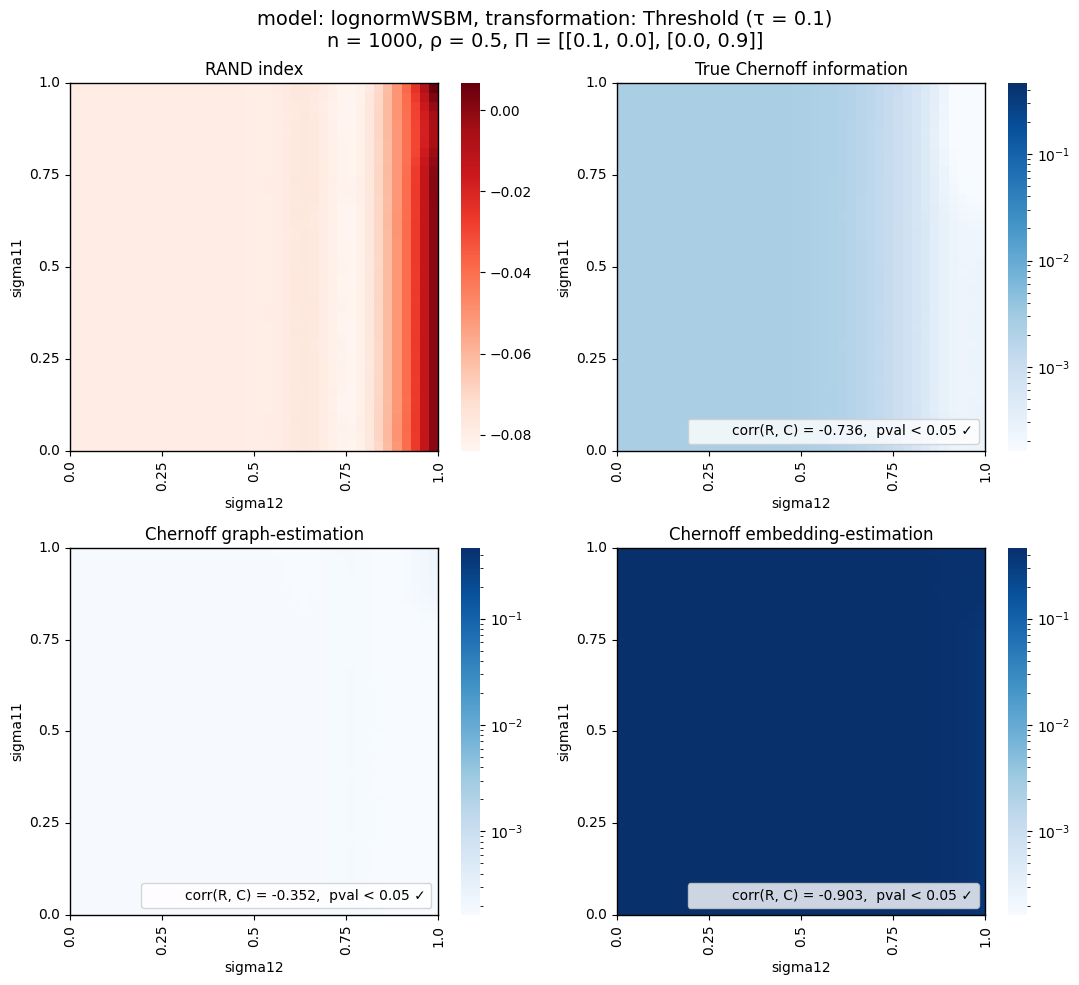

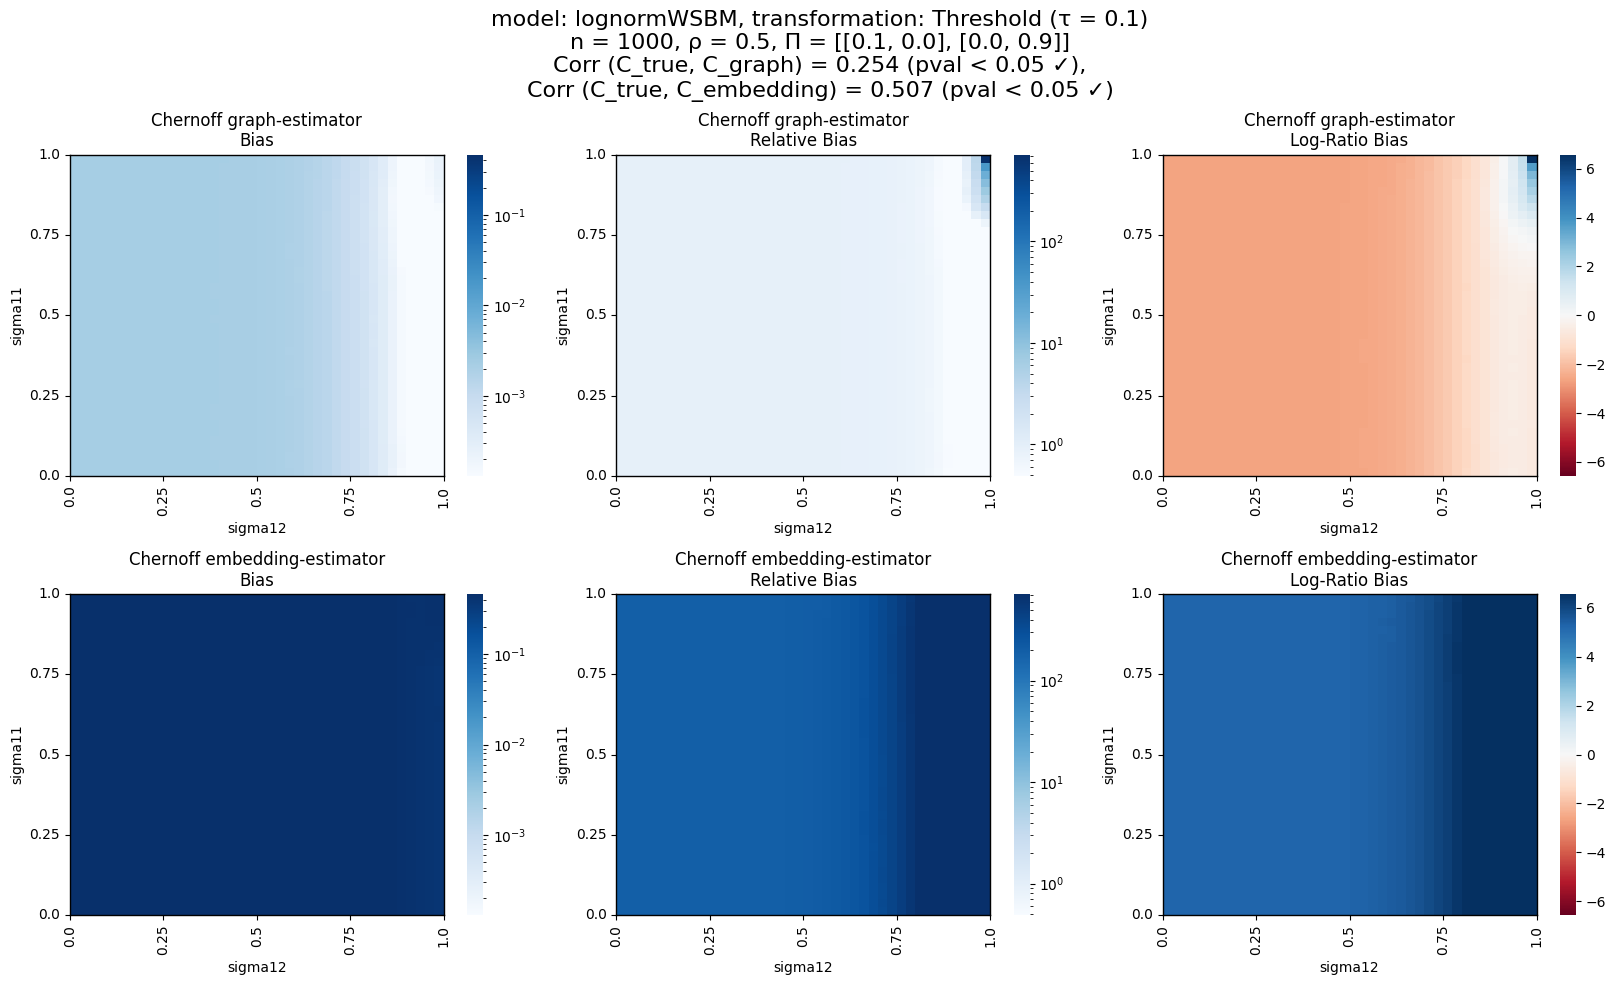

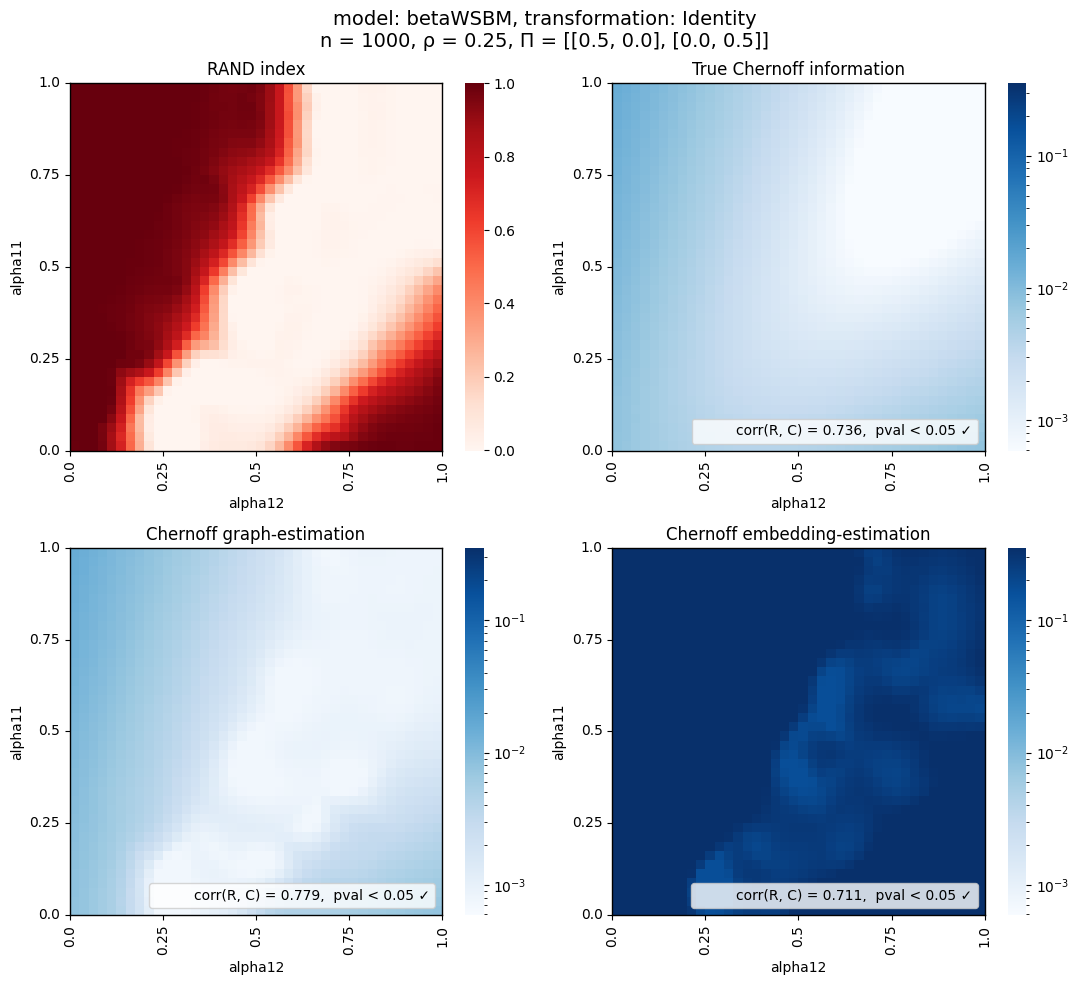

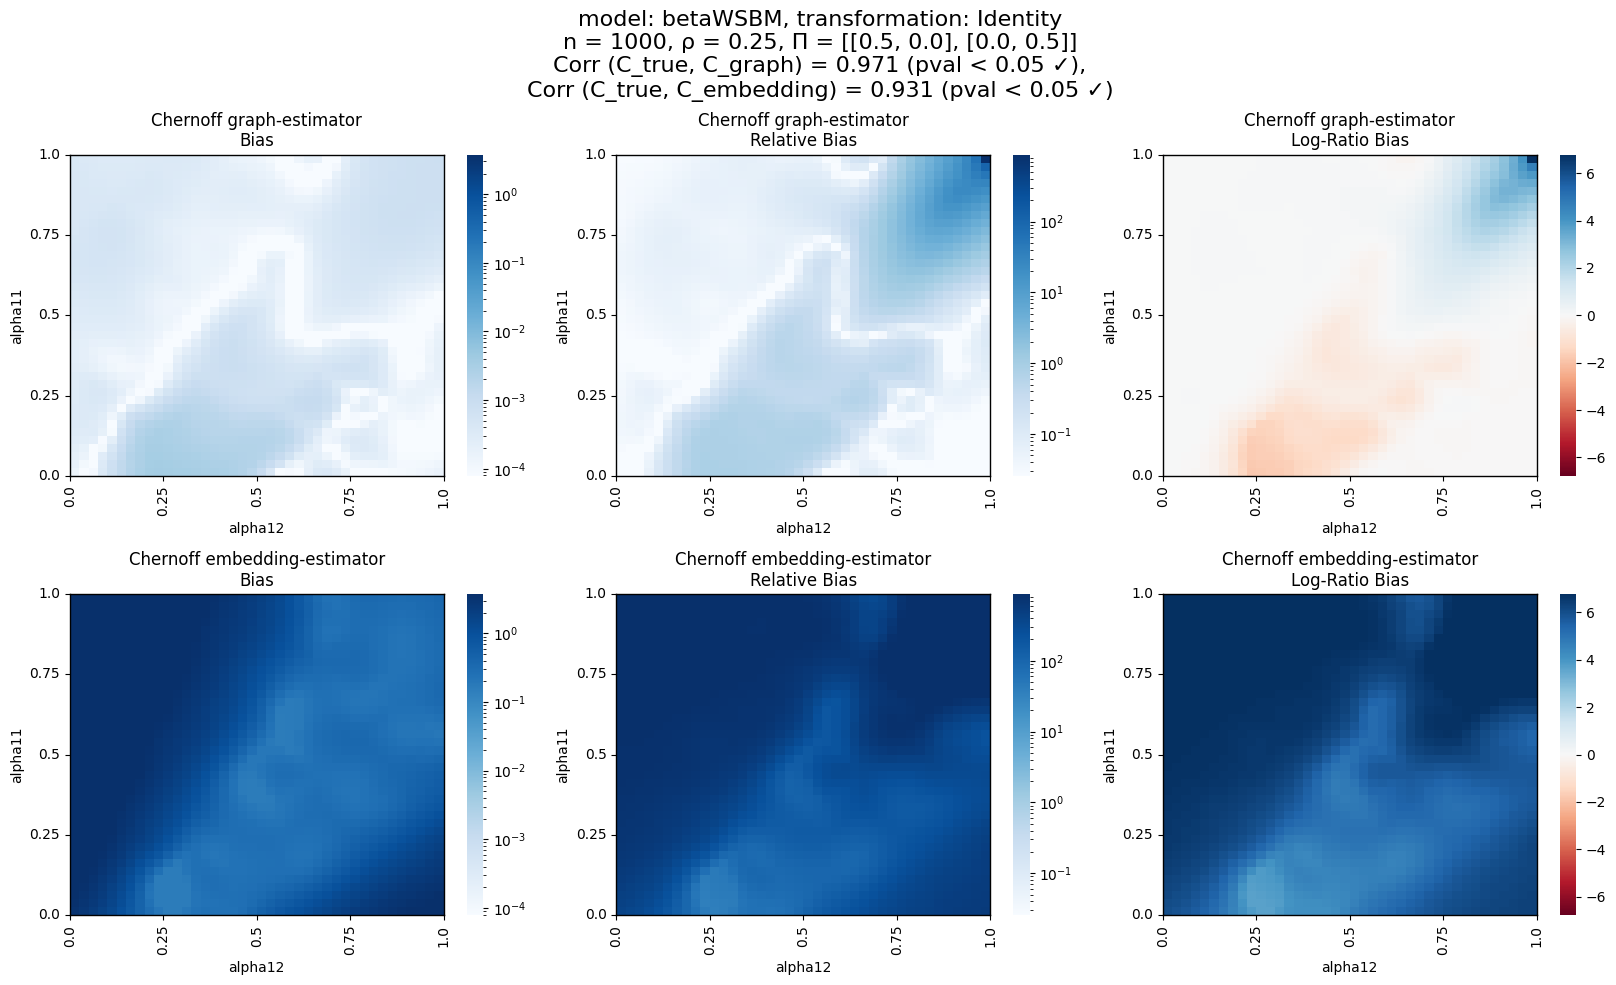

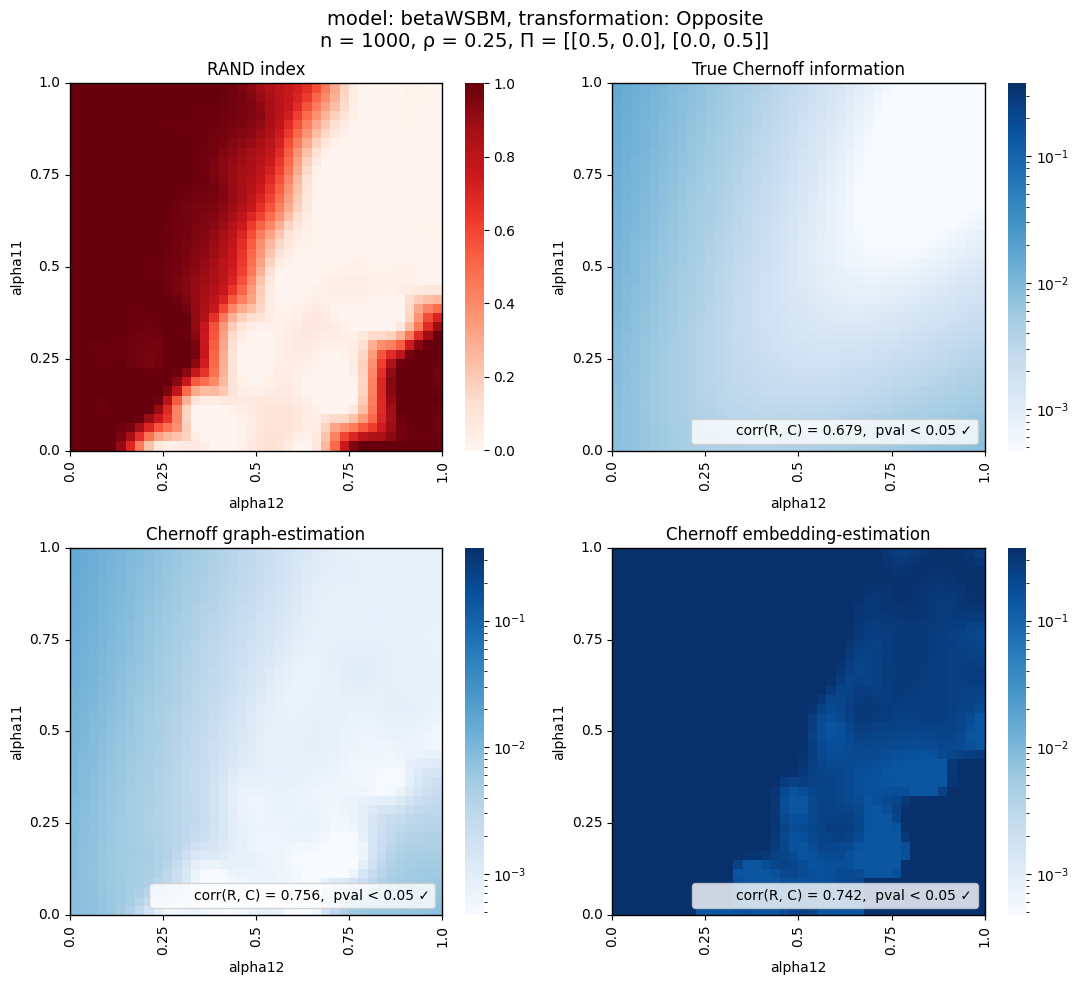

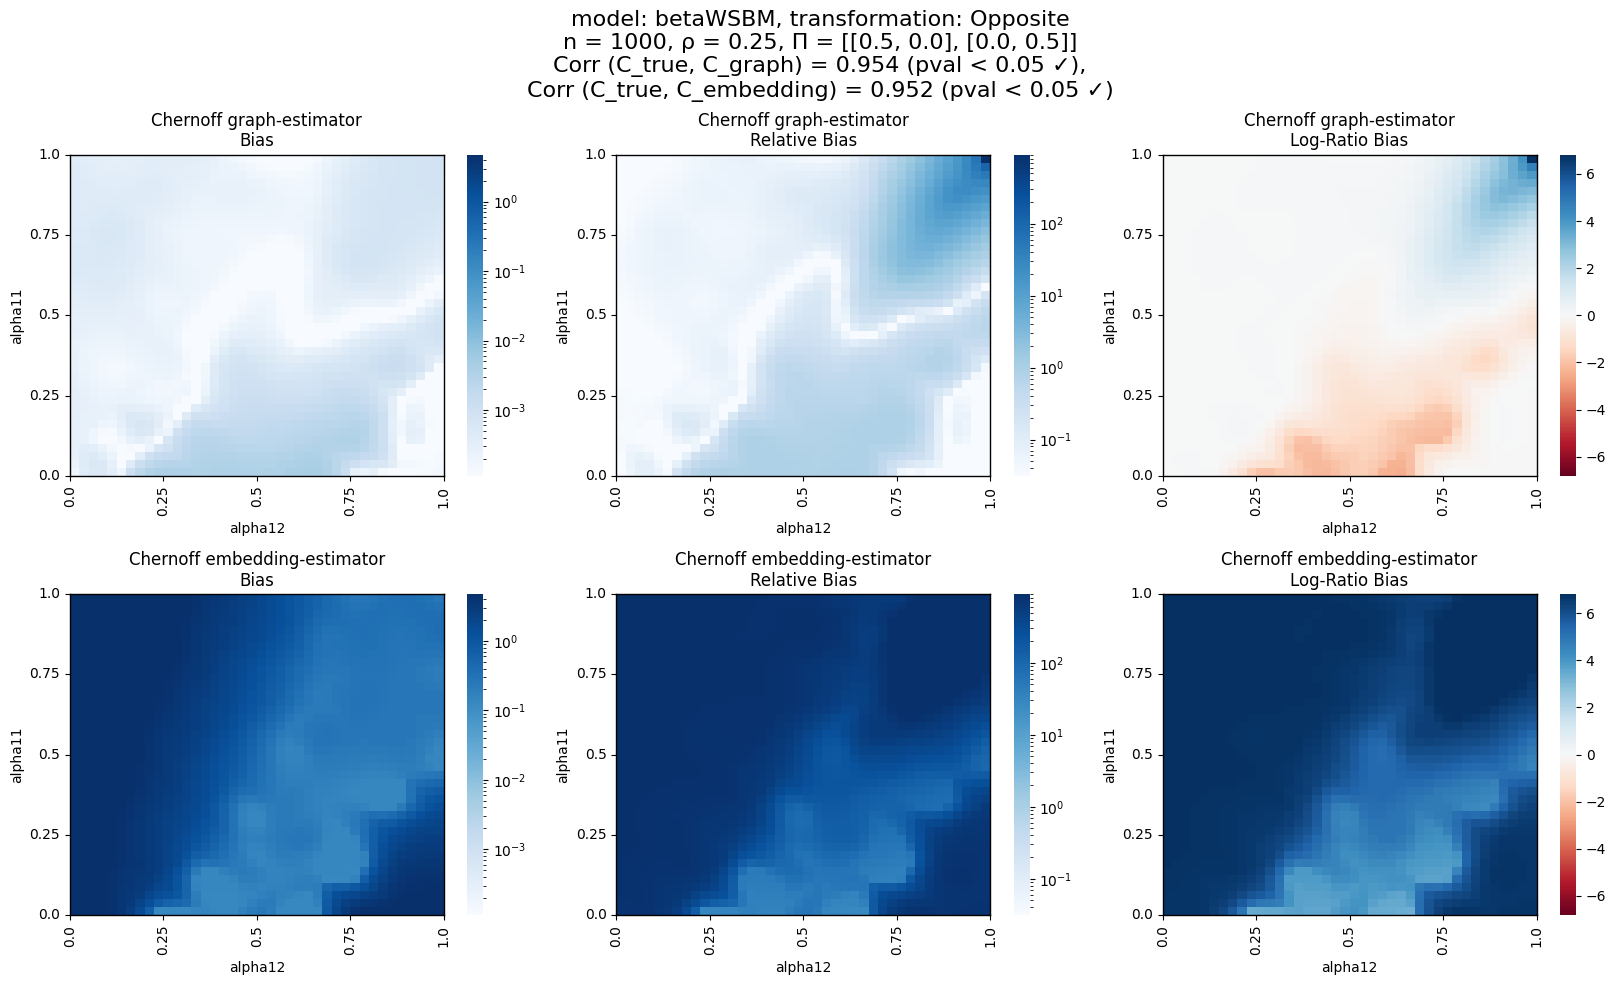

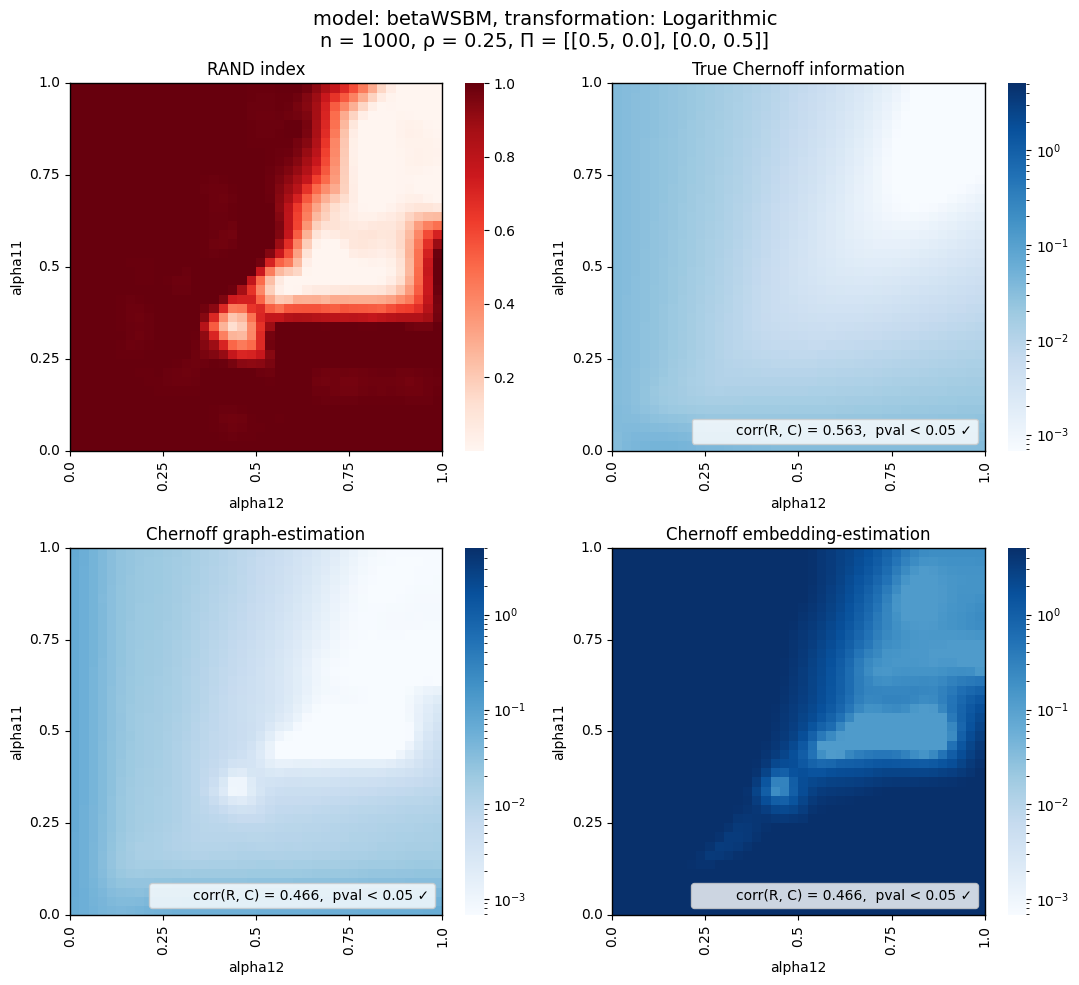

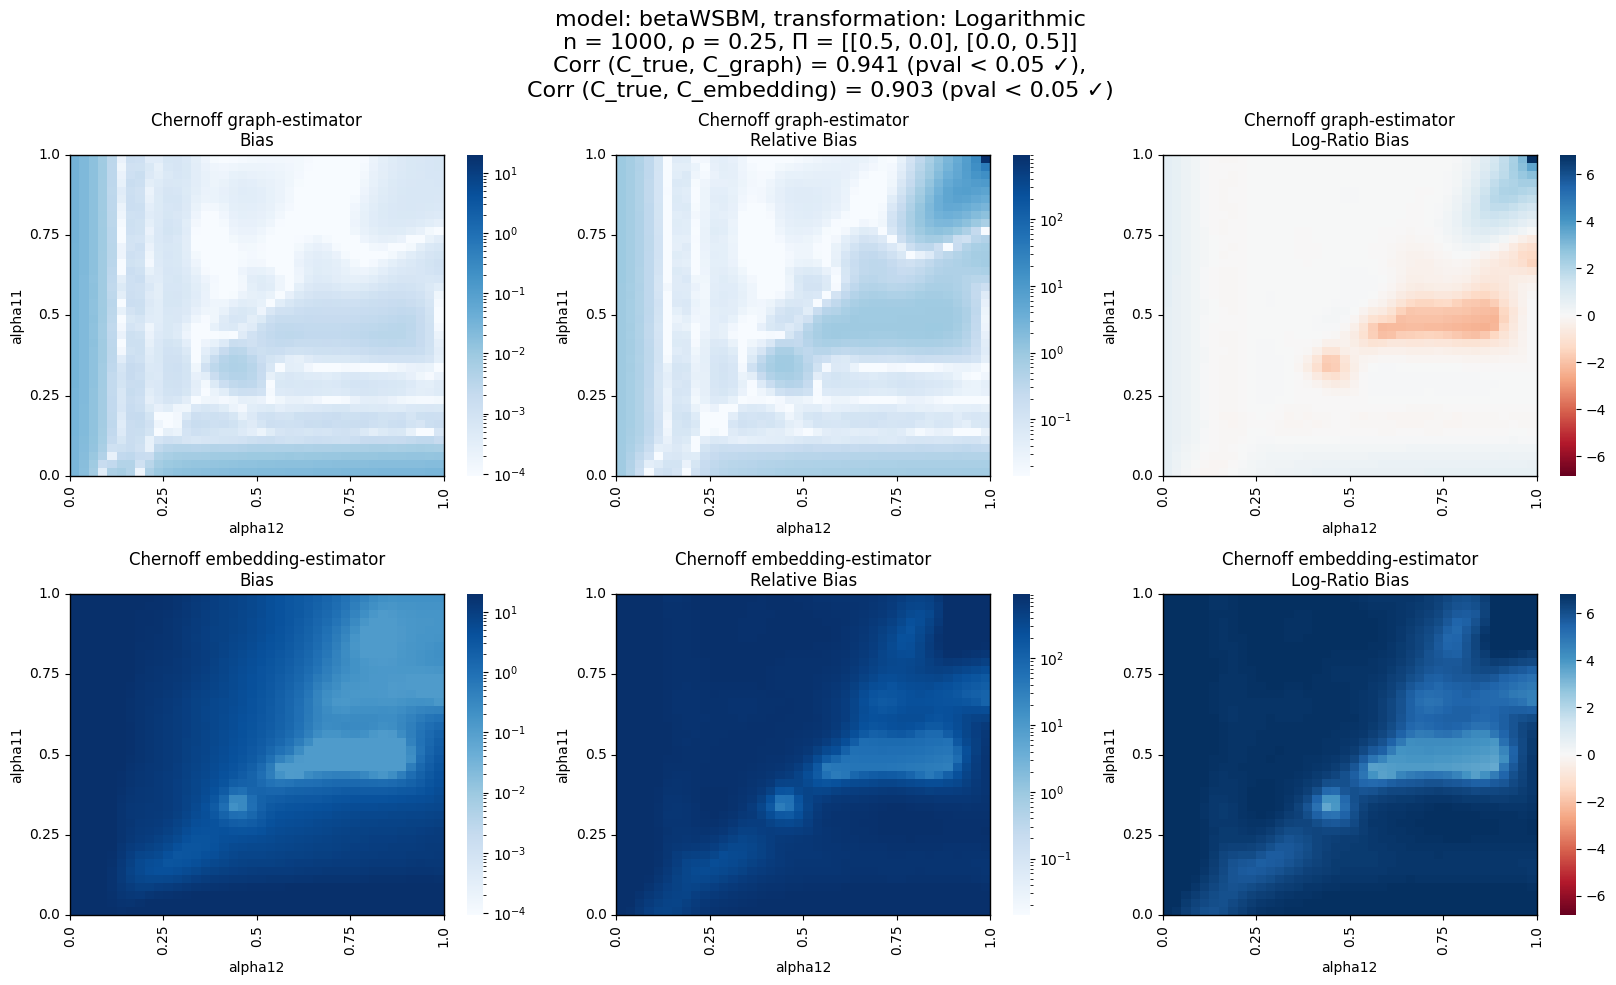

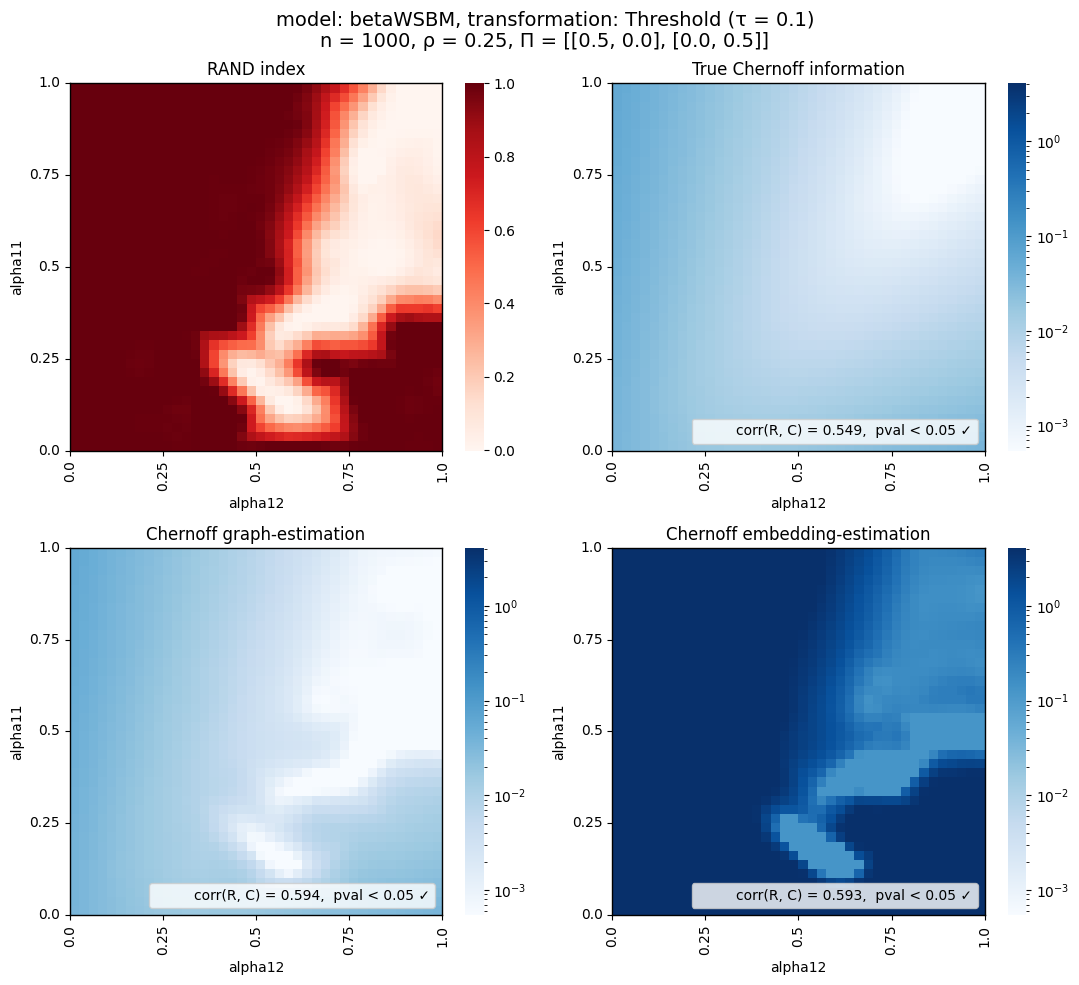

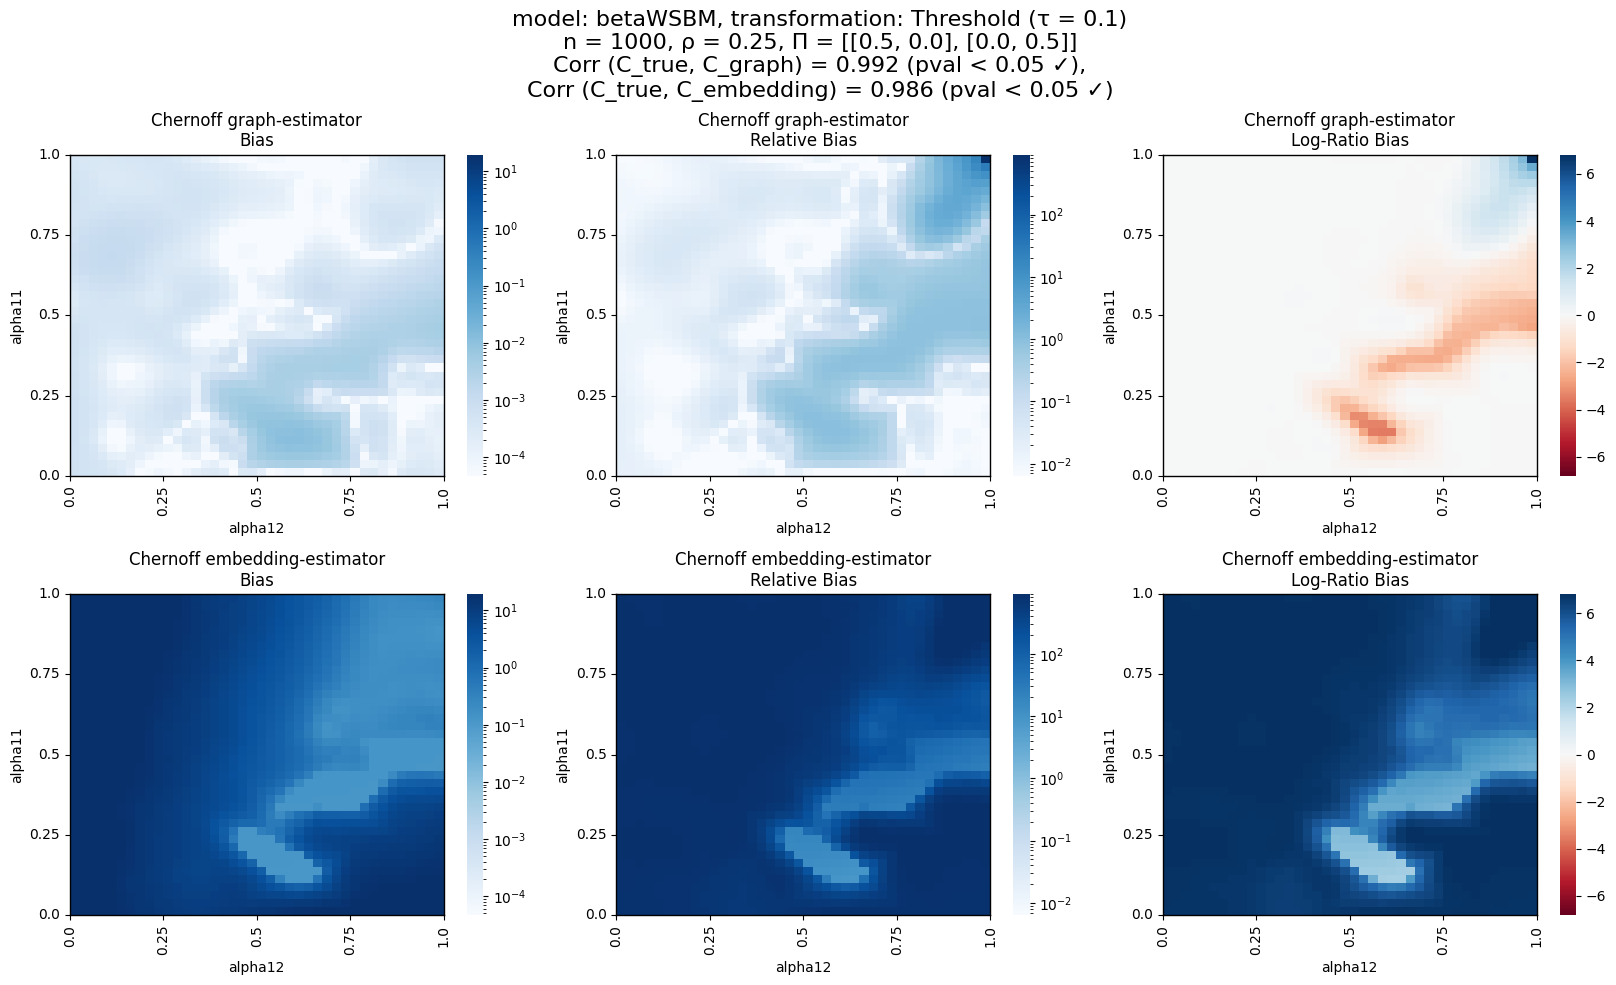

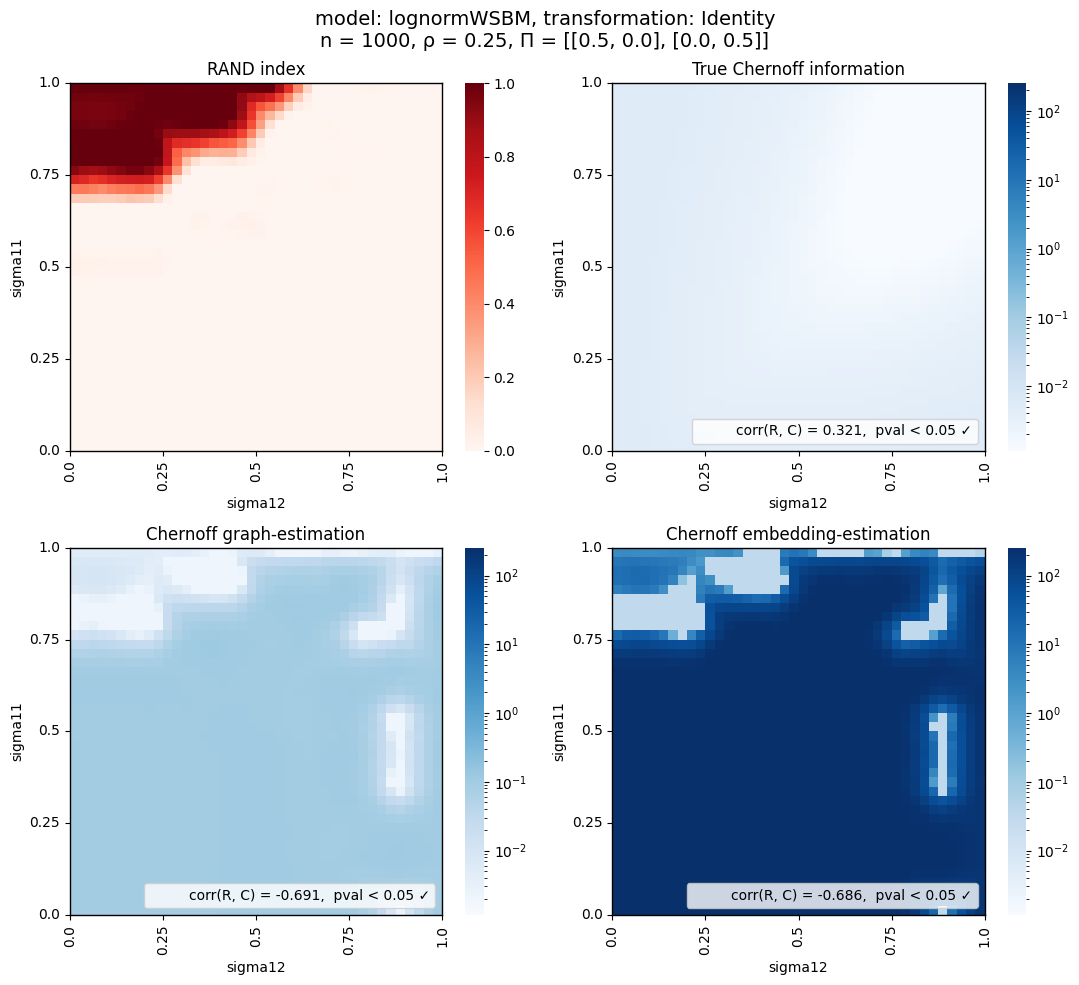

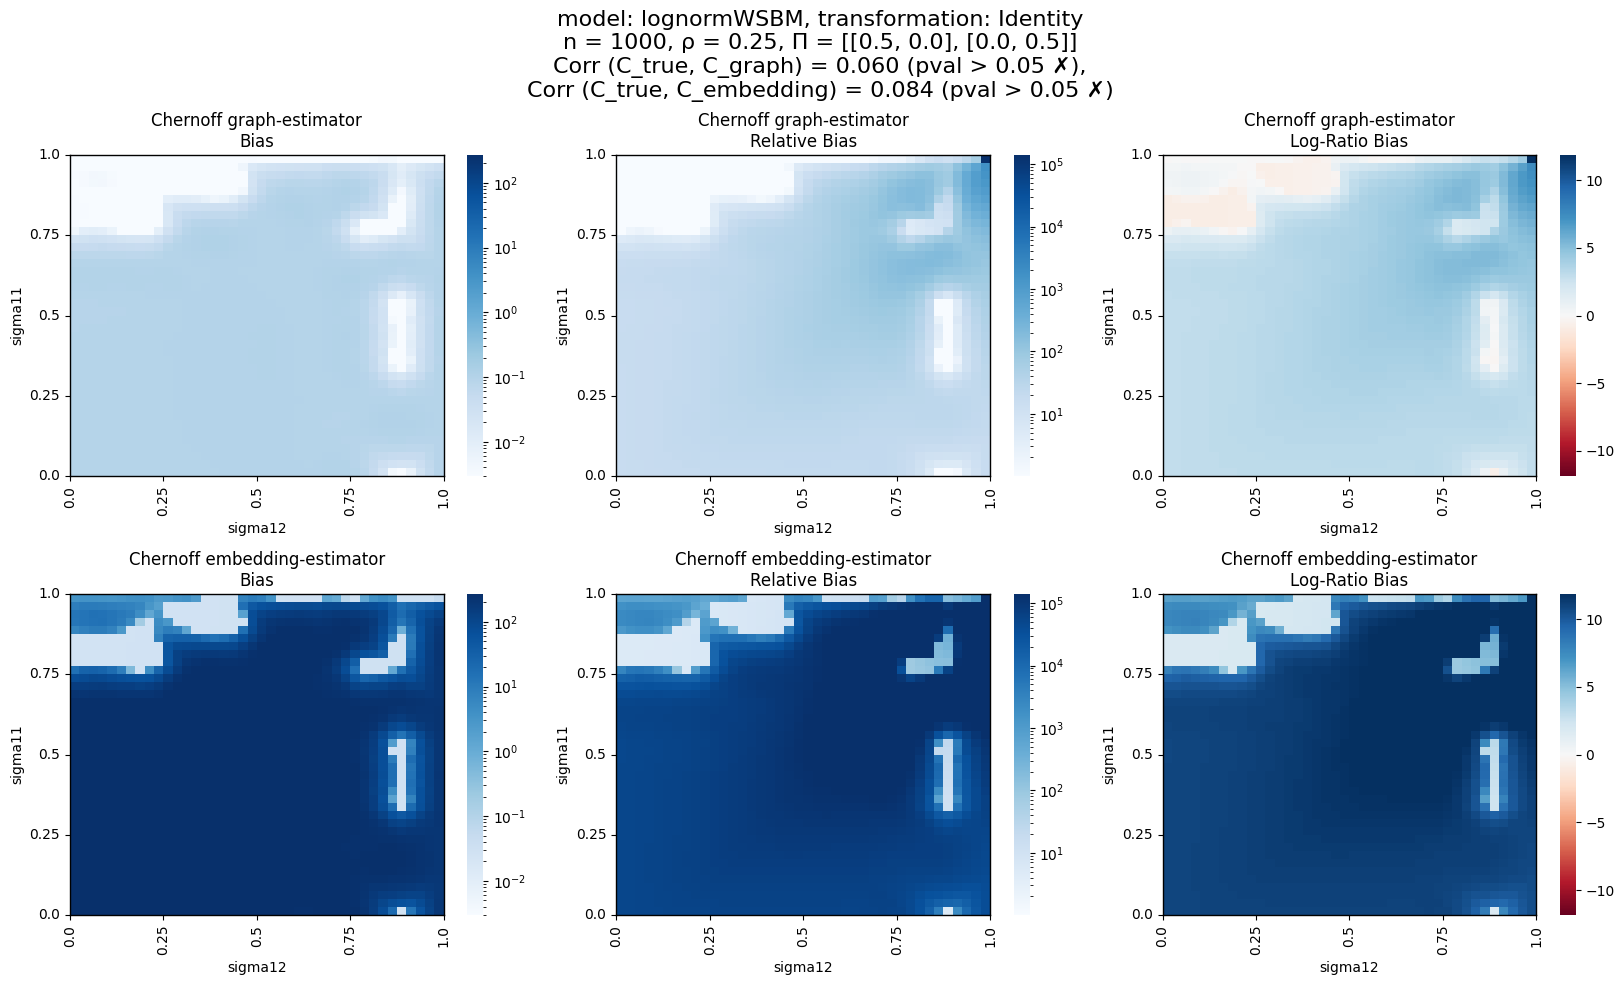

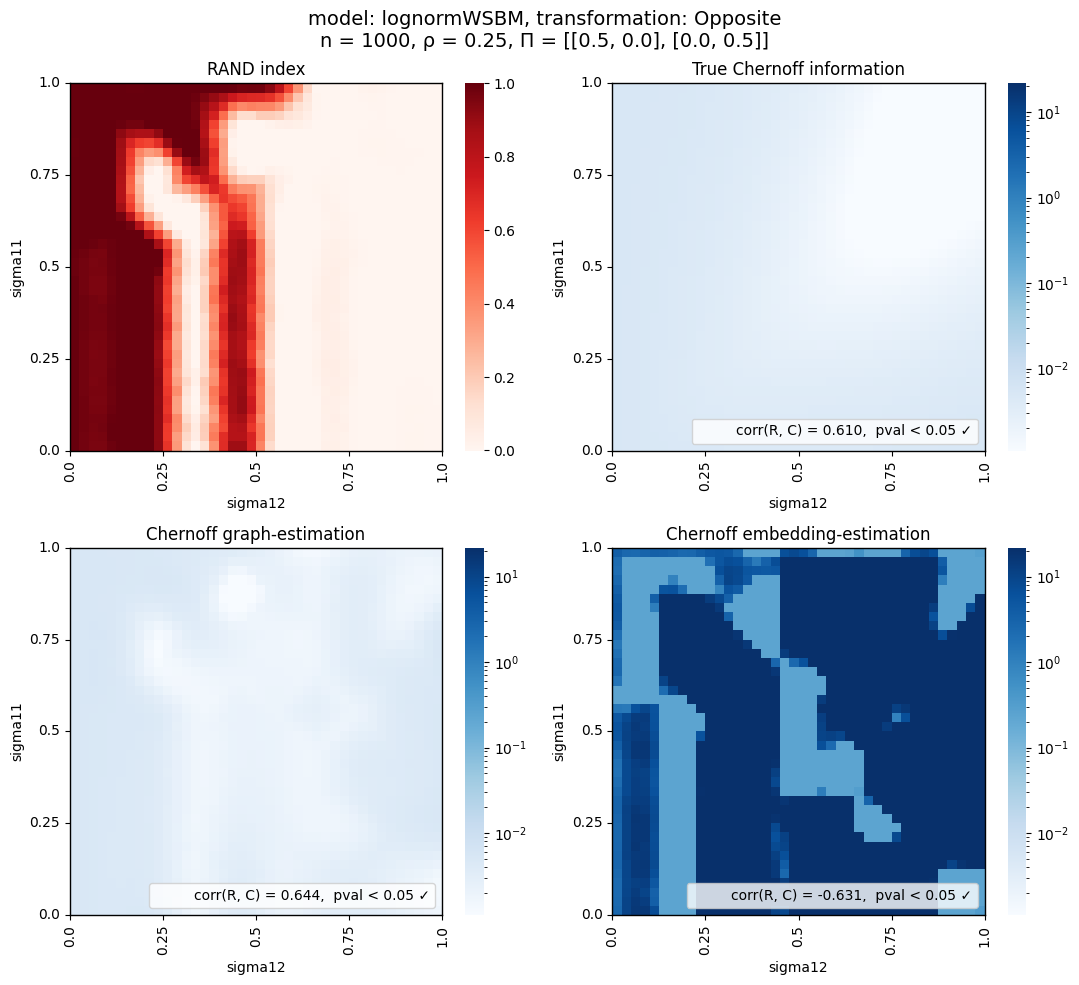

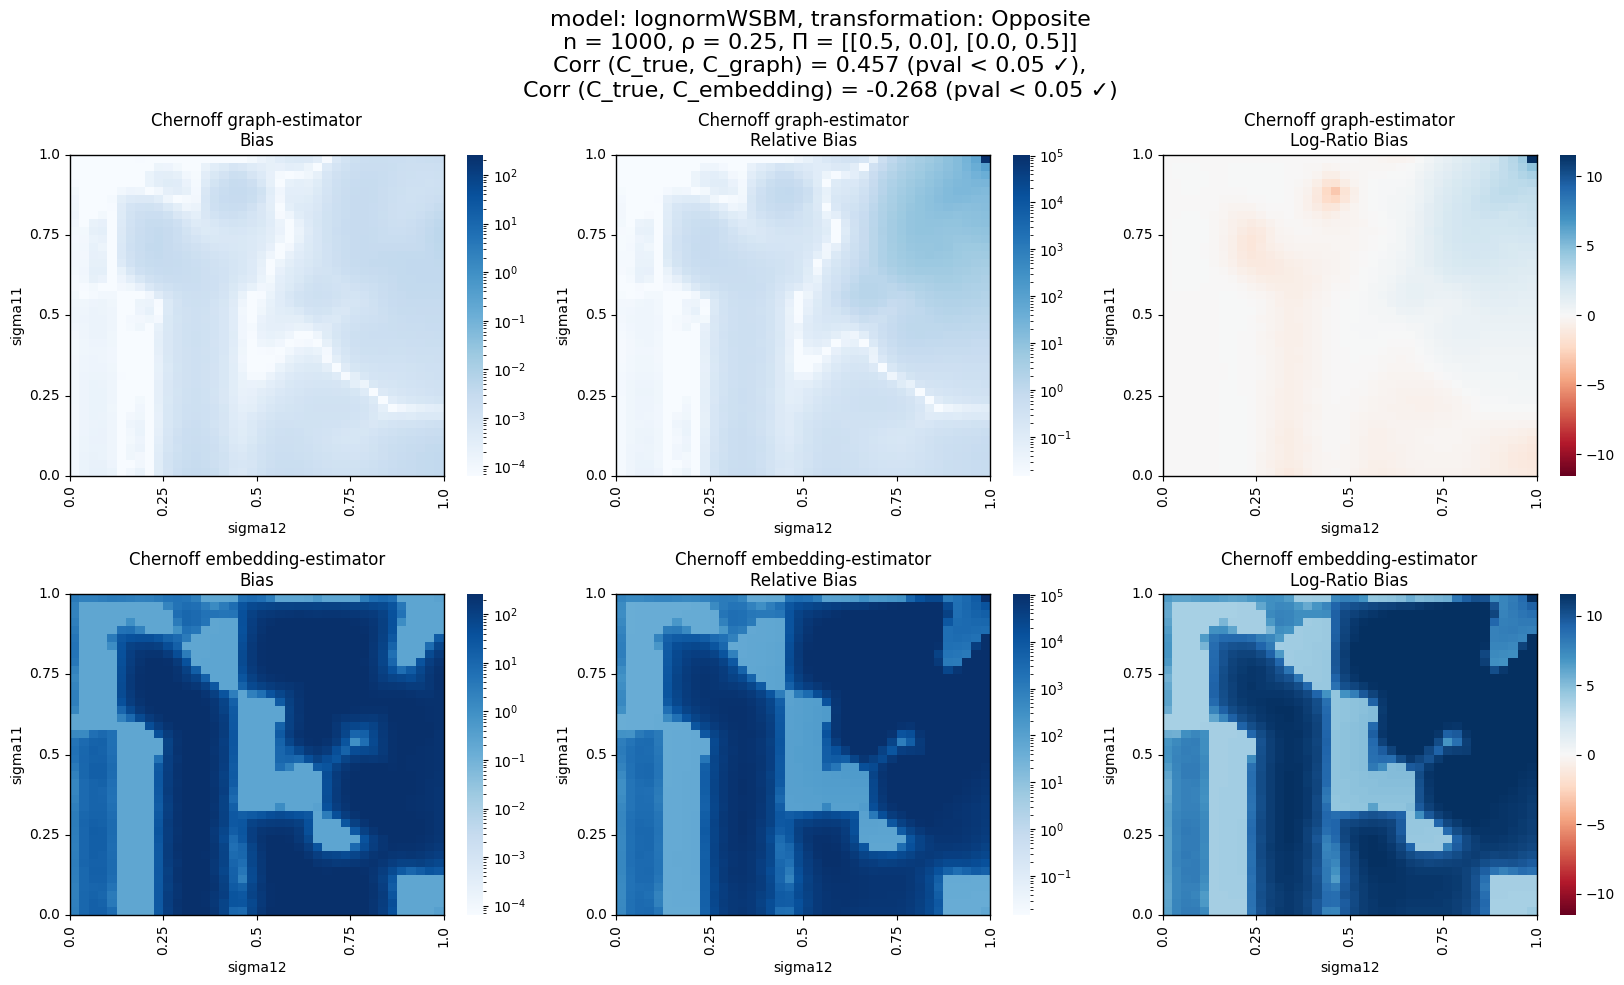

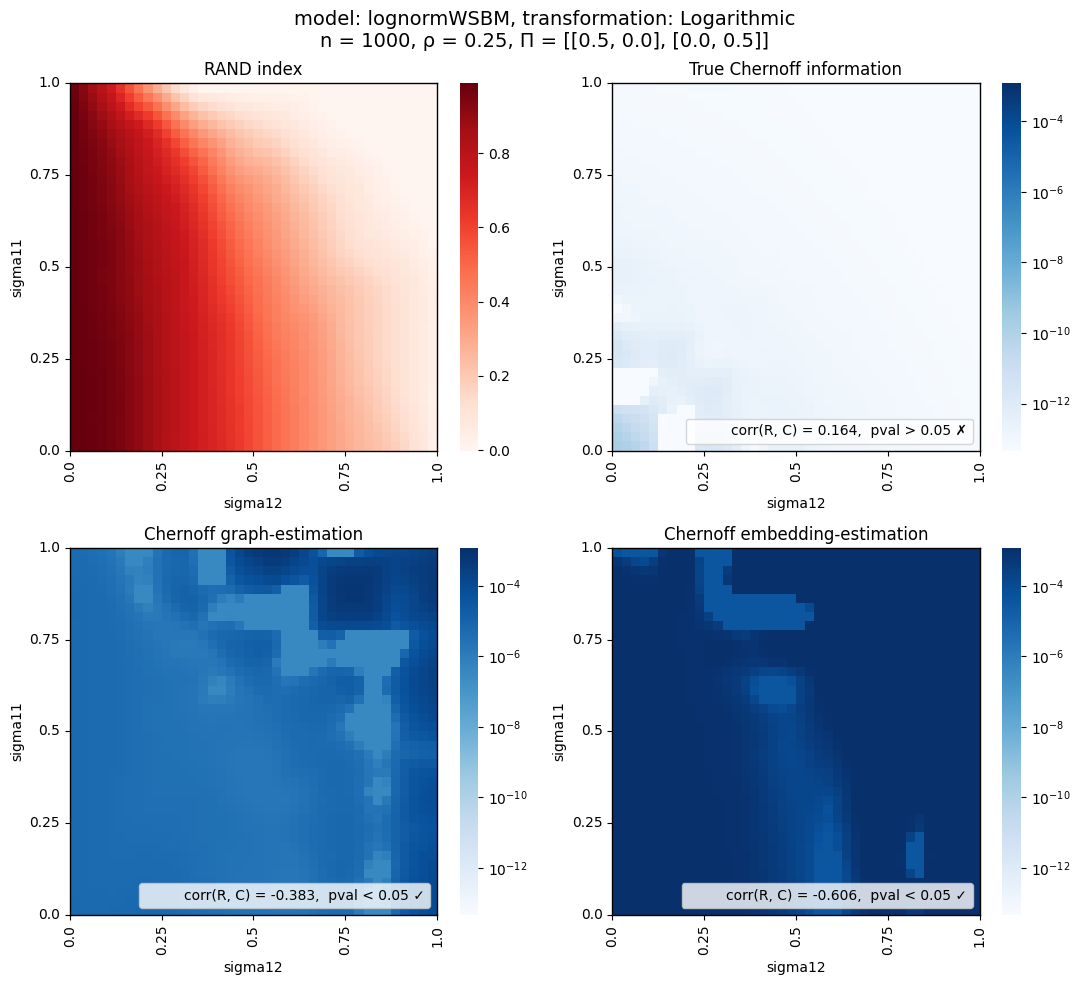

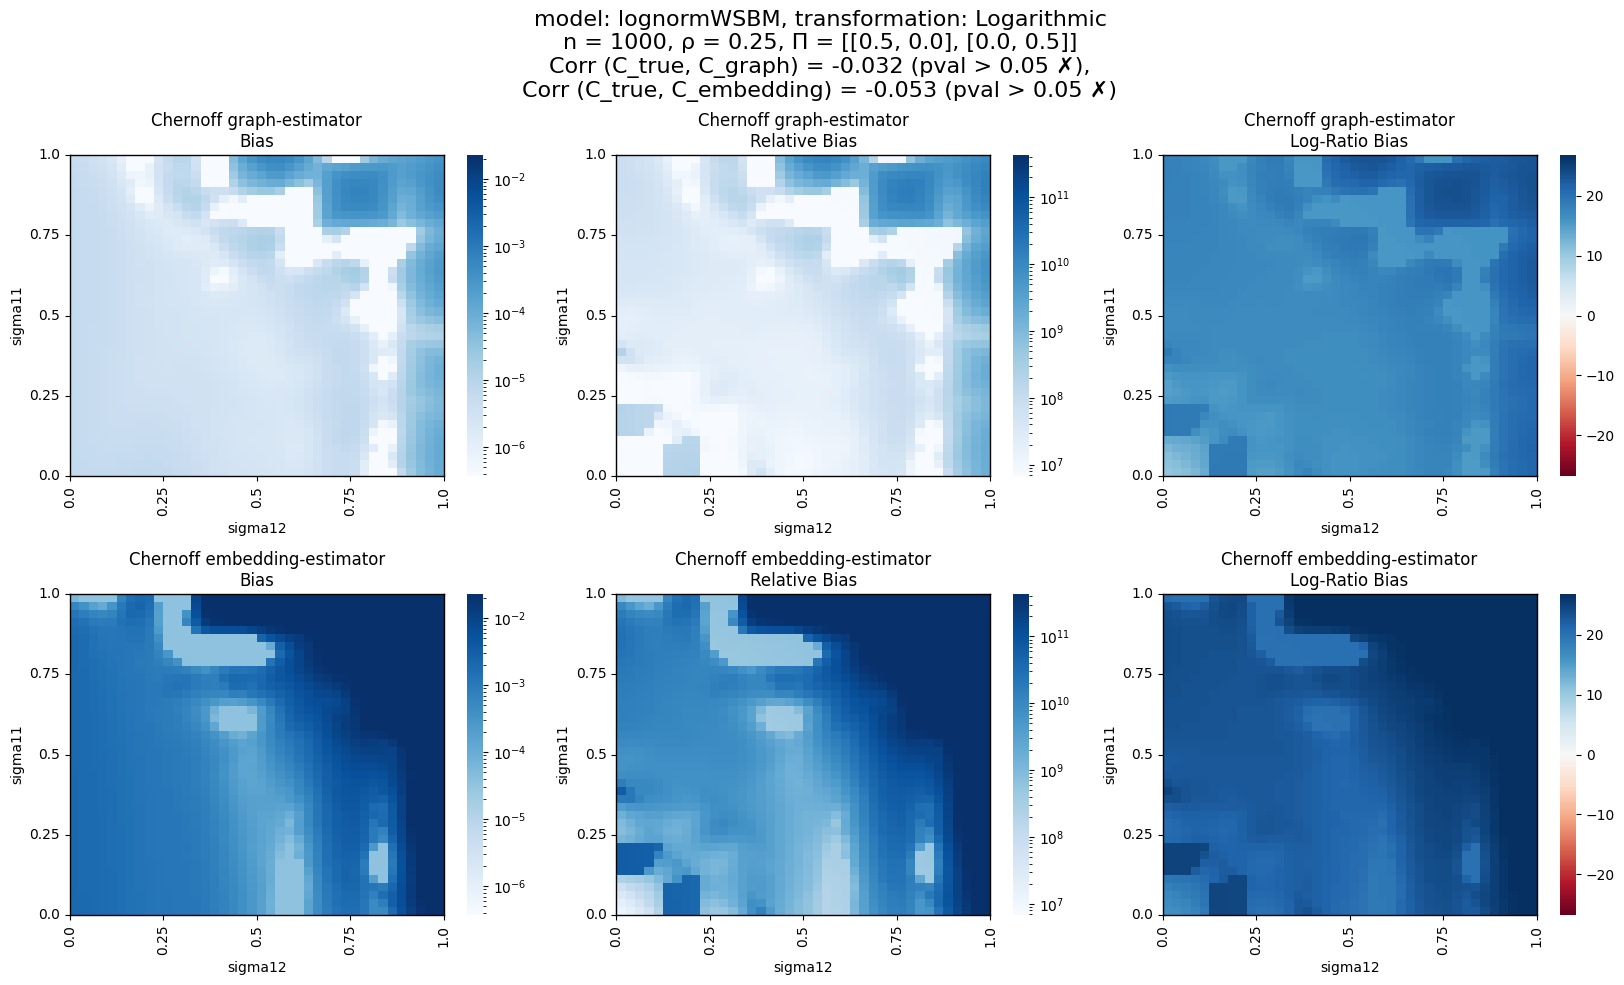

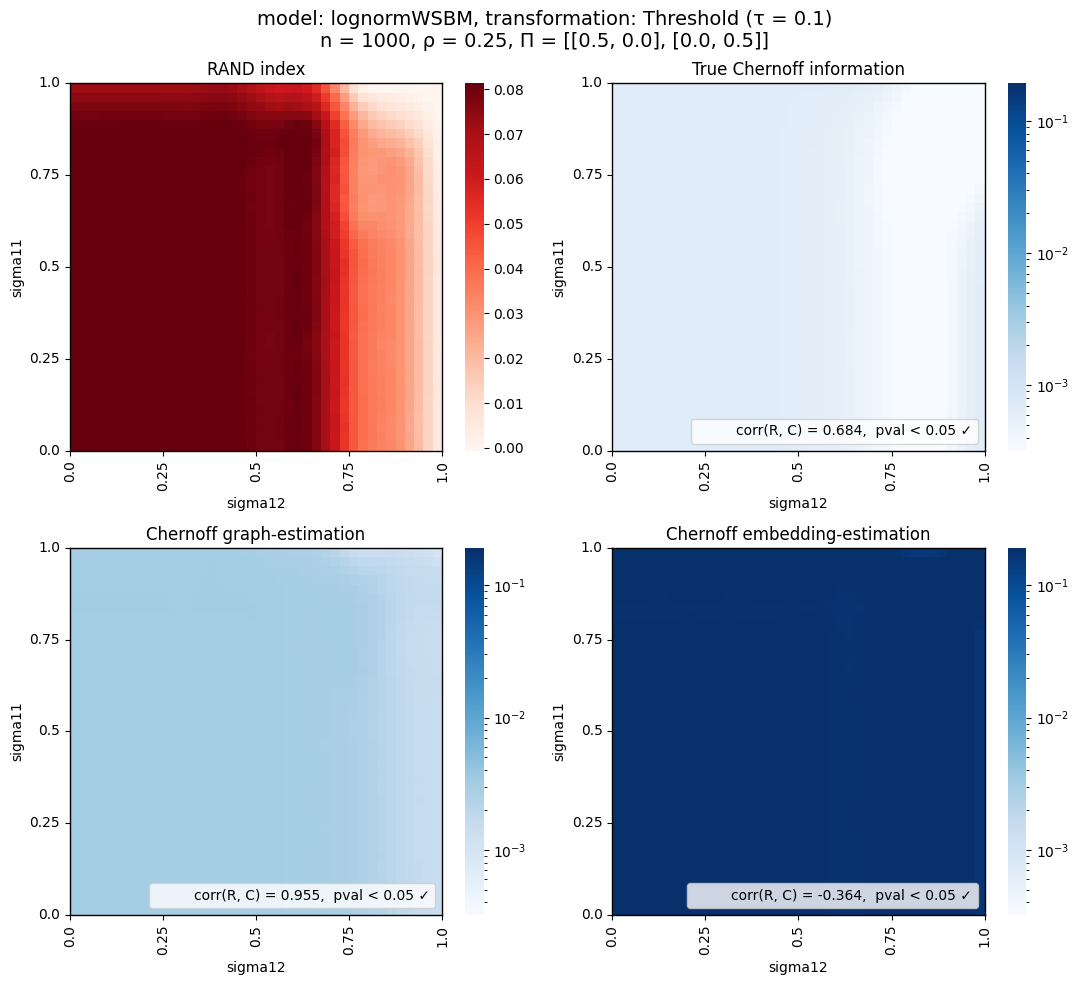

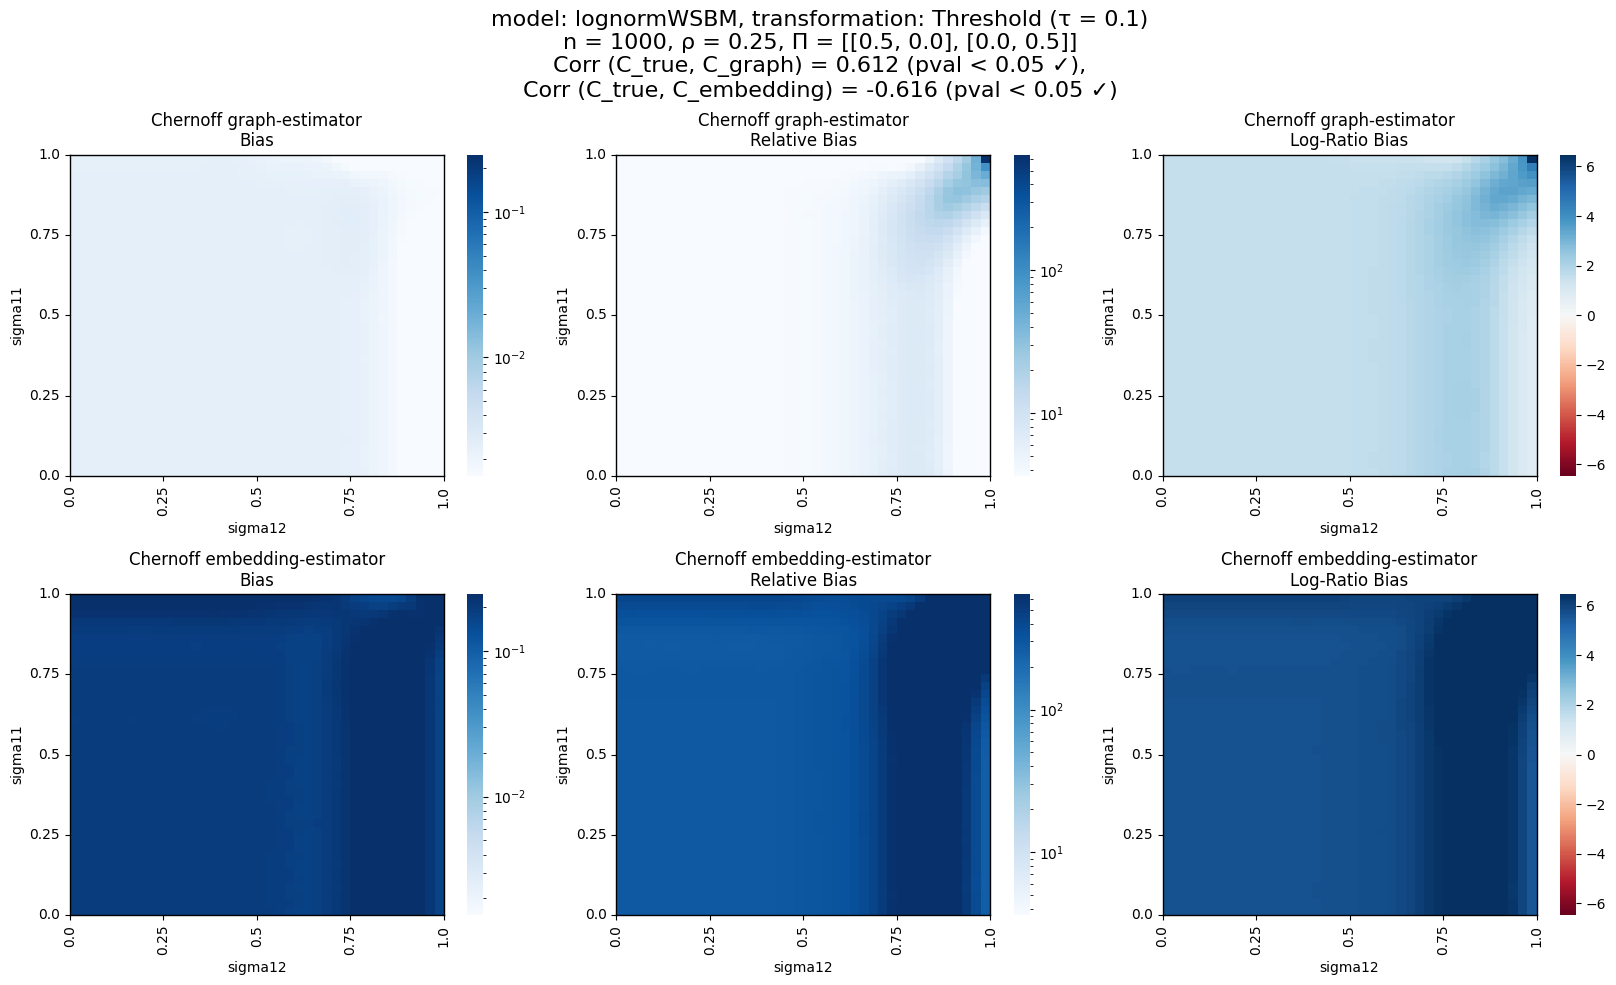

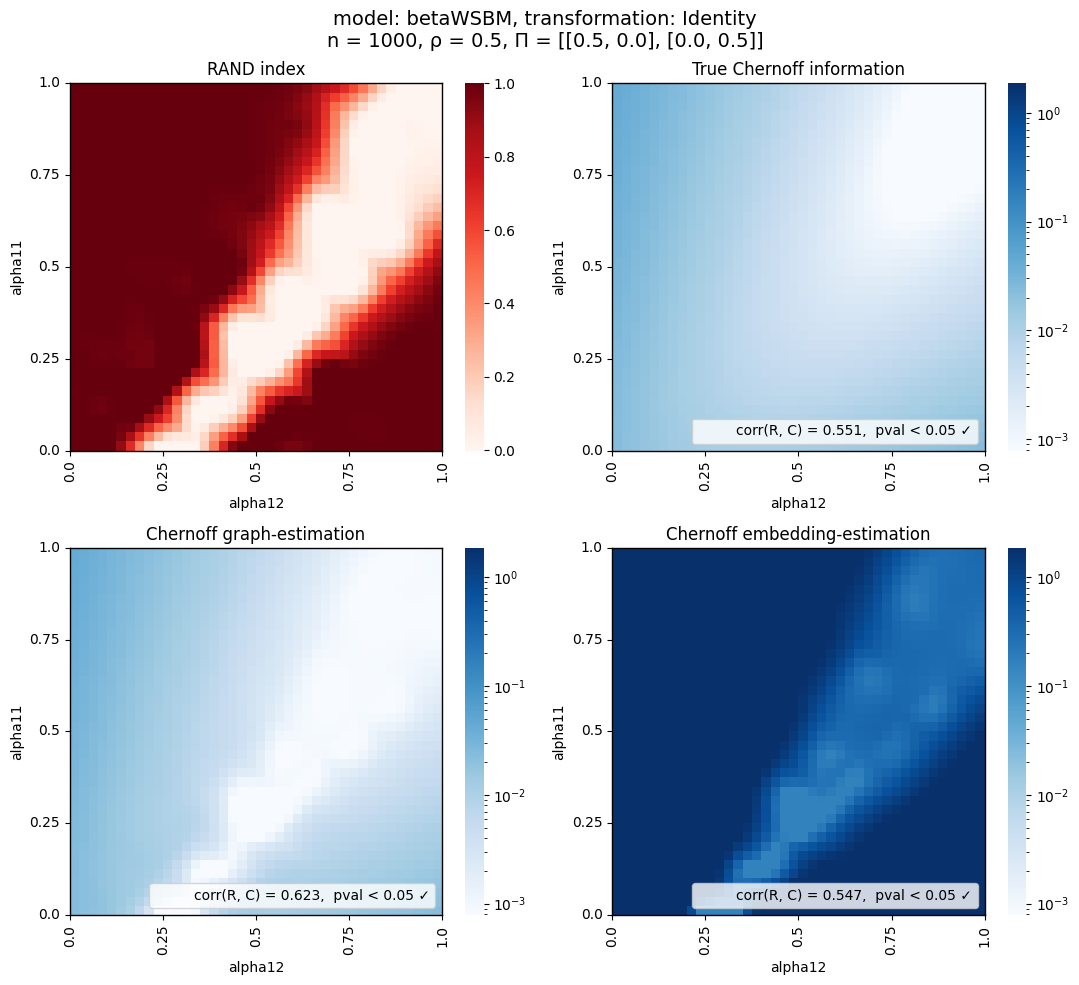

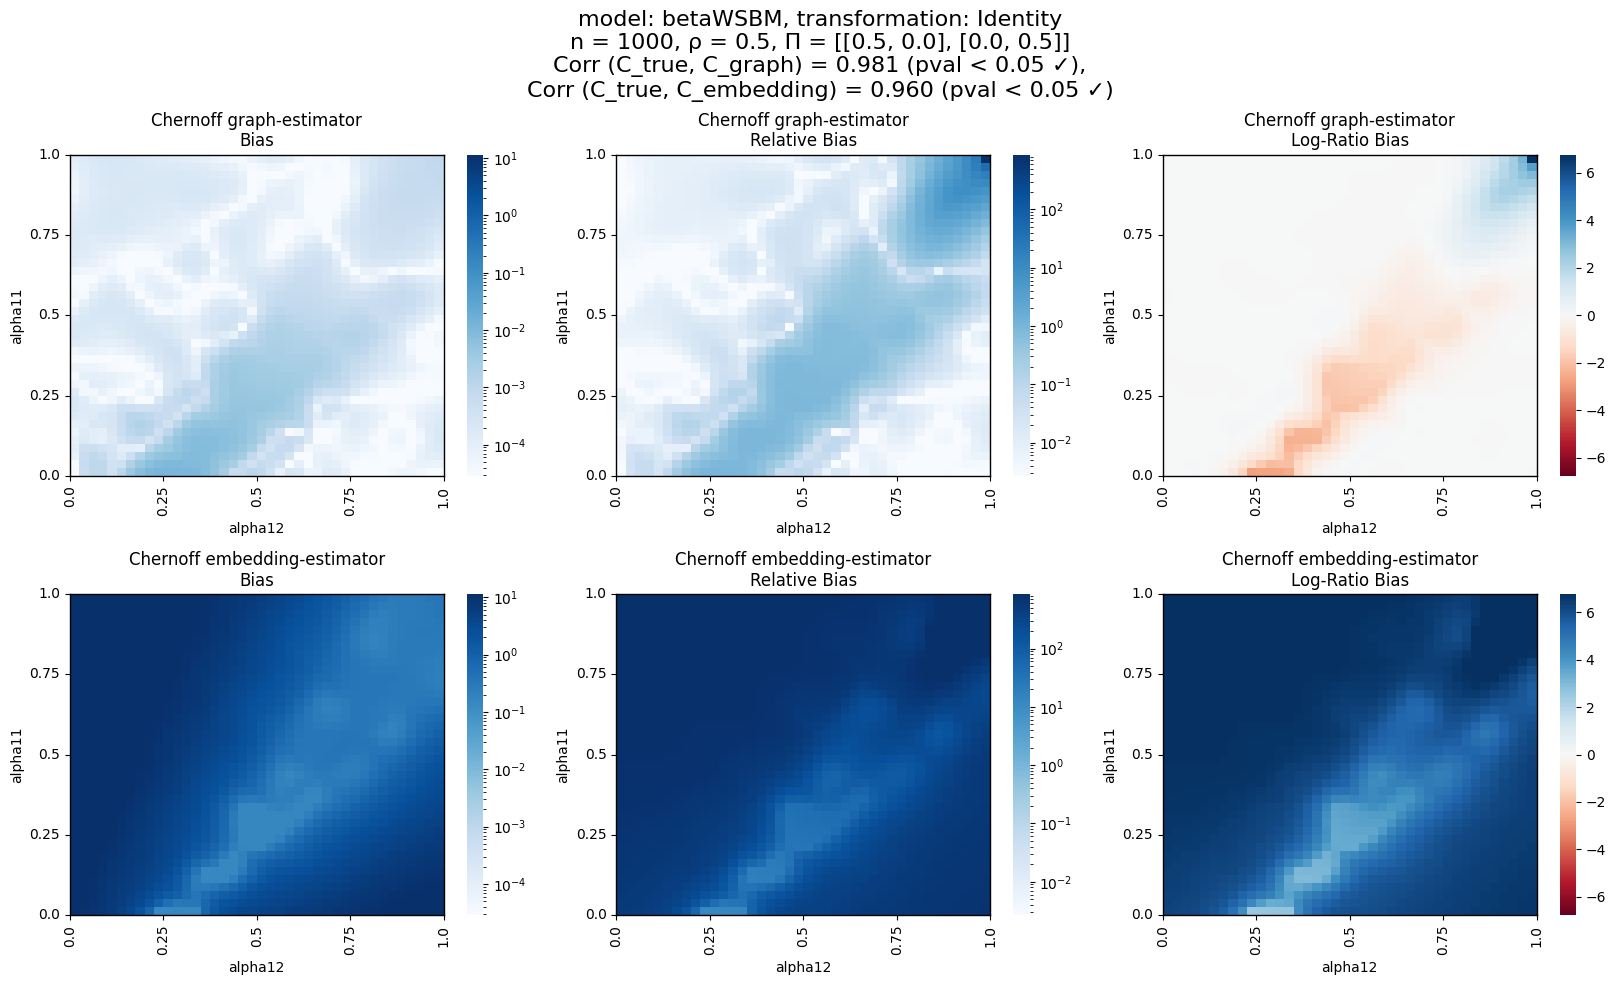

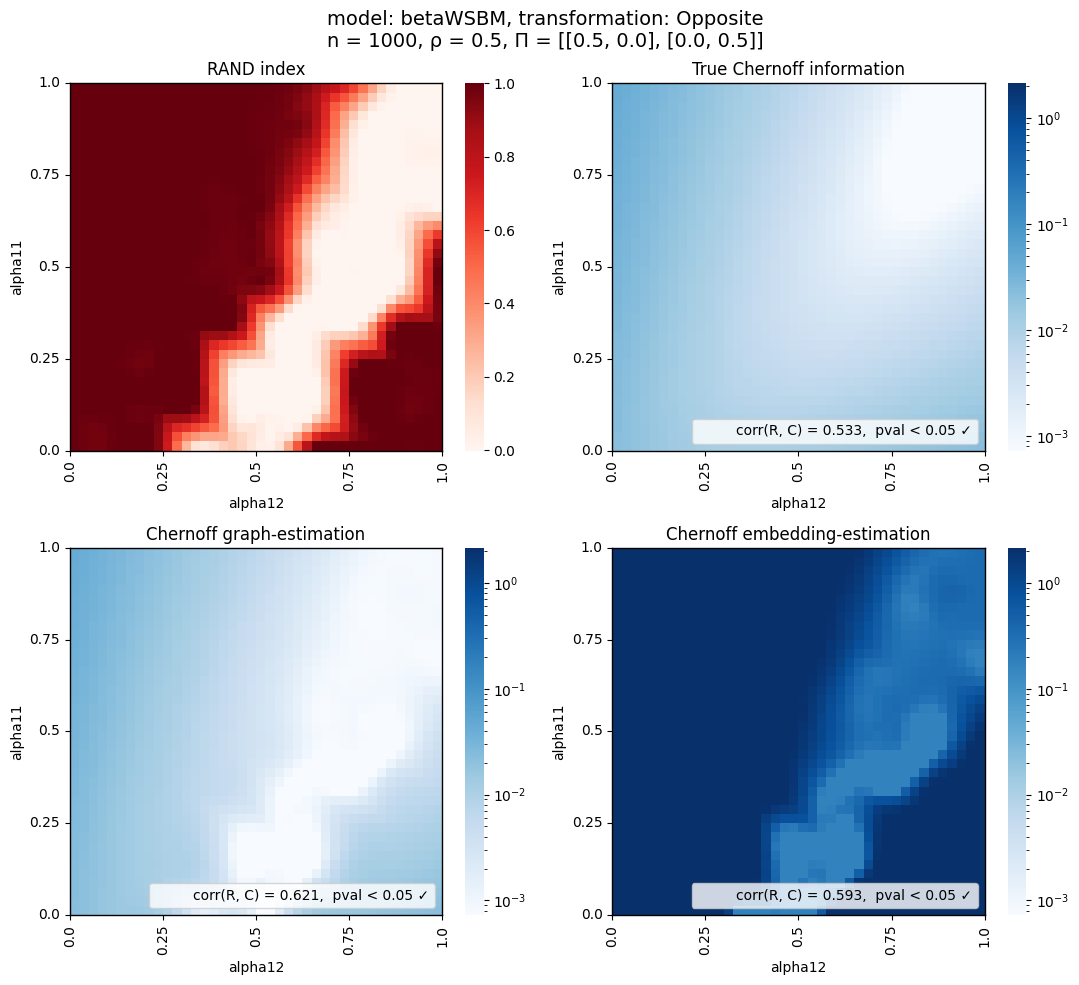

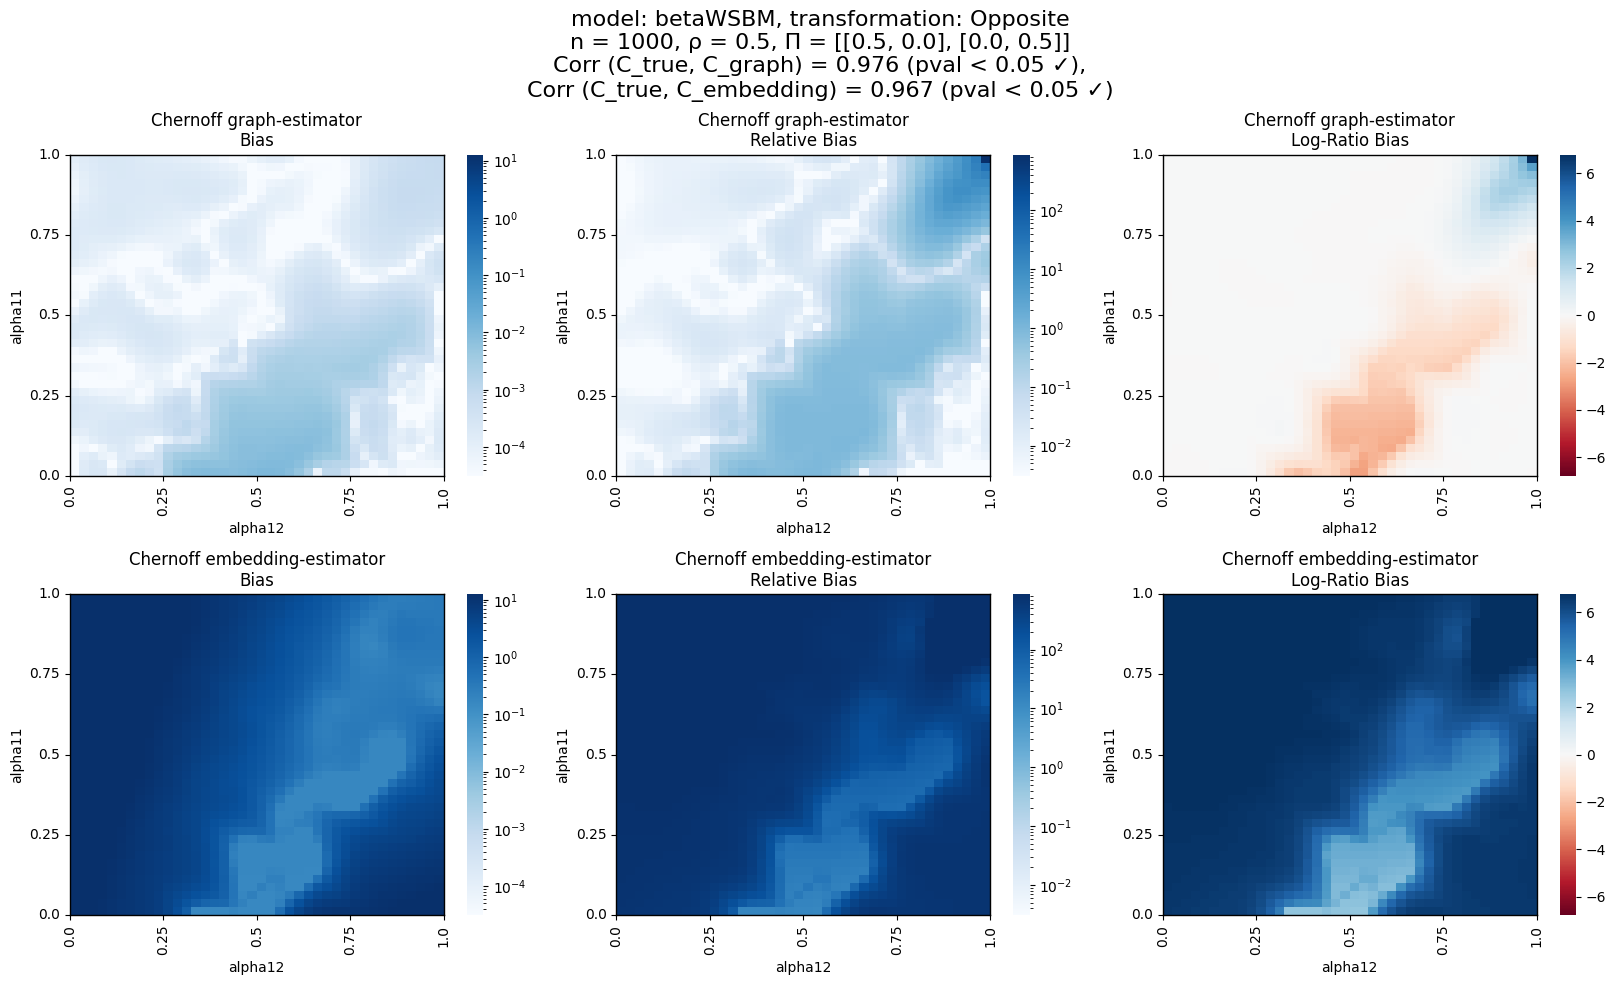

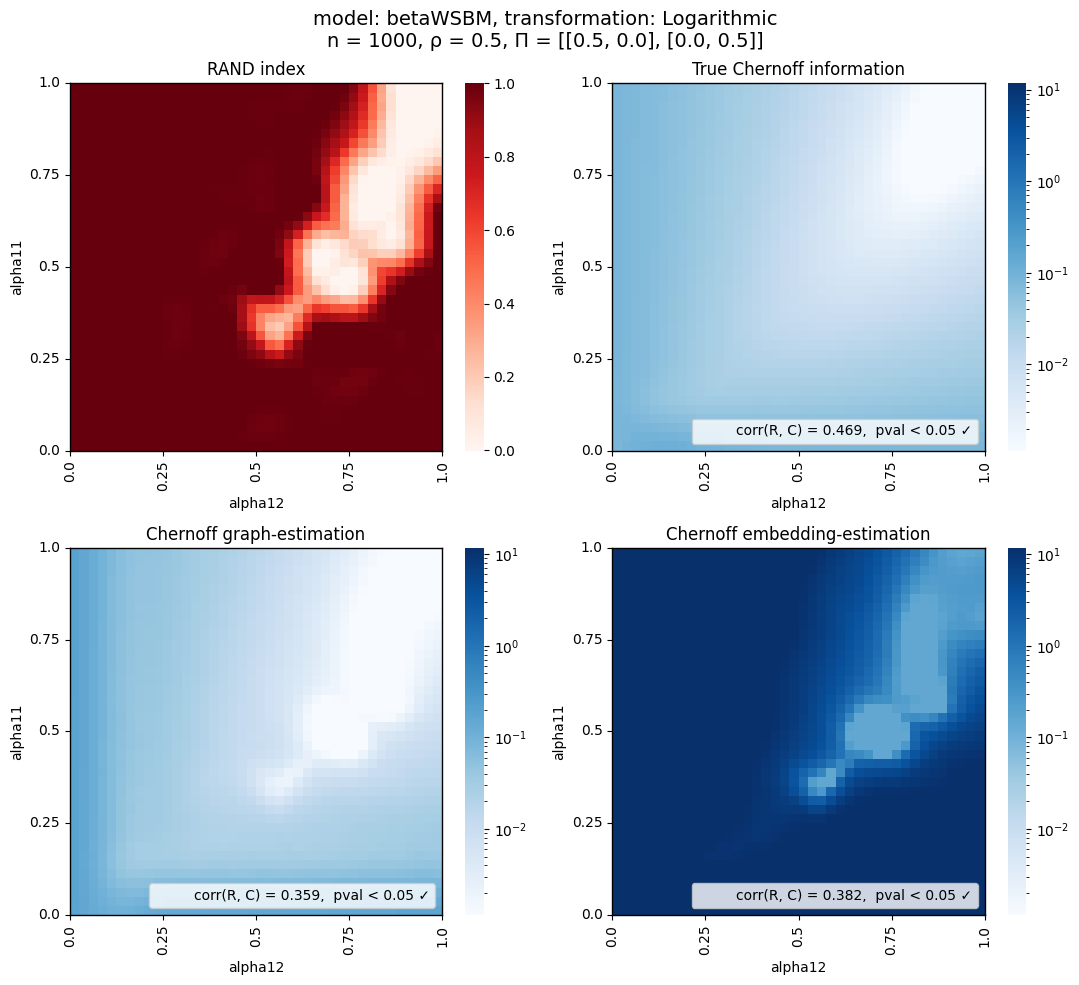

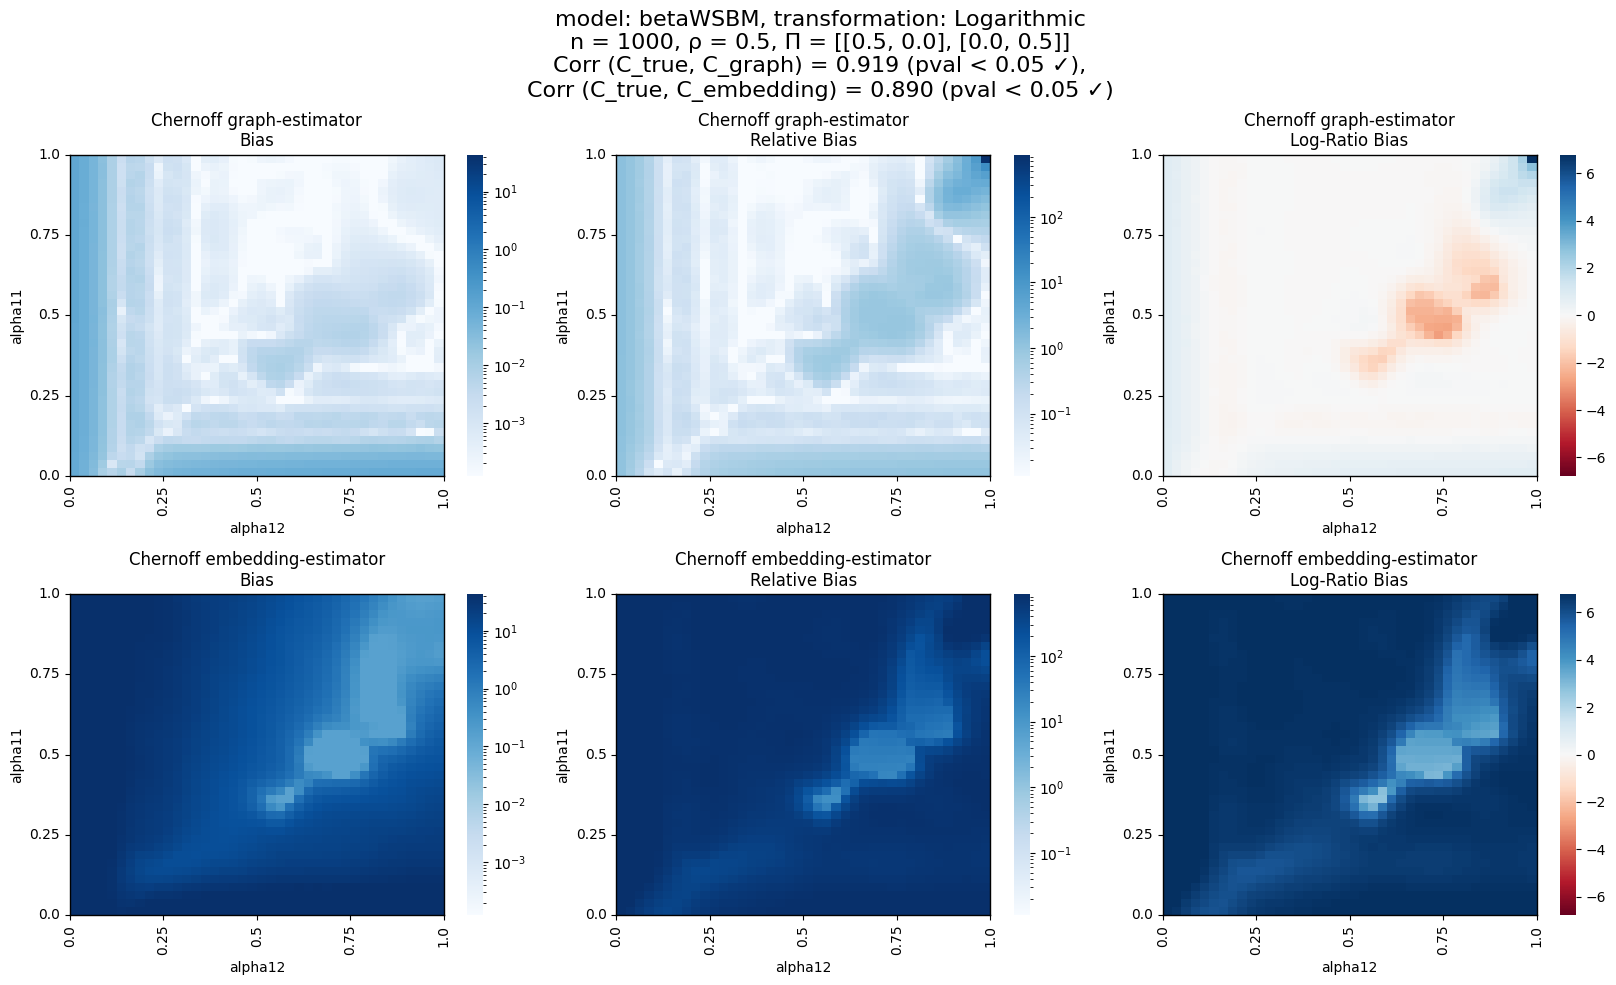

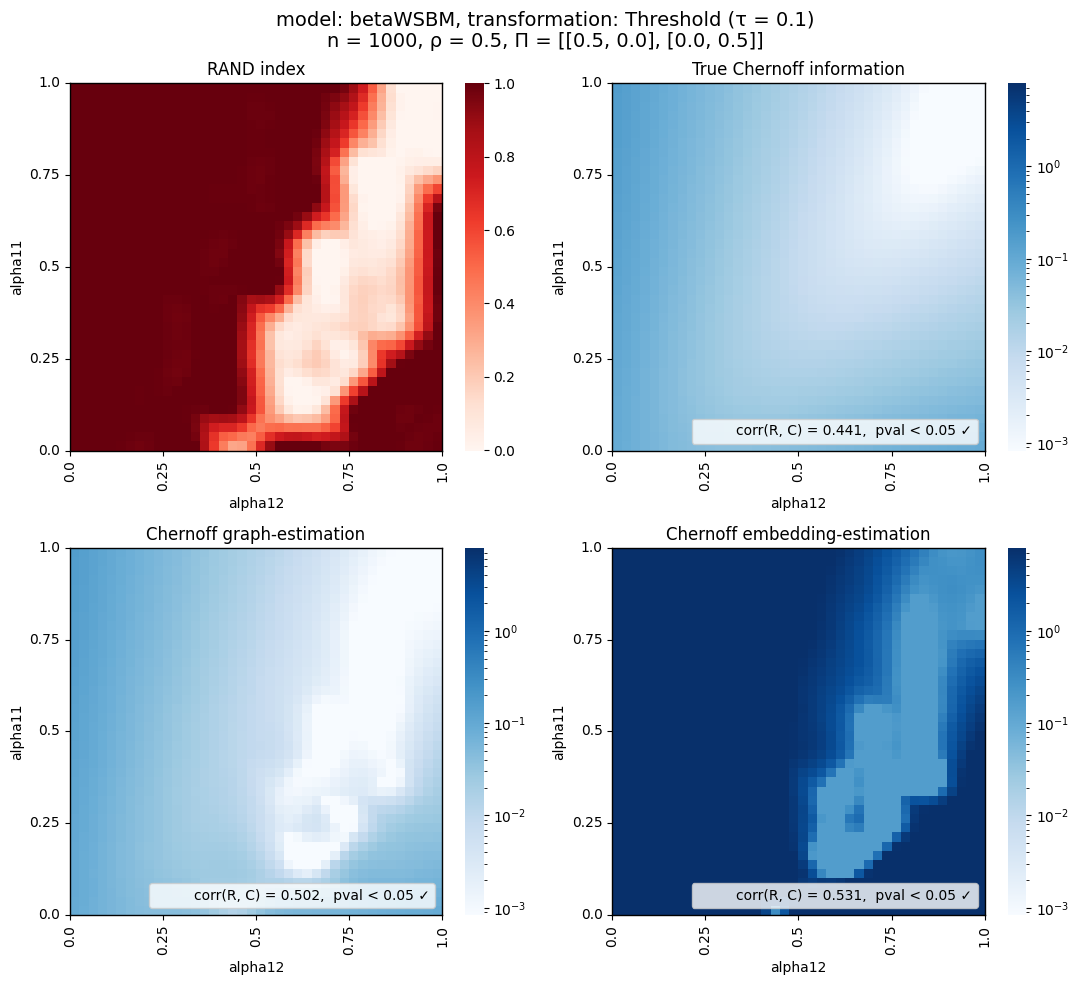

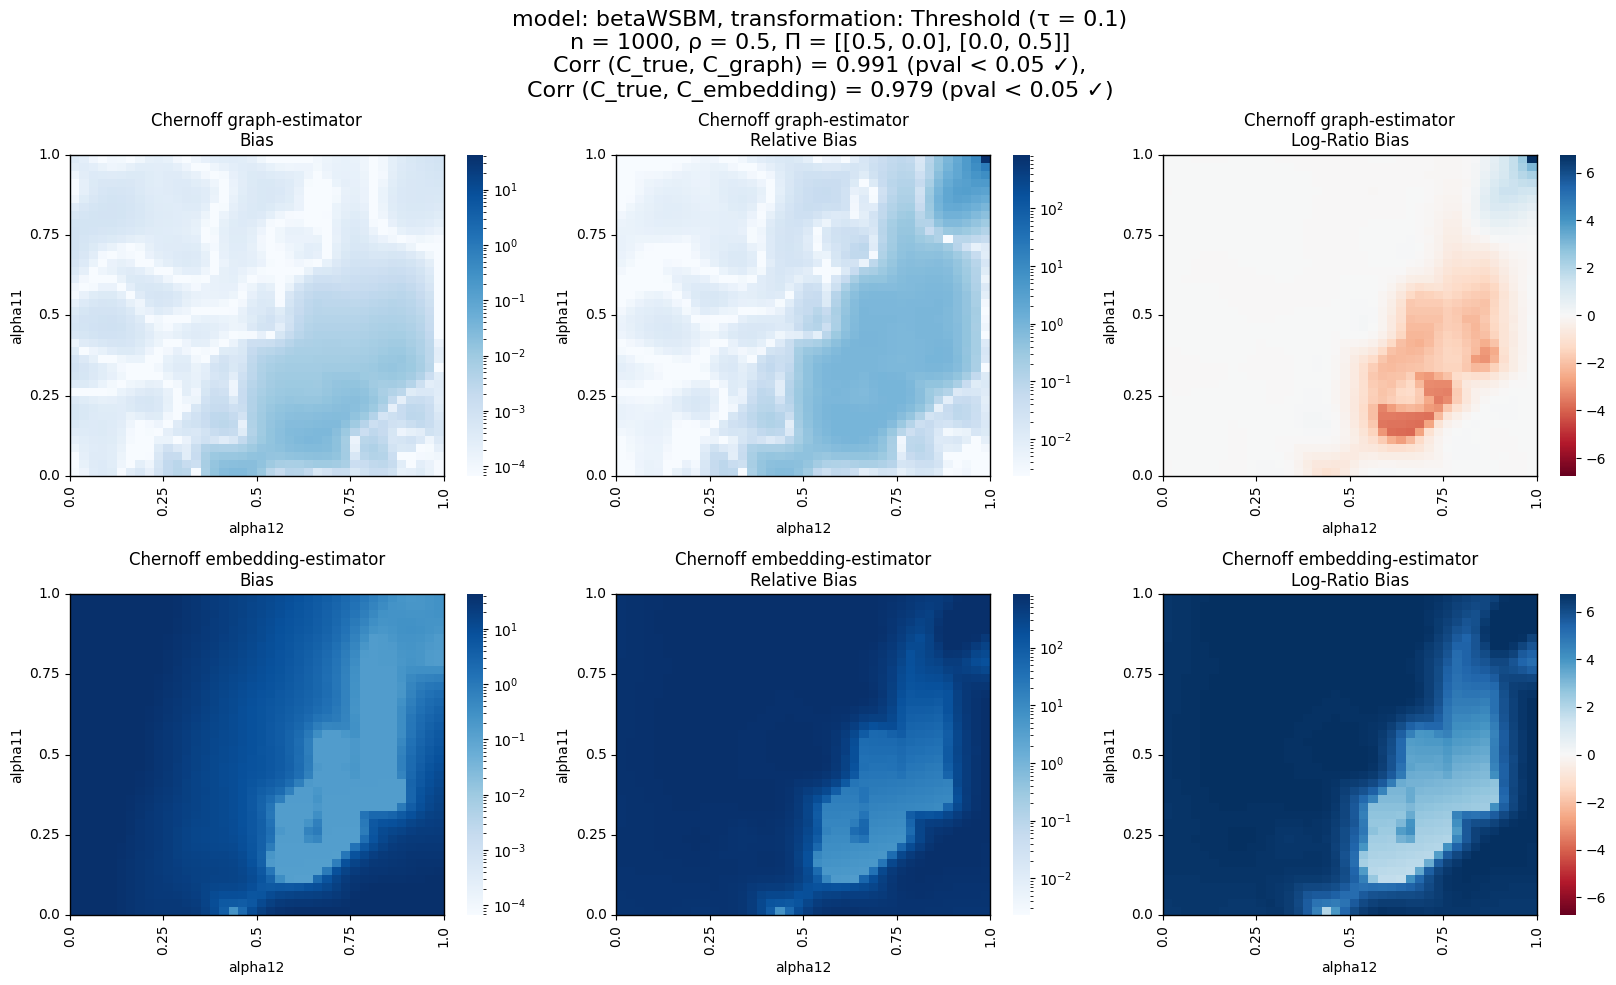

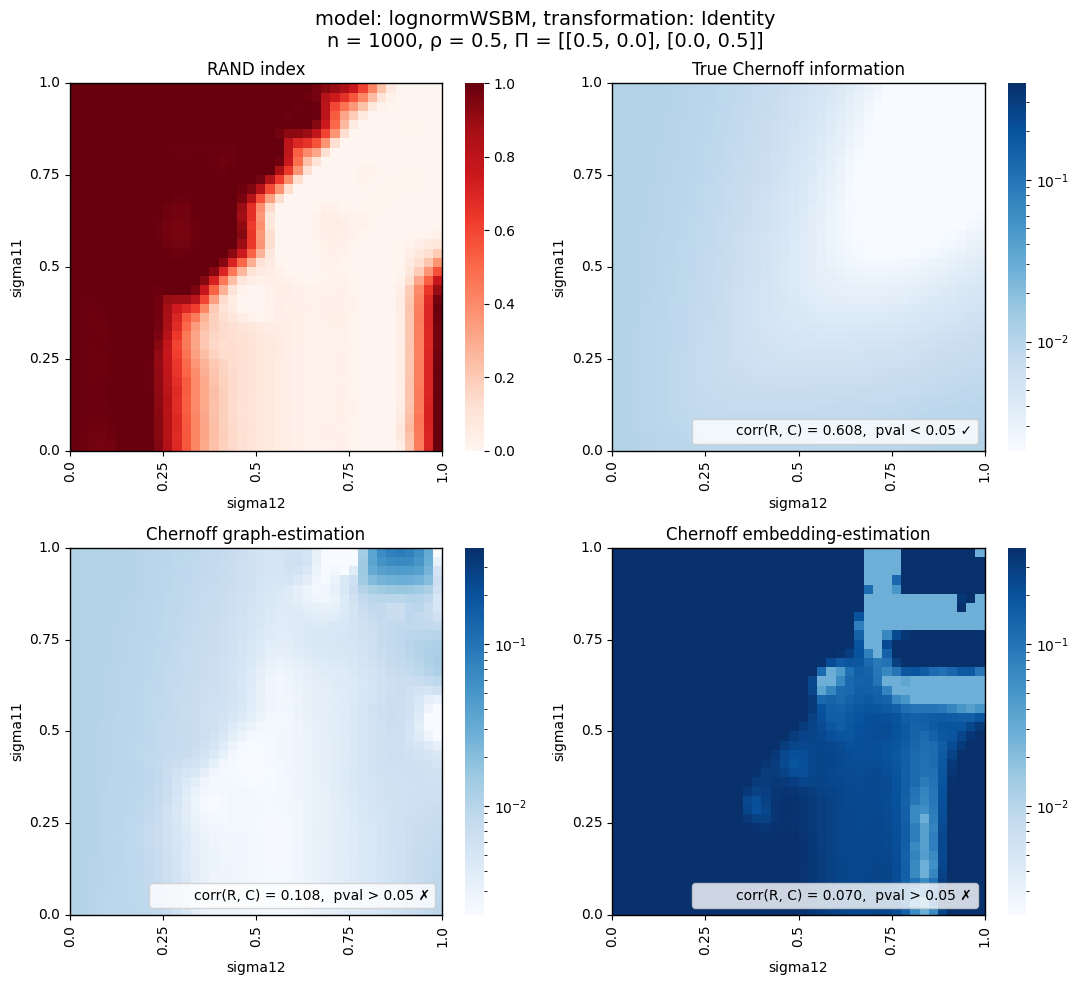

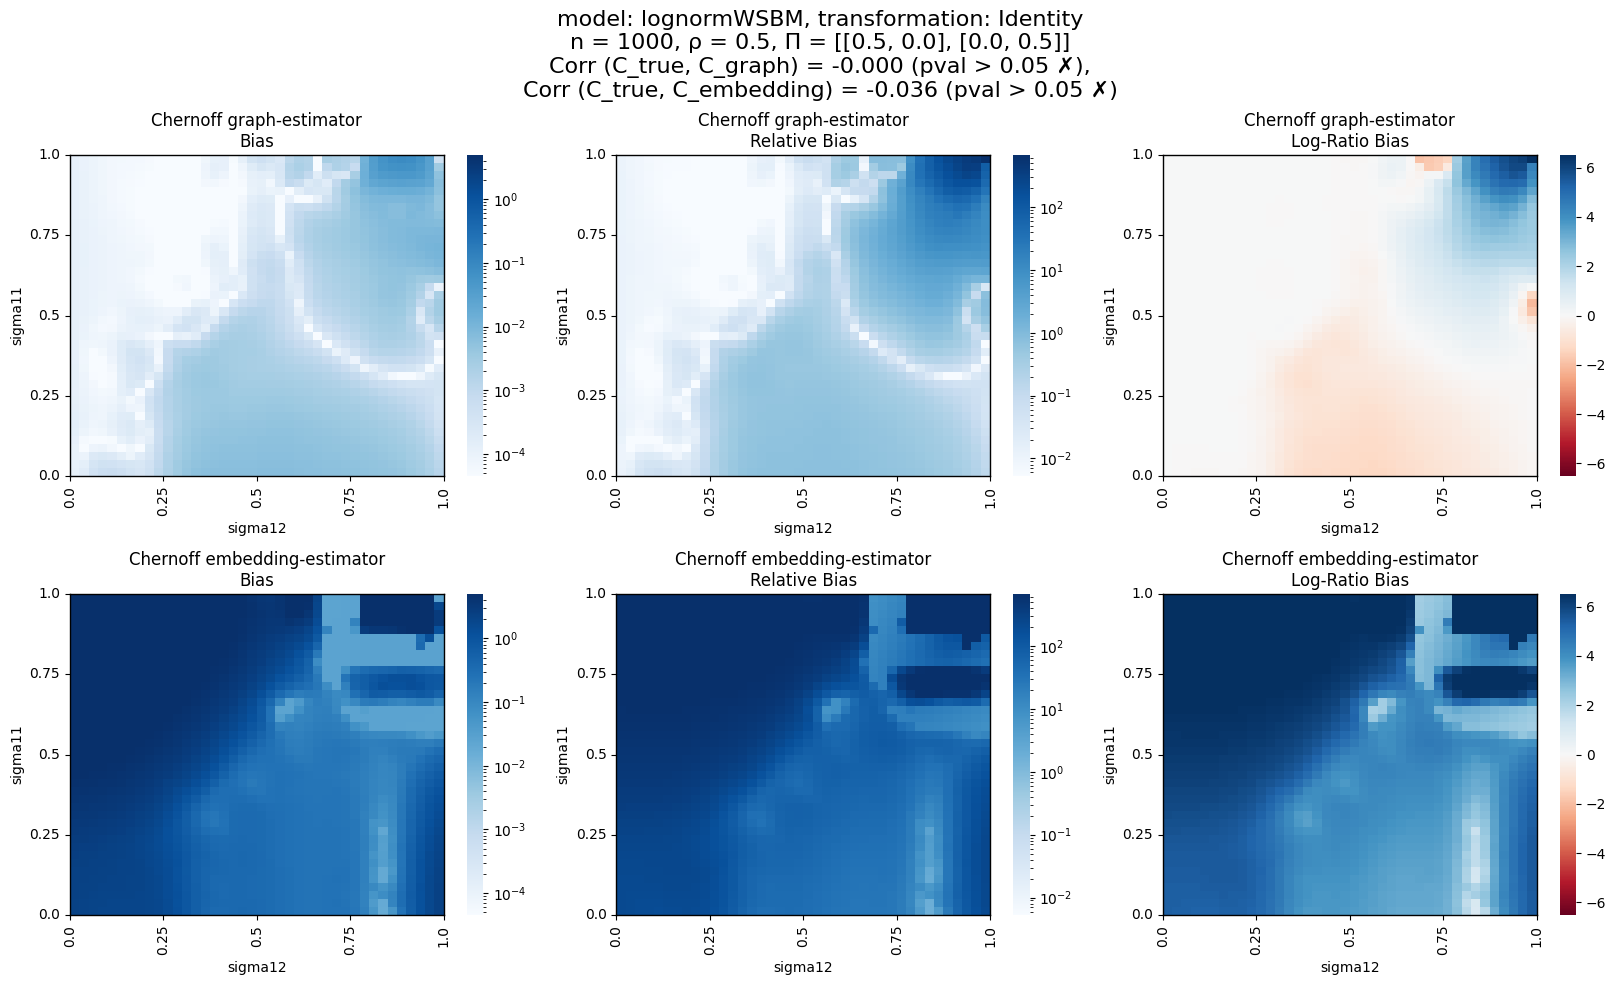

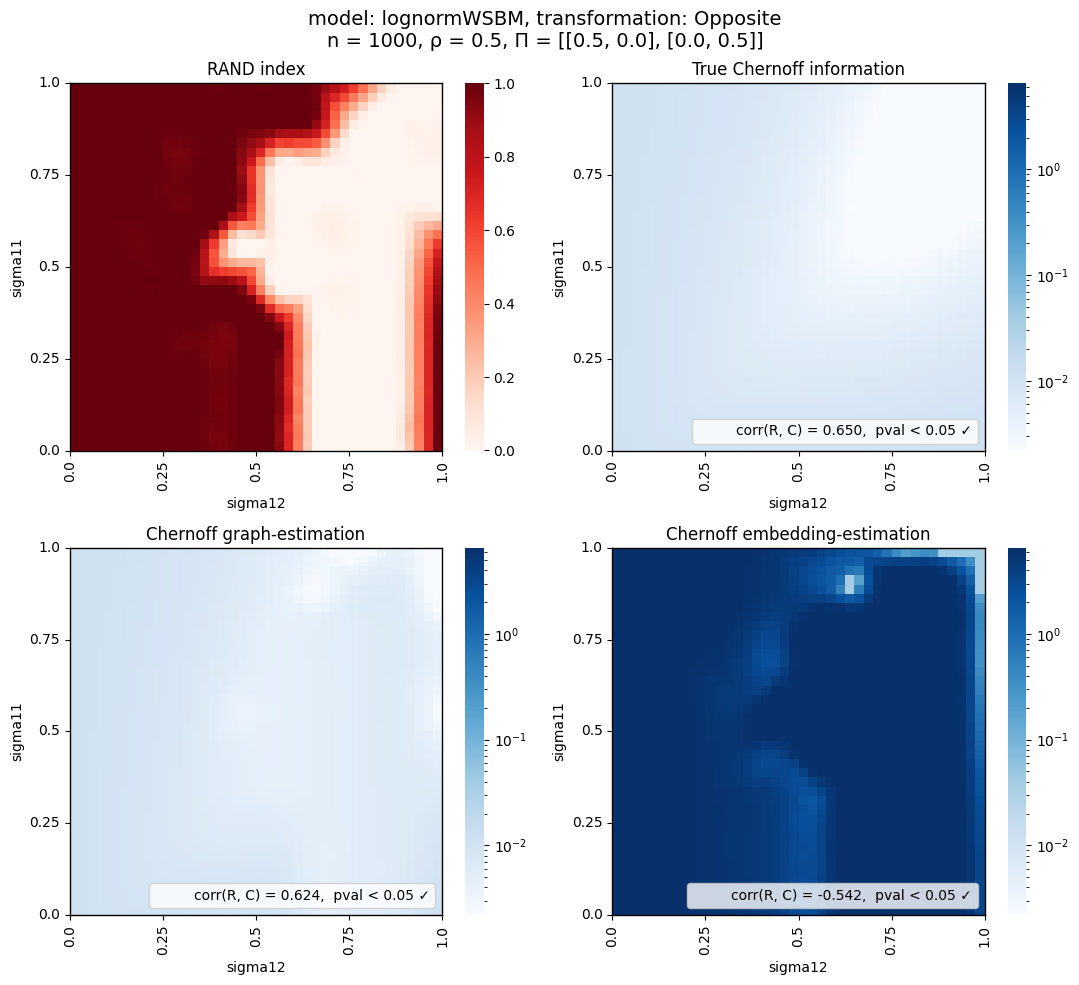

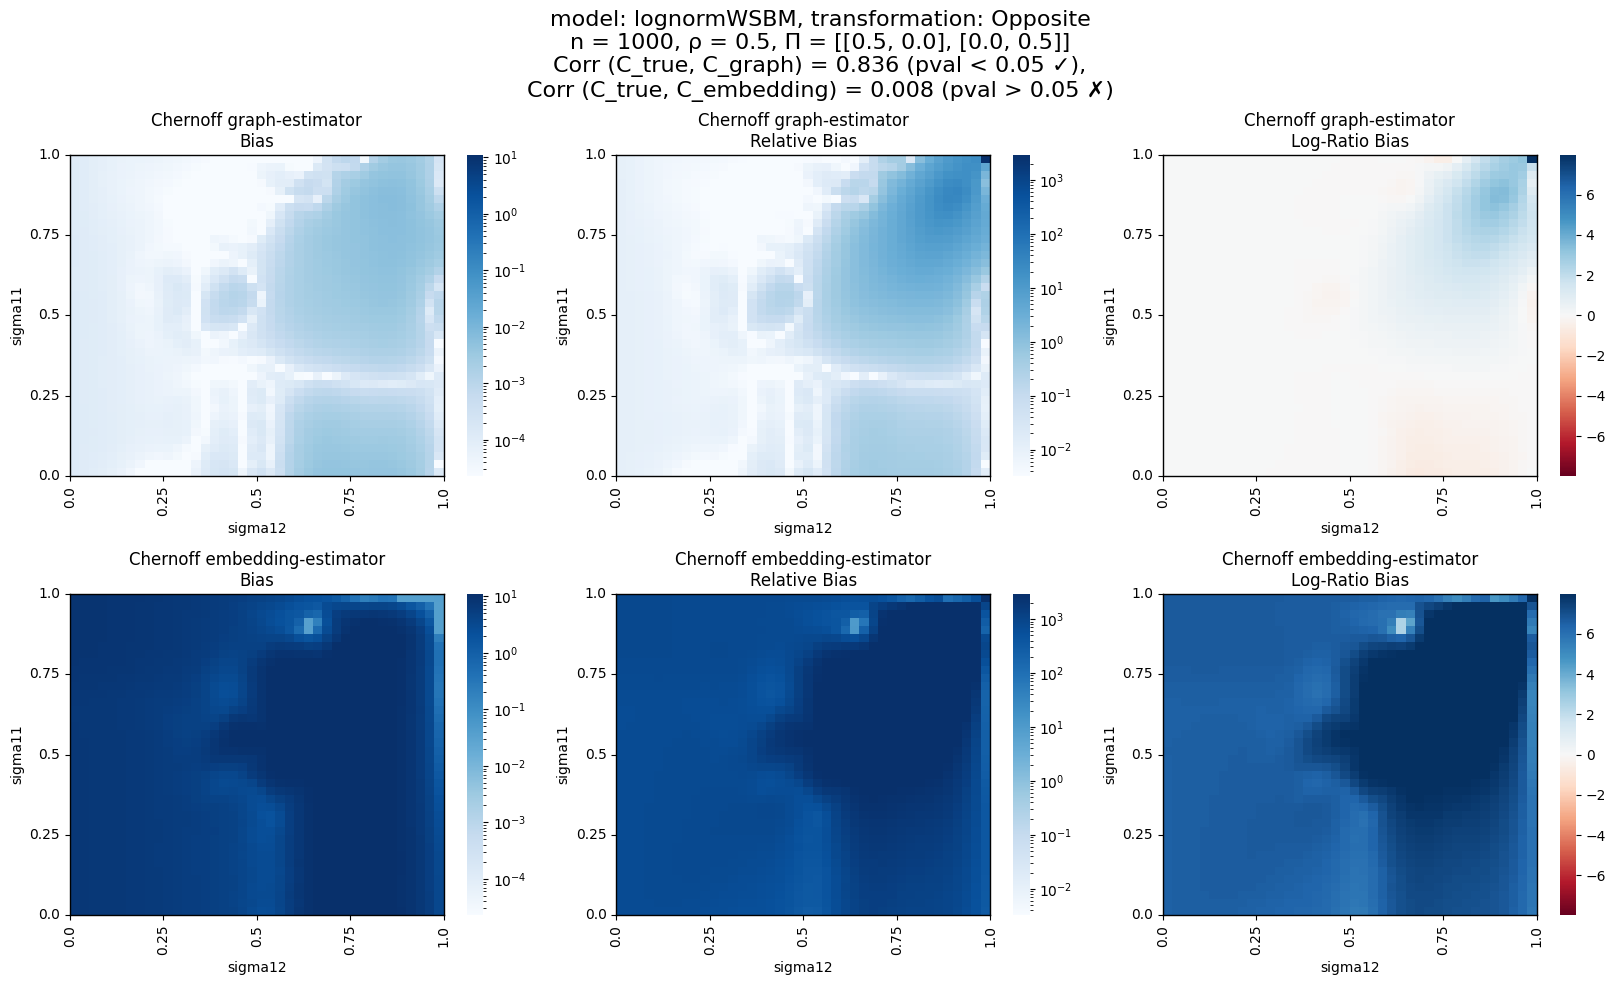

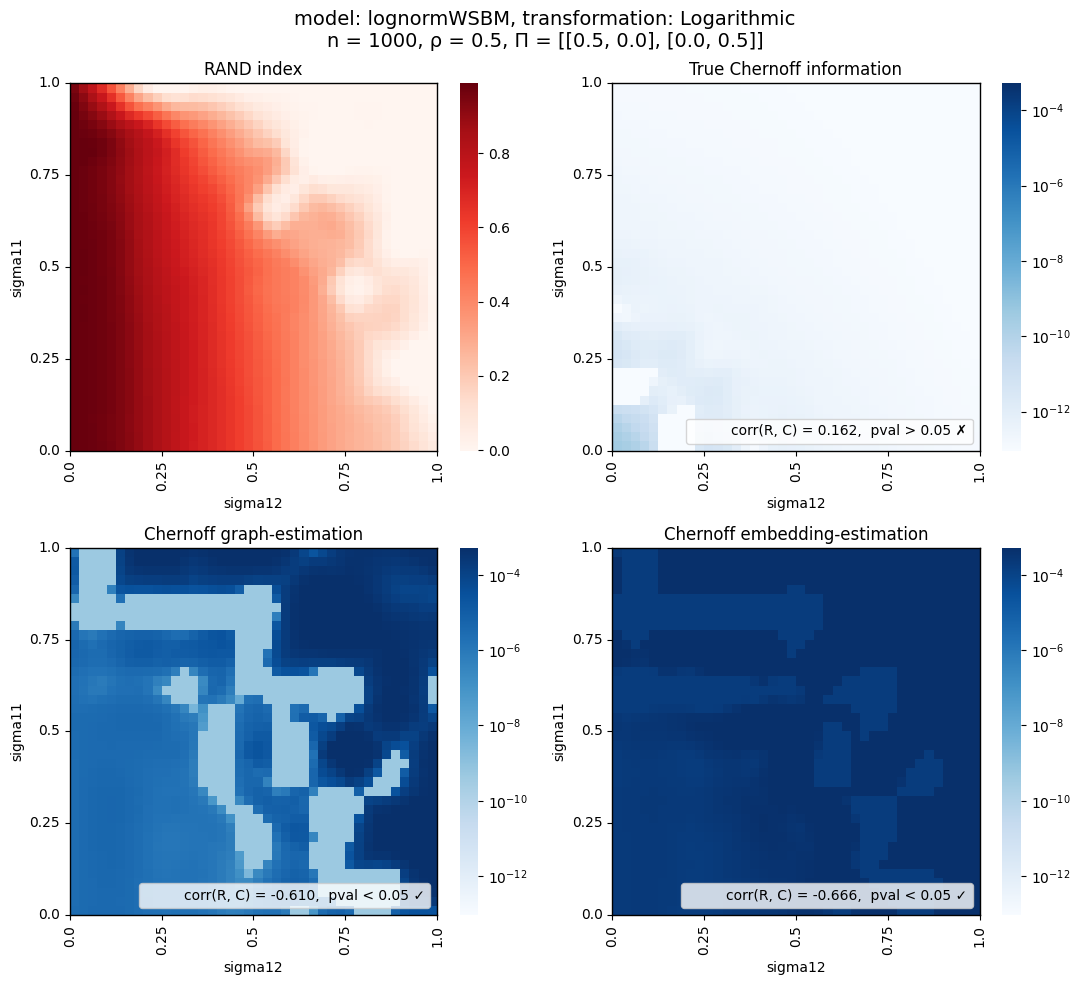

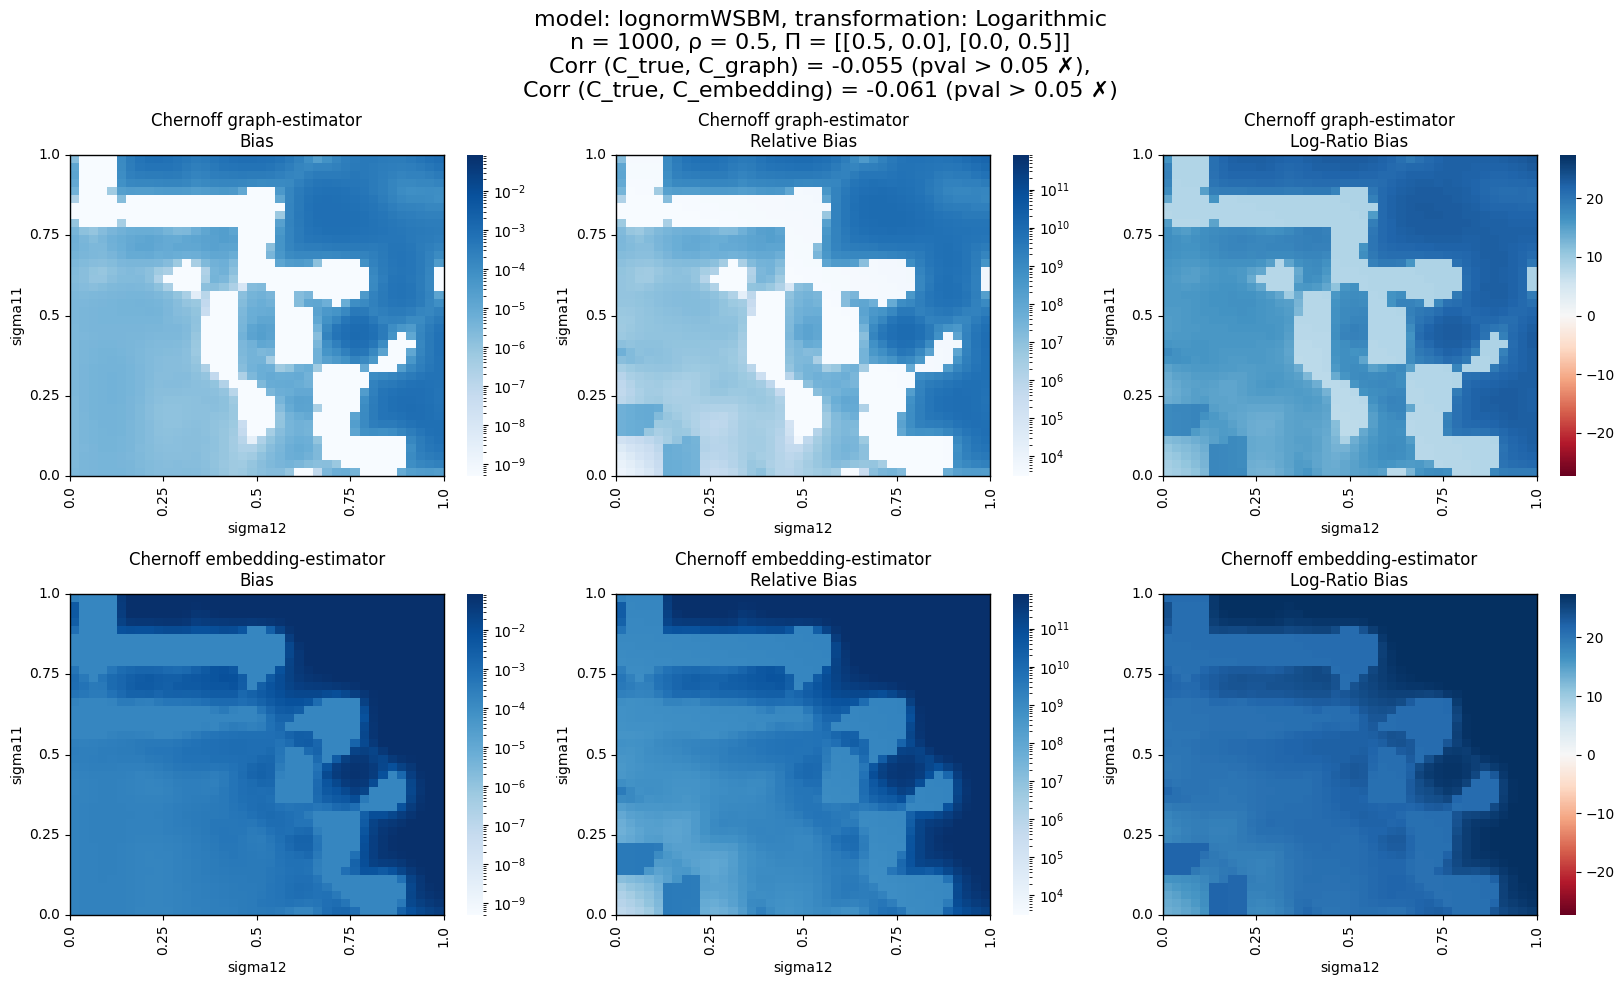

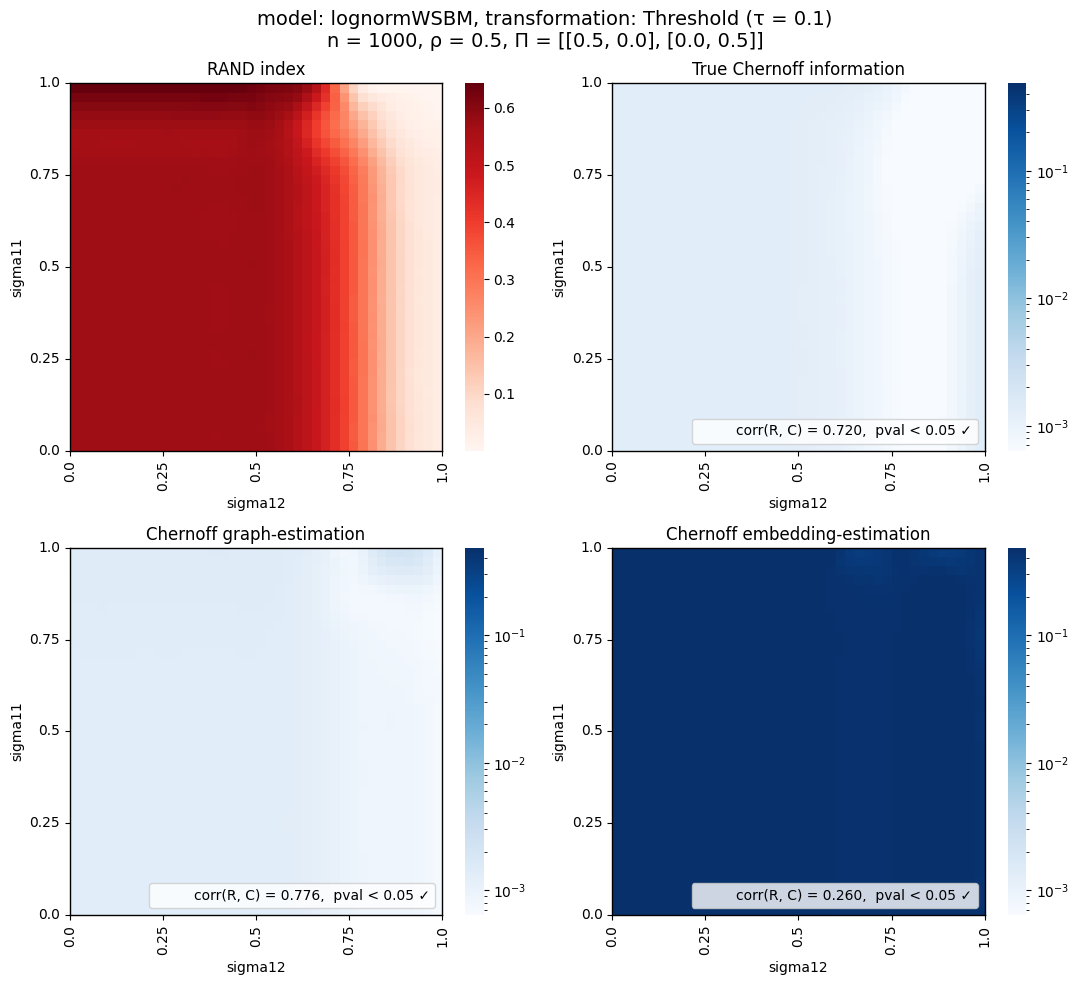

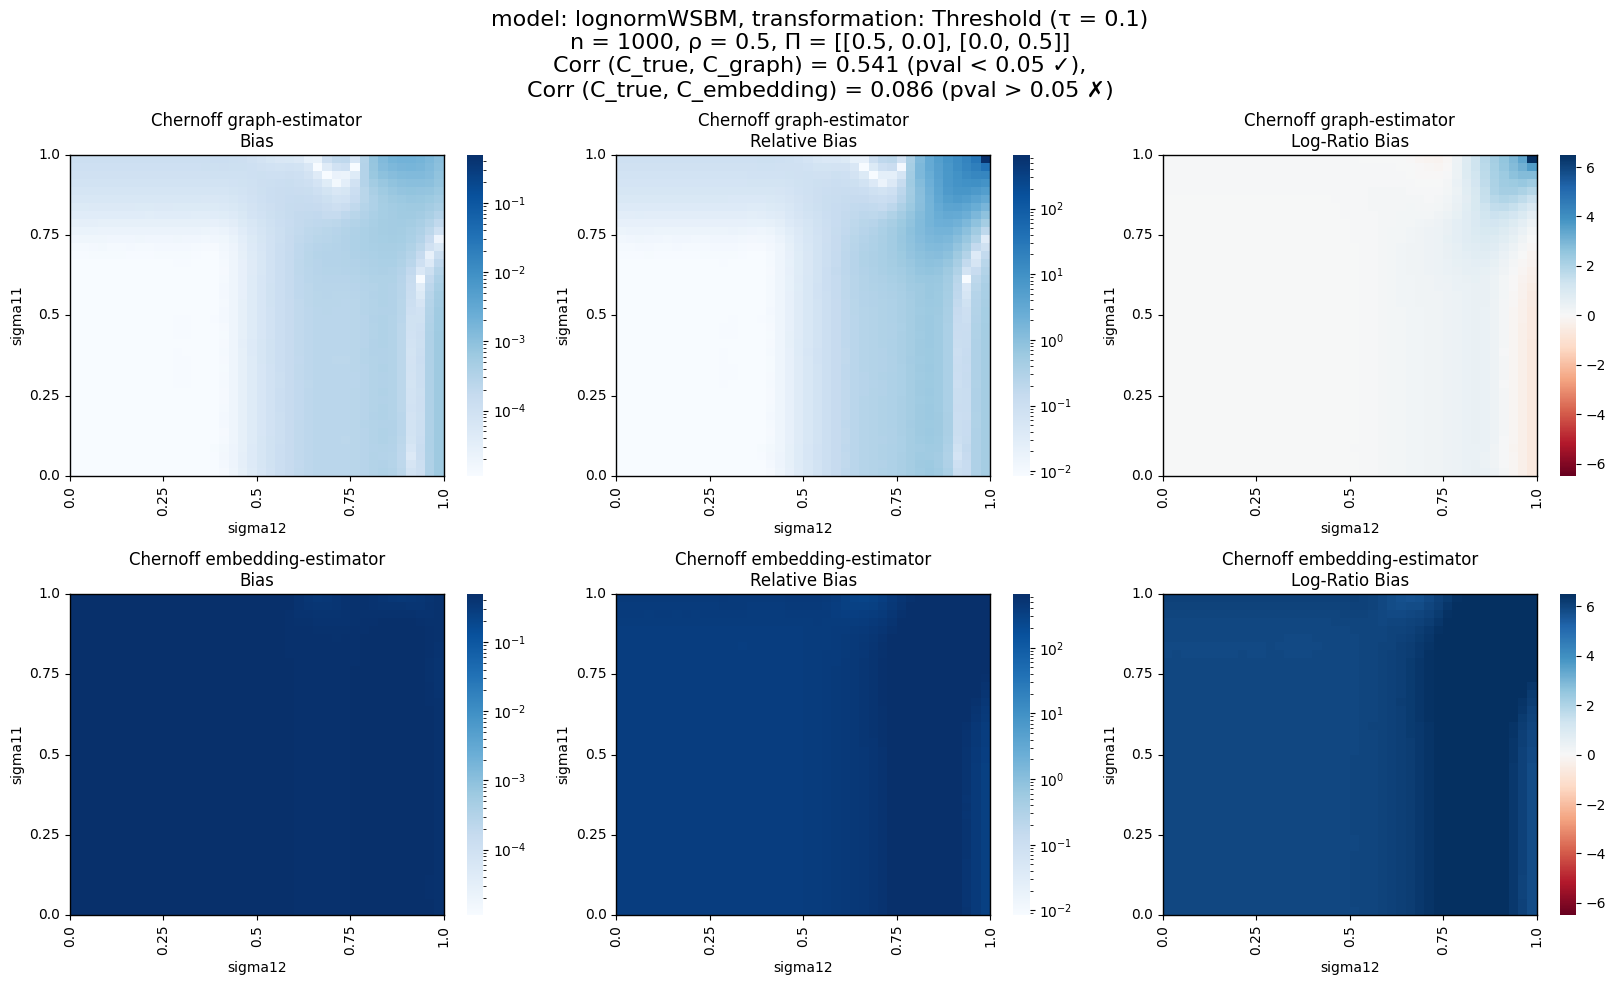

In [103]:
for p, m in metrics.items():
	pi, rho, model, transformation = p
	Grids, Corr_RAND, Corr_C_true, Nr = m
	plot_metrics_heatmaps(model, (n, rho, np.diag([pi, 1-pi])), transformation, Grids, Corr_RAND, Nr)
	plot_bias_heatmaps(model, (n, rho, np.diag([pi, 1-pi])), transformation, Grids, Corr_C_true, Nr, abs_mode=True)

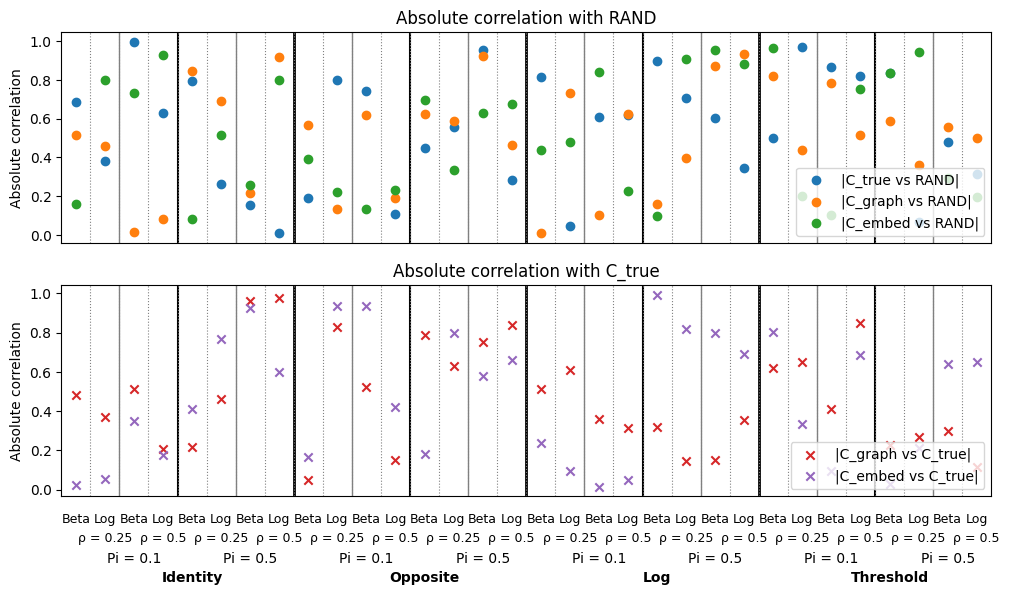

In [149]:
# The 'metrics' dict is assumed to have entries:
#   metrics[(pi, rho, model, transform)] = (_, Corr_RAND, Corr_C_true, _)
# where Corr_RAND = [(corr_TrueRAND, pval), (corr_GraphRAND, pval), (corr_EmbedRAND, pval)]
#       Corr_C_true = [(corr_GraphCtrue, pval), (corr_EmbedCtrue, pval)]

# 1) Build the parameter list (Transform -> Pi -> Rho -> Model)
ordered_params = []
for t in Transforms:
    for pi in PIS:
        for rho in RHOS:
            for m in Models:
                ordered_params.append((pi, rho, m, t))

# 2) Extract correlations in this order
corr_rand_true   = []
corr_rand_graph  = []
corr_rand_embed  = []
corr_ctrue_graph = []
corr_ctrue_embed = []

for (pi_val, rho_val, model_obj, transform_obj) in ordered_params:
    _, Corr_RAND, Corr_C_true, _ = metrics[(pi_val, rho_val, model_obj, transform_obj)]
    corr_rand_true.append(abs(Corr_RAND[0][0]))
    corr_rand_graph.append(abs(Corr_RAND[1][0]))
    corr_rand_embed.append(abs(Corr_RAND[2][0]))
    corr_ctrue_graph.append(abs(Corr_C_true[0][0]))
    corr_ctrue_embed.append(abs(Corr_C_true[1][0]))

corr_rand_true   = np.array(corr_rand_true)
corr_rand_graph  = np.array(corr_rand_graph)
corr_rand_embed  = np.array(corr_rand_embed)
corr_ctrue_graph = np.array(corr_ctrue_graph)
corr_ctrue_embed = np.array(corr_ctrue_embed)

# 3) Create the figure
x = np.arange(len(corr_rand_true))  # 0..31
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

# Subplot 1: Absolute correlation with RAND
ax1.scatter(x, corr_rand_true,  color='tab:blue',   label='|C_true vs RAND|')
ax1.scatter(x, corr_rand_graph, color='tab:orange', label='|C_graph vs RAND|')
ax1.scatter(x, corr_rand_embed, color='tab:green',  label='|C_embed vs RAND|')
ax1.set_ylabel('Absolute correlation')
ax1.set_title('Absolute correlation with RAND')
ax1.legend(loc='lower right')
ax1.set_xlim(-0.5, len(x) - 0.5)

# Subplot 2: Absolute correlation with C_true
ax2.scatter(x, corr_ctrue_graph, marker='x', color='tab:red',    label='|C_graph vs C_true|')
ax2.scatter(x, corr_ctrue_embed, marker='x', color='tab:purple', label='|C_embed vs C_true|')
ax2.set_ylabel('Absolute correlation')
ax2.set_title('Absolute correlation with C_true')
ax2.legend(loc='lower right')
ax2.set_xlim(-0.5, len(x) - 0.5)

# 4) X-axis hierarchy
ax2.set_xticks([])
plt.subplots_adjust(bottom=0.3)

# Hierarchy sizes (Transform=8 columns, Pi=4, Rho=2, Model=1)
block_size_transform = 8
block_size_pi        = 4
block_size_rho       = 2

y_lvl_model       = -0.15
y_lvl_rho         = -0.25
y_lvl_pi          = -0.35
y_lvl_transform   = -0.45

for t_i, t_obj in enumerate(Transforms):
    start_t = t_i * block_size_transform
    center_t = start_t + block_size_transform / 2
    ax2.text(center_t, y_lvl_transform, t_obj.name,
             ha='center', va='center', transform=ax2.transData,
             fontsize=10, fontweight='bold')

    for pi_i, pi_val in enumerate(PIS):
        start_pi = start_t + pi_i * block_size_pi
        center_pi = start_pi + block_size_pi / 2
        ax2.text(center_pi, y_lvl_pi, f"Pi = {pi_val}",
                 ha='center', va='center', transform=ax2.transData,
                 fontsize=10)

        for rho_i, rho_val in enumerate(RHOS):
            start_rho = start_pi + rho_i * block_size_rho
            center_rho = start_rho + block_size_rho / 2
            ax2.text(center_rho, y_lvl_rho, f"ρ = {rho_val}",
                     ha='center', va='center', transform=ax2.transData,
                     fontsize=9)

            for m_i, model_obj in enumerate(Models):
                x_pos = start_rho + m_i
                if model_obj.__name__ == "betaWSBM":
                    model_name = "Beta"
                elif model_obj.__name__ == "lognormWSBM":
                    model_name = "Log"
                else:
                    model_name = model_obj.__name__
                ax2.text(x_pos, y_lvl_model, model_name,
                         ha='center', va='center', transform=ax2.transData,
                         fontsize=9)

# 5) Vertical lines
def draw_vertical_lines(ax, x_positions, color='k', lw=1, alpha=1, style='-'):
    for pos in x_positions:
        ax.axvline(pos - 0.5, color=color, linewidth=lw, alpha=alpha,
                   linestyle=style, zorder=0)

transform_boundaries = [8, 16, 24]
pi_boundaries = [4, 12, 20, 28]
rho_boundaries = [2, 6, 10, 14, 18, 22, 26, 30]
model_boundaries = [i for i in range(1, 32)]

for ax_ in (ax1, ax2):
    draw_vertical_lines(ax_, transform_boundaries, color='black', lw=2)
    draw_vertical_lines(ax_, pi_boundaries,         color='black', lw=1.5)
    draw_vertical_lines(ax_, rho_boundaries,        color='gray',  lw=1)
    draw_vertical_lines(ax_, model_boundaries,      color='gray',  lw=0.8, style='dotted')

plt.show()


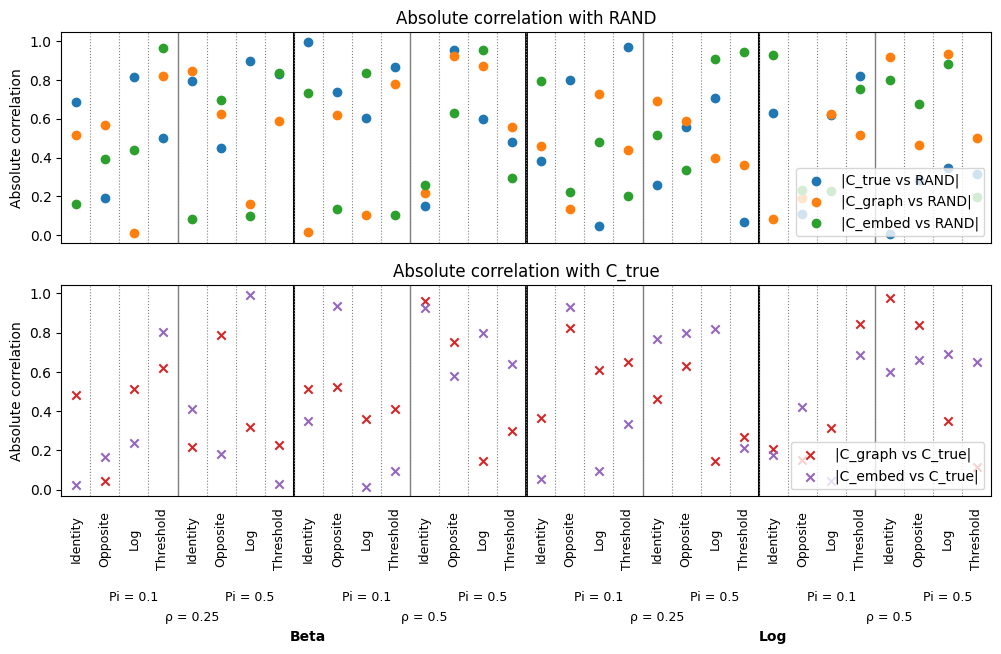

In [153]:
# metrics[(model, rho, pi, transform)] = (_, Corr_RAND, Corr_C_true, _)

# 1) Build the parameter list (Model -> Rho -> Pi -> Transform)
ordered_params = []
for m in Models:         # 16 columns per model
    for rho in RHOS:     # 8 columns per rho
        for pi in PIS:   # 4 columns per pi
            for t in Transforms:  # 1 column per transform
                ordered_params.append((m, rho, pi, t))

corr_rand_true   = []
corr_rand_graph  = []
corr_rand_embed  = []
corr_ctrue_graph = []
corr_ctrue_embed = []

# 2) Extract correlations in this order
for (model_obj, rho_val, pi_val, transform_obj) in ordered_params:
    _, Corr_RAND, Corr_C_true, _ = metrics[(pi_val, rho_val, model_obj, transform_obj)]
    corr_rand_true.append(abs(Corr_RAND[0][0]))
    corr_rand_graph.append(abs(Corr_RAND[1][0]))
    corr_rand_embed.append(abs(Corr_RAND[2][0]))
    corr_ctrue_graph.append(abs(Corr_C_true[0][0]))
    corr_ctrue_embed.append(abs(Corr_C_true[1][0]))

corr_rand_true   = np.array(corr_rand_true)
corr_rand_graph  = np.array(corr_rand_graph)
corr_rand_embed  = np.array(corr_rand_embed)
corr_ctrue_graph = np.array(corr_ctrue_graph)
corr_ctrue_embed = np.array(corr_ctrue_embed)

# 3) Plot
x = np.arange(len(corr_rand_true))  # 0..31
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

ax1.scatter(x, corr_rand_true,  color='tab:blue',   label='|C_true vs RAND|')
ax1.scatter(x, corr_rand_graph, color='tab:orange', label='|C_graph vs RAND|')
ax1.scatter(x, corr_rand_embed, color='tab:green',  label='|C_embed vs RAND|')
ax1.set_ylabel('Absolute correlation')
ax1.set_title('Absolute correlation with RAND')
ax1.legend(loc='lower right')
ax1.set_xlim(-0.5, len(x) - 0.5)

ax2.scatter(x, corr_ctrue_graph, marker='x', color='tab:red',    label='|C_graph vs C_true|')
ax2.scatter(x, corr_ctrue_embed, marker='x', color='tab:purple', label='|C_embed vs C_true|')
ax2.set_ylabel('Absolute correlation')
ax2.set_title('Absolute correlation with C_true')
ax2.legend(loc='lower right')
ax2.set_xlim(-0.5, len(x) - 0.5)

ax2.set_xticks([])
plt.subplots_adjust(bottom=0.3)

# 4) Hierarchy (Model=16 cols, Rho=8, Pi=4, Transform=1)
block_size_model      = 16
block_size_rho        = 8
block_size_pi         = 4
y_lvl_transform       = -0.25
y_lvl_pi              = -0.55
y_lvl_rho             = -0.65
y_lvl_model           = -0.75

for m_i, model_obj in enumerate(Models):
    start_m = m_i * block_size_model
    center_m = start_m + block_size_model / 2
    if model_obj.__name__ == "betaWSBM":
        model_name = "Beta"
    elif model_obj.__name__ == "lognormWSBM":
        model_name = "Log"
    else:
        model_name = model_obj.__name__
    ax2.text(center_m, y_lvl_model, model_name,
             ha='center', va='center', transform=ax2.transData,
             fontsize=10, fontweight='bold')

    for r_i, rho_val in enumerate(RHOS):
        start_r = start_m + r_i * block_size_rho
        center_r = start_r + block_size_rho / 2
        ax2.text(center_r, y_lvl_rho, f"ρ = {rho_val}",
                 ha='center', va='center', transform=ax2.transData,
                 fontsize=9)

        for pi_i, pi_val in enumerate(PIS):
            start_pi = start_r + pi_i * block_size_pi
            center_pi = start_pi + block_size_pi / 2
            ax2.text(center_pi, y_lvl_pi, f"Pi = {pi_val}",
                     ha='center', va='center', transform=ax2.transData,
                     fontsize=9)

            for t_i, t_obj in enumerate(Transforms):
                x_pos = start_pi + t_i
                ax2.text(x_pos, y_lvl_transform, t_obj.name,
                         ha='center', va='center', rotation=90,
                         transform=ax2.transData, fontsize=9)

# 5) Vertical lines
def draw_vertical_lines(ax, x_positions, color='k', lw=1, alpha=1, style='-'):
    for pos in x_positions:
        ax.axvline(pos - 0.5, color=color, linewidth=lw, alpha=alpha,
                   linestyle=style, zorder=0)

model_boundaries = [16]
rho_boundaries   = [8, 24]
pi_boundaries    = [4, 12, 20, 28]
transform_boundaries = [i for i in range(1, 32)]

for ax_ in (ax1, ax2):
    draw_vertical_lines(ax_, model_boundaries, color='black', lw=2)
    draw_vertical_lines(ax_, rho_boundaries,   color='black', lw=1.5)
    draw_vertical_lines(ax_, pi_boundaries,    color='gray',  lw=1)
    draw_vertical_lines(ax_, transform_boundaries, color='gray', lw=0.8, style='dotted')

plt.show()
